In [17]:
import sys
print(sys.path)
sys.path.append('E:\\学习\\5药物研发\\靶点发现\\下游任务\\整合去批次\\unified\\code\\')

['E:\\学习\\5药物研发\\靶点发现\\下游任务\\整合去批次\\unified\\code\\analysis\\1RNA\\pancreas', 'C:\\Users\\10360\\anaconda3\\envs\\py39\\python39.zip', 'C:\\Users\\10360\\anaconda3\\envs\\py39\\DLLs', 'C:\\Users\\10360\\anaconda3\\envs\\py39\\lib', 'C:\\Users\\10360\\anaconda3\\envs\\py39', '', 'C:\\Users\\10360\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\10360\\anaconda3\\envs\\py39\\lib\\site-packages', 'C:\\Users\\10360\\anaconda3\\envs\\py39\\lib\\site-packages\\win32', 'C:\\Users\\10360\\anaconda3\\envs\\py39\\lib\\site-packages\\win32\\lib', 'C:\\Users\\10360\\anaconda3\\envs\\py39\\lib\\site-packages\\Pythonwin', 'E:\\学习\\5药物研发\\靶点发现\\下游任务\\整合去批次\\unified\\code\\']


In [18]:
import scanpy as sc
import pandas as pd
import numpy as np
from scCorrect import scCorrect, label_transfer
from scCorrect import metrics

In [19]:
sc.set_figure_params(dpi=300, figsize=(4, 4), frameon=False)    # TODO 是否画边框

C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scanpy\_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [20]:
path_results = './log/real_scCorrect_30000/'

In [21]:
def clear_fig(fig):
    if fig:
        fig.axes[0].set_xlabel(None)
        fig.axes[0].set_ylabel(None)
        fig.tight_layout()
    else:
        pass
    return fig

In [22]:
adata1 = sc.read_h5ad('raw-pancreas-human-celseq.h5ad')
adata2 = sc.read_h5ad('raw-pancreas-human-celseq2.h5ad')

adata3 = sc.read_h5ad('raw-pancreas-human-inDrop1.h5ad')
adata4 = sc.read_h5ad('raw-pancreas-human-inDrop2.h5ad')
adata5 = sc.read_h5ad('raw-pancreas-human-inDrop3.h5ad')
adata6 = sc.read_h5ad('raw-pancreas-human-inDrop4.h5ad')
adata10 = sc.concat([adata3, adata4, adata5, adata6])

adata7 = sc.read_h5ad('raw-pancreas-human-smarter.h5ad')
adata8 = sc.read_h5ad('raw-pancreas-human-smartseq2.h5ad')

adata9 = sc.read_h5ad('raw-pancreas-human-fluidigmc1.h5ad')

In [23]:
adata1.X.max()

10.984847

In [24]:
data_list = [adata1, adata2, adata10, adata7, adata8, adata9]

In [25]:
conditions = ['celseq', 'celseq2', 'inDrop', 'smarter', 'smartseq2', 'fluidigmc1']

In [26]:
adata_raw = sc.concat(data_list, label='batch', keys=conditions)
adata_raw

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'cell_ontology_class', 'batch'

In [27]:
adata_raw.layers['counts'] = np.floor(np.exp(adata_raw.X.todense()) - 1)

In [28]:
adata_raw.layers['counts'].max()

443598.0

2023-08-18 16:16:49,736 - root - INFO - Raw dataset shape: (16382, 19093)
... storing 'tech' as categorical
... storing 'celltype' as categorical
... storing 'cell_ontology_class' as categorical
2023-08-18 16:16:52,372 - root - INFO - Batch specific maxabs scaling
2023-08-18 16:16:53,815 - root - INFO - model
VAE(
  (encoder): Encoder(
    (fc): Linear(in_features=2000, out_features=1024, bias=True)
    (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (mean_fc): Linear(in_features=1024, out_features=10, bias=True)
    (var_fc): Linear(in_features=1024, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=10, out_features=2000, bias=True)
    (norm): DSASRNorm(
      (bns): ModuleList(
        (0): ASRNormBN1d(
          (relu): ReLU(inplace=True)
          (tanh): Tanh()
          (sigmoid): Sigmoid()
          (standard_encoder): Linear(in_features=

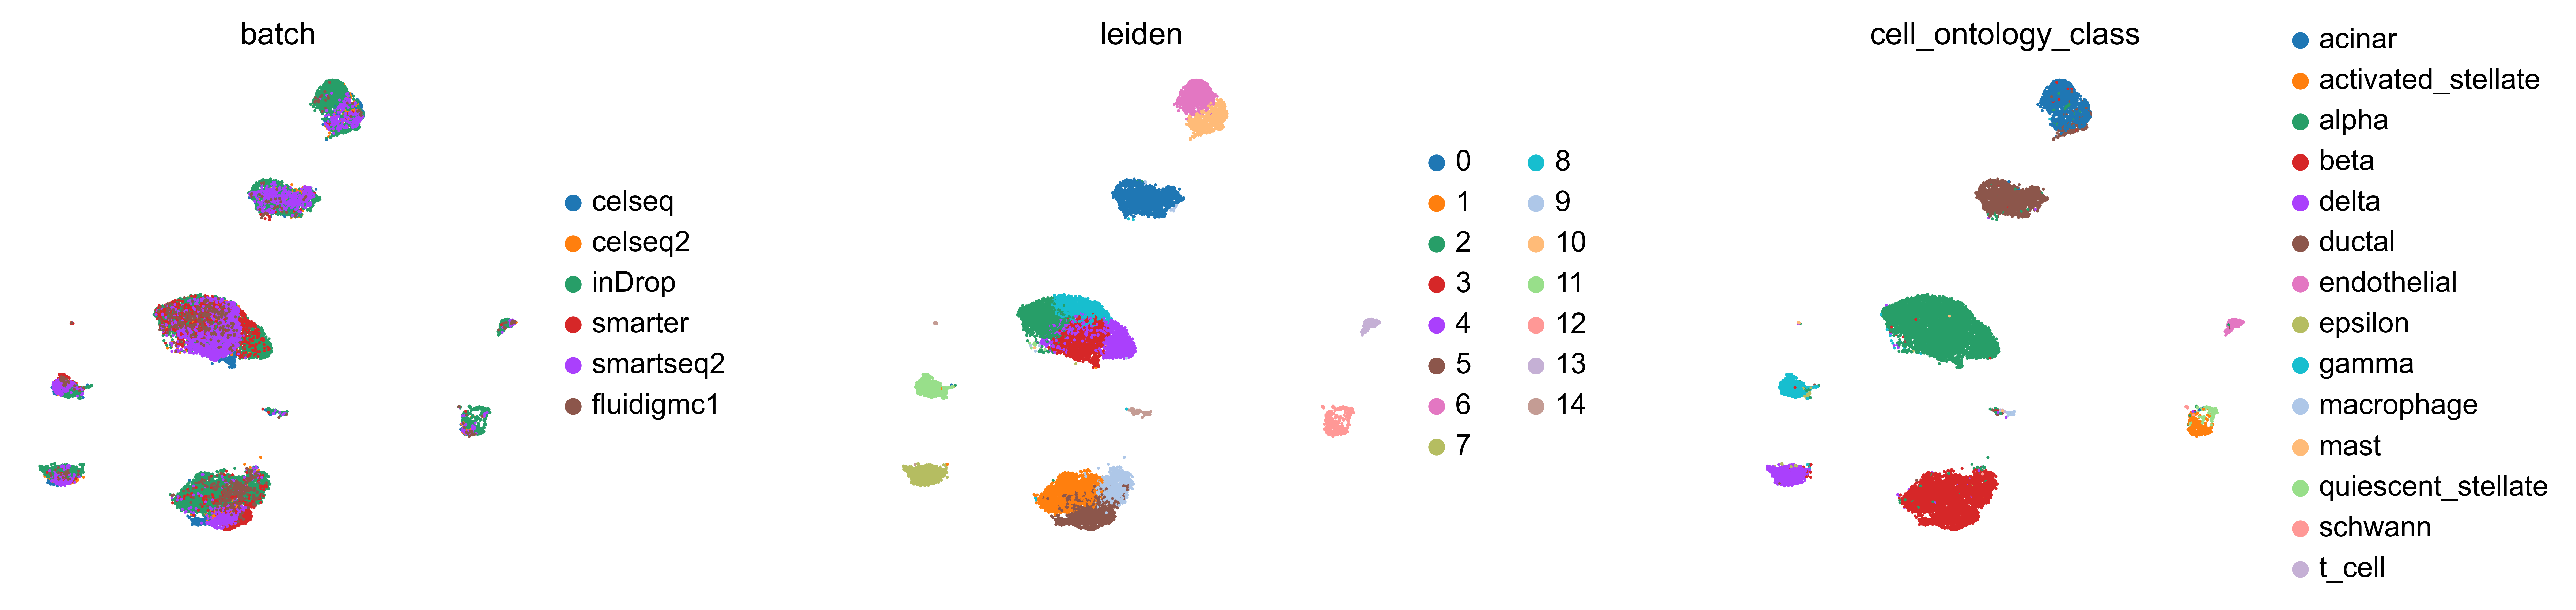

2023-08-18 16:48:40,403 - root - INFO - batch_entropy_mixing_score: 0.458


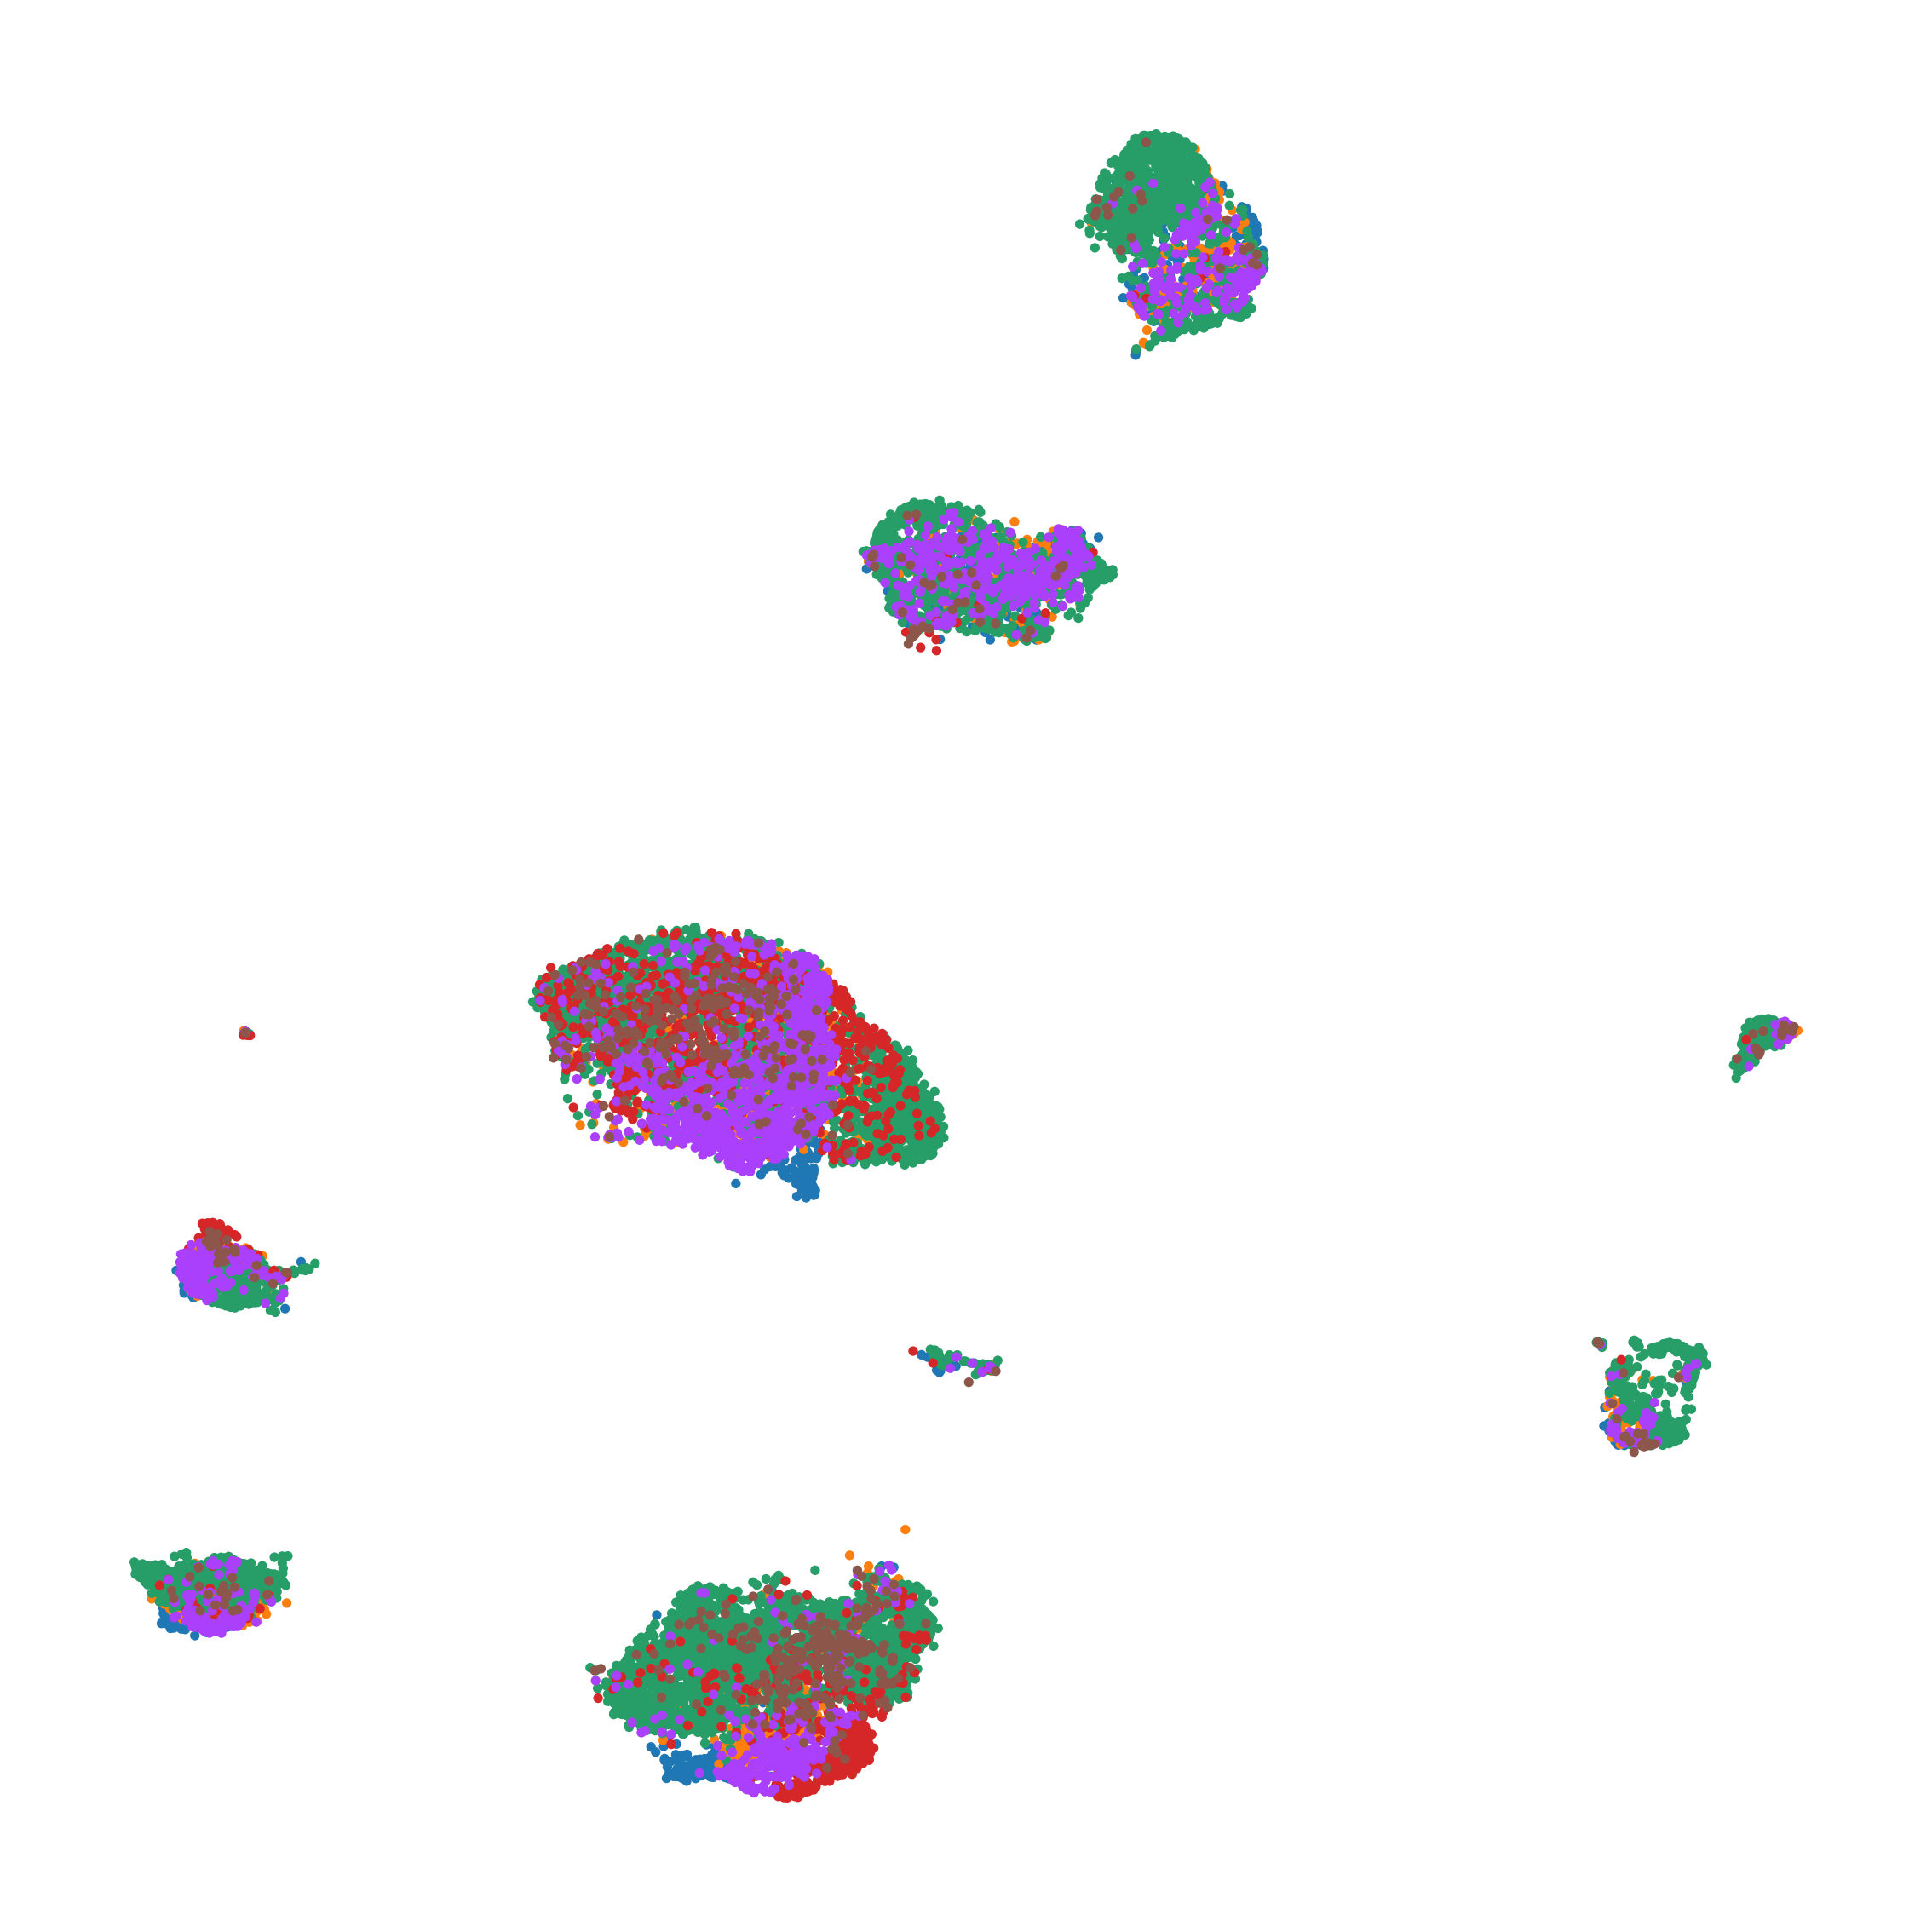

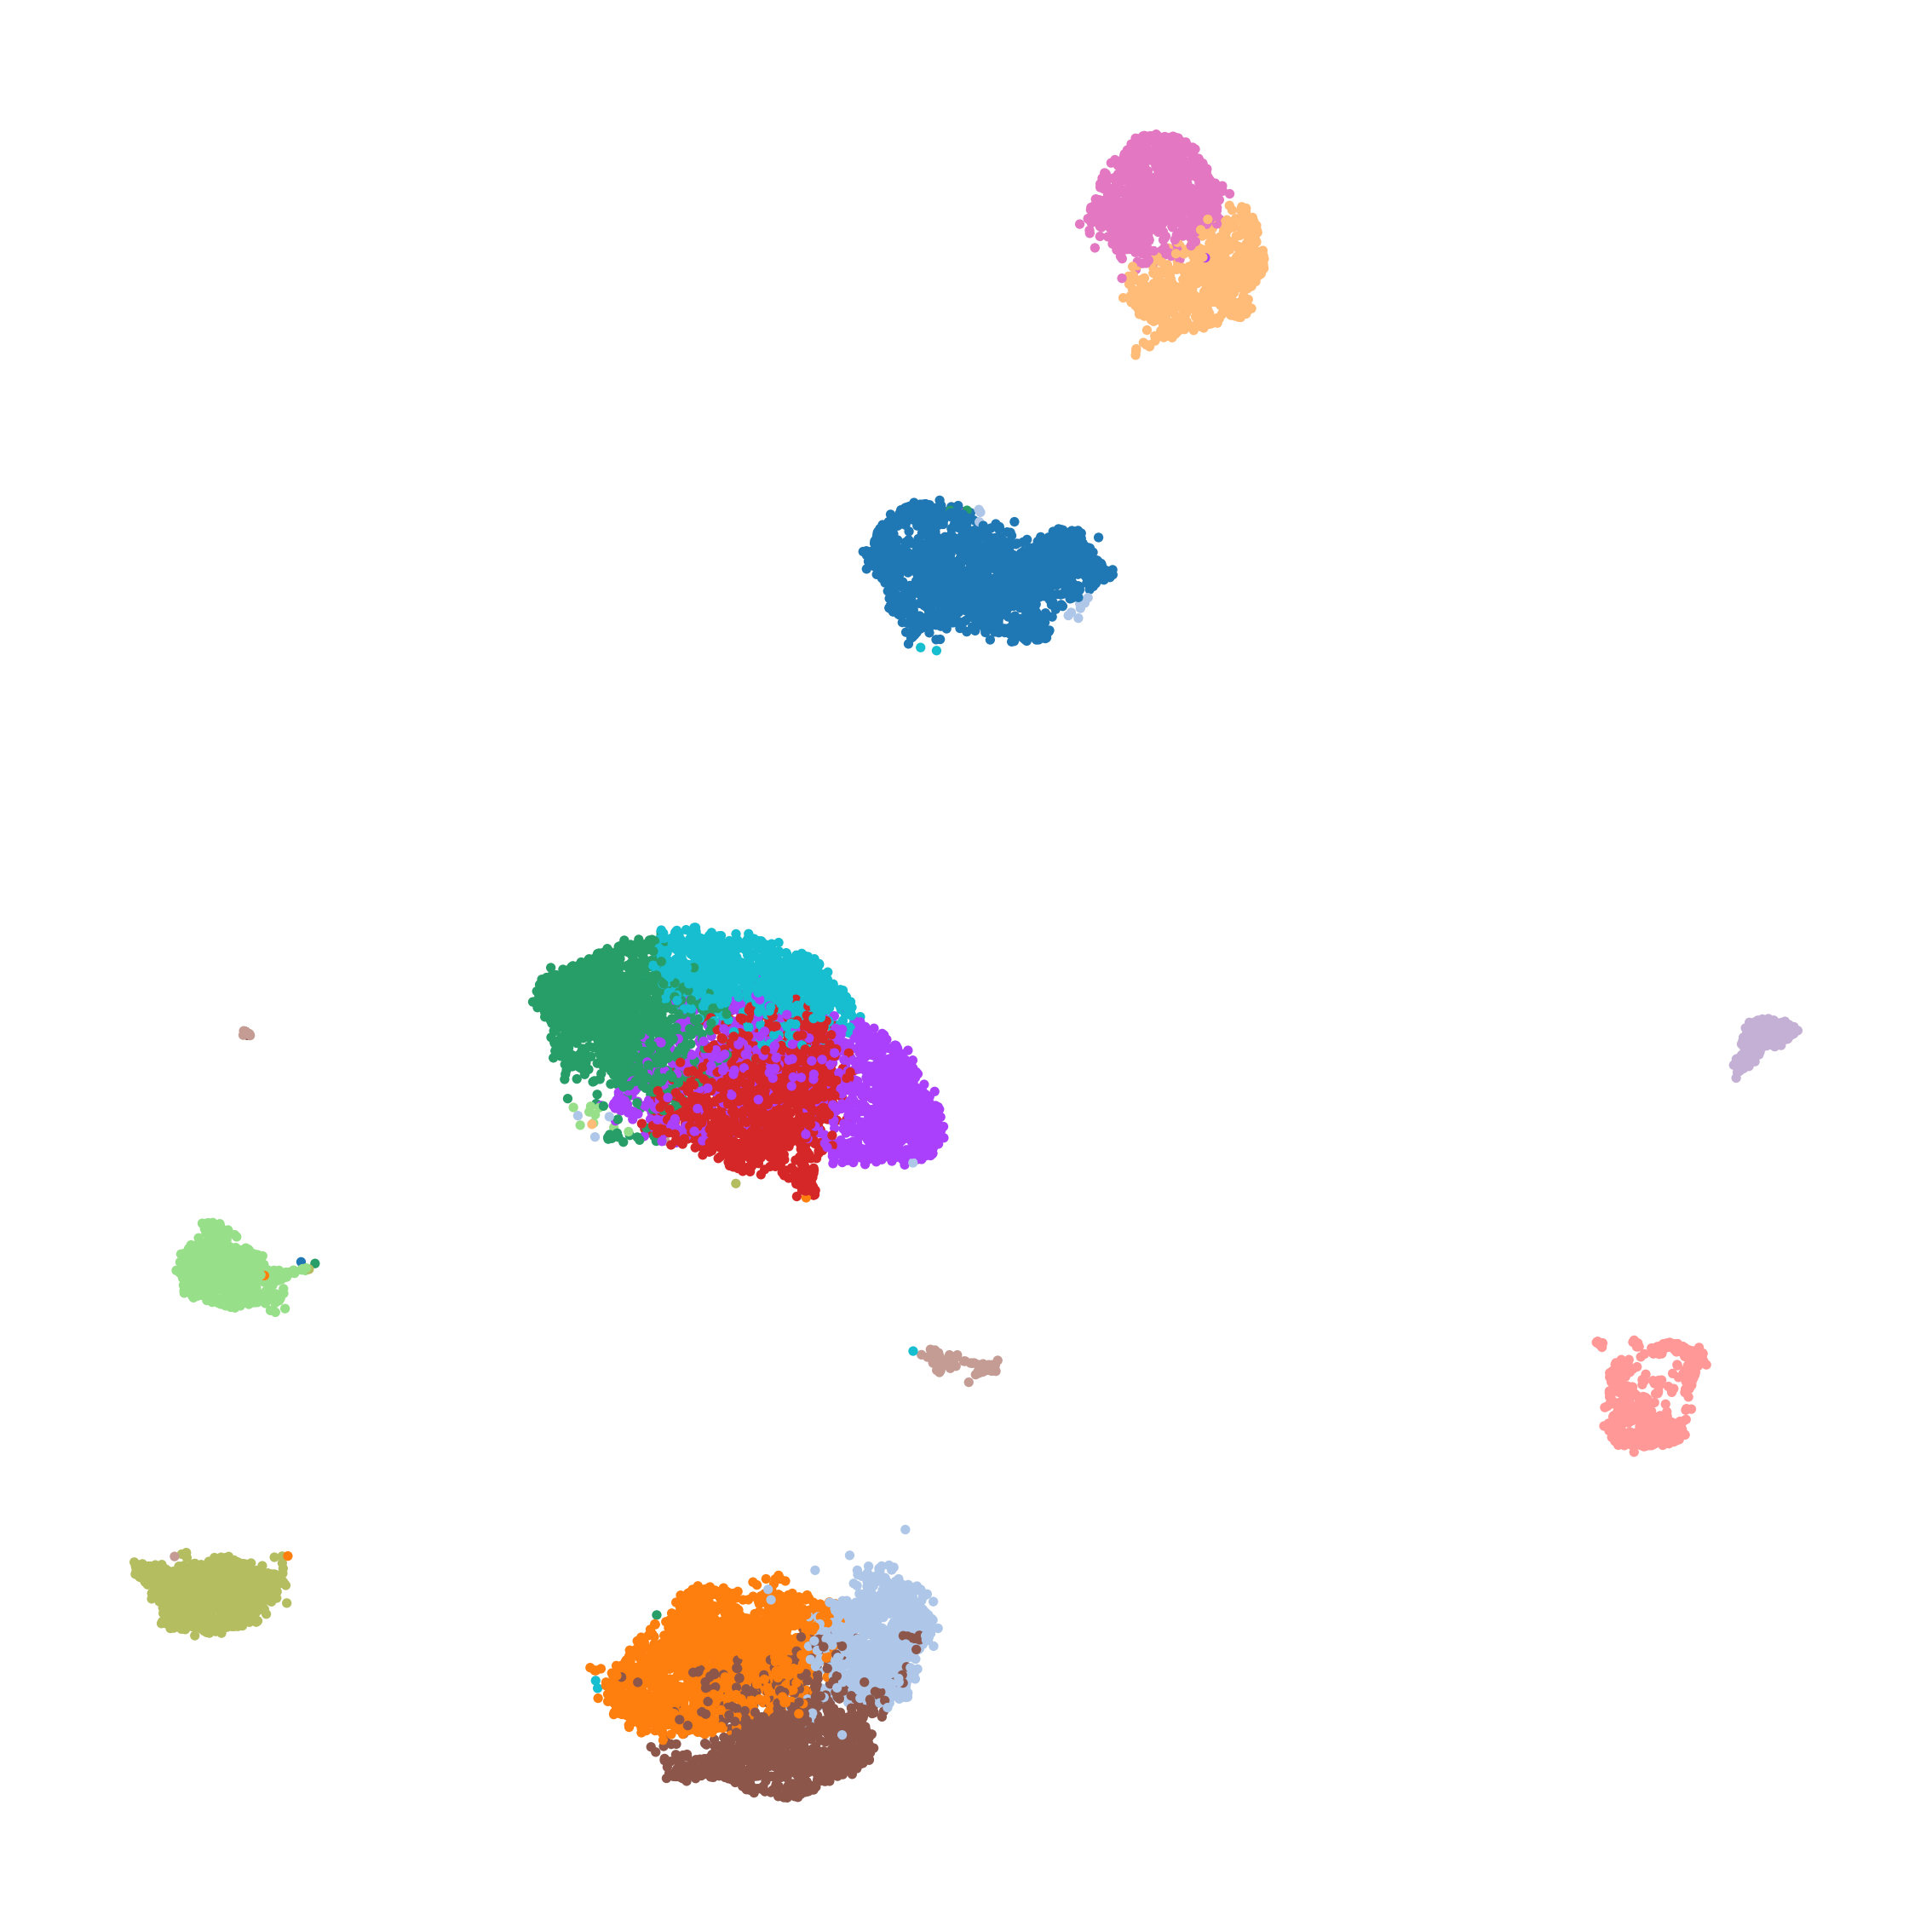

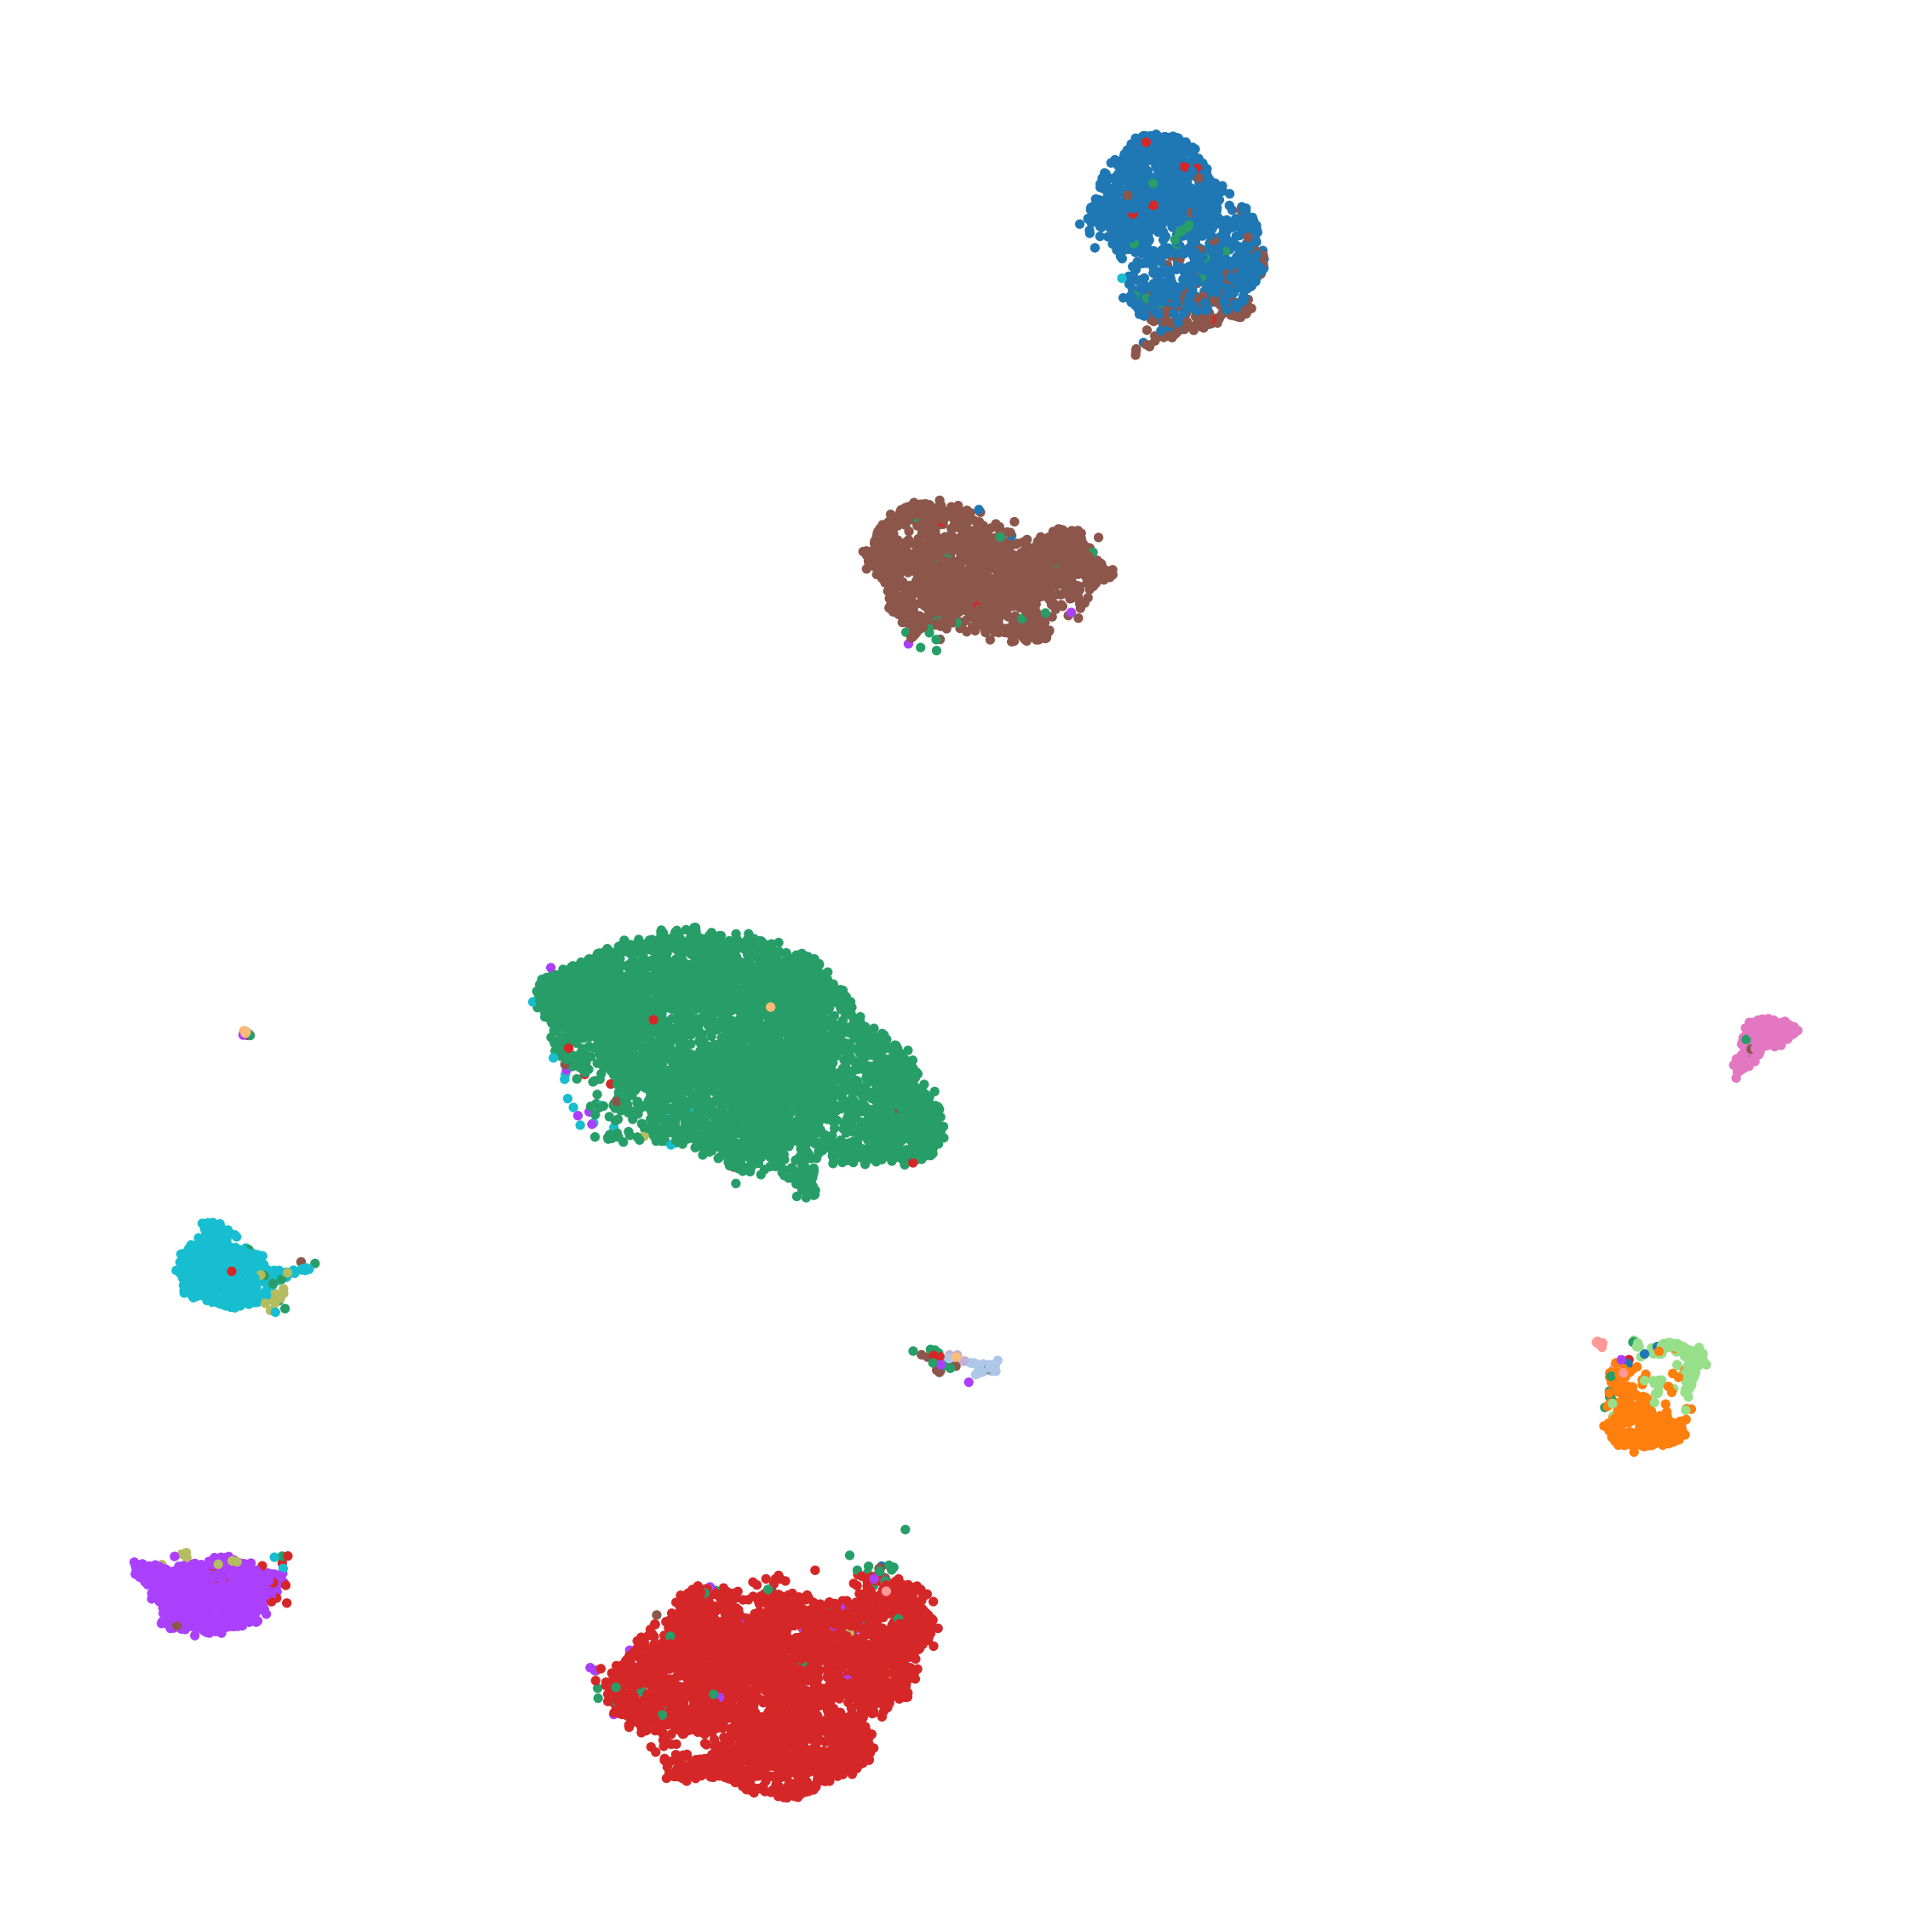

In [14]:
adata_scCorrect = scCorrect(data_list=data_list, batch_categories=conditions, batch_key='batch', max_iteration=30000,
                      outdir=path_results, assess=True, preprocessed=False)

In [15]:
scCorrect_bems = metrics.batch_entropy_mixing_score(adata_scCorrect.obsm['X_umap'], adata_scCorrect.obs['batch'])
print(scCorrect_bems)
scCorrect_sc = metrics.silhouette_score(adata_scCorrect.obsm['X_umap'], adata_scCorrect.obs['cell_ontology_class'].cat.codes)
print(scCorrect_sc)

0.45401584975781445
0.6002848


In [16]:
scCorrect_metrics = metrics.evaluate_all(adata_raw, adata_scCorrect, 'scalex', batch_key='batch', label_key='cell_ontology_class', cluster_nmi=None, verbose=False)
print(scCorrect_metrics)


C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
                                  0
NMI_cluster/label          0.903559
ARI_cluster/label          0.941629
ASW_label                  0.634816
ASW_label/batch            0.883799
PCR_batch                  0.997992
cell_cycle_conservation         NaN
isolated_label_F1          0.090323
isolated_label_silhouette  0.678387
graph_conn                 0.991548
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN


In [29]:
scCorrect_metrics.to_csv(f'{path_results}/metrics_scCorrect.csv', index=True, header=True)

# baseline method

In [30]:
adata_raw

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'cell_ontology_class', 'batch'
    layers: 'counts'

In [31]:
adata_raw.X.max()

13.002677

In [32]:
sc.pp.highly_variable_genes(adata_raw, n_top_genes=2000)
adata_raw = adata_raw[:, adata_raw.var.highly_variable]
adata_raw.raw = adata_raw
adata_raw

AnnData object with n_obs × n_vars = 16382 × 2000
    obs: 'tech', 'celltype', 'size_factors', 'cell_ontology_class', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'counts'

In [33]:
sc.tl.pca(adata_raw)
sc.pp.neighbors(adata_raw, n_neighbors=30)
sc.tl.umap(adata_raw, min_dist=0.1)

... storing 'tech' as categorical
... storing 'celltype' as categorical
... storing 'cell_ontology_class' as categorical


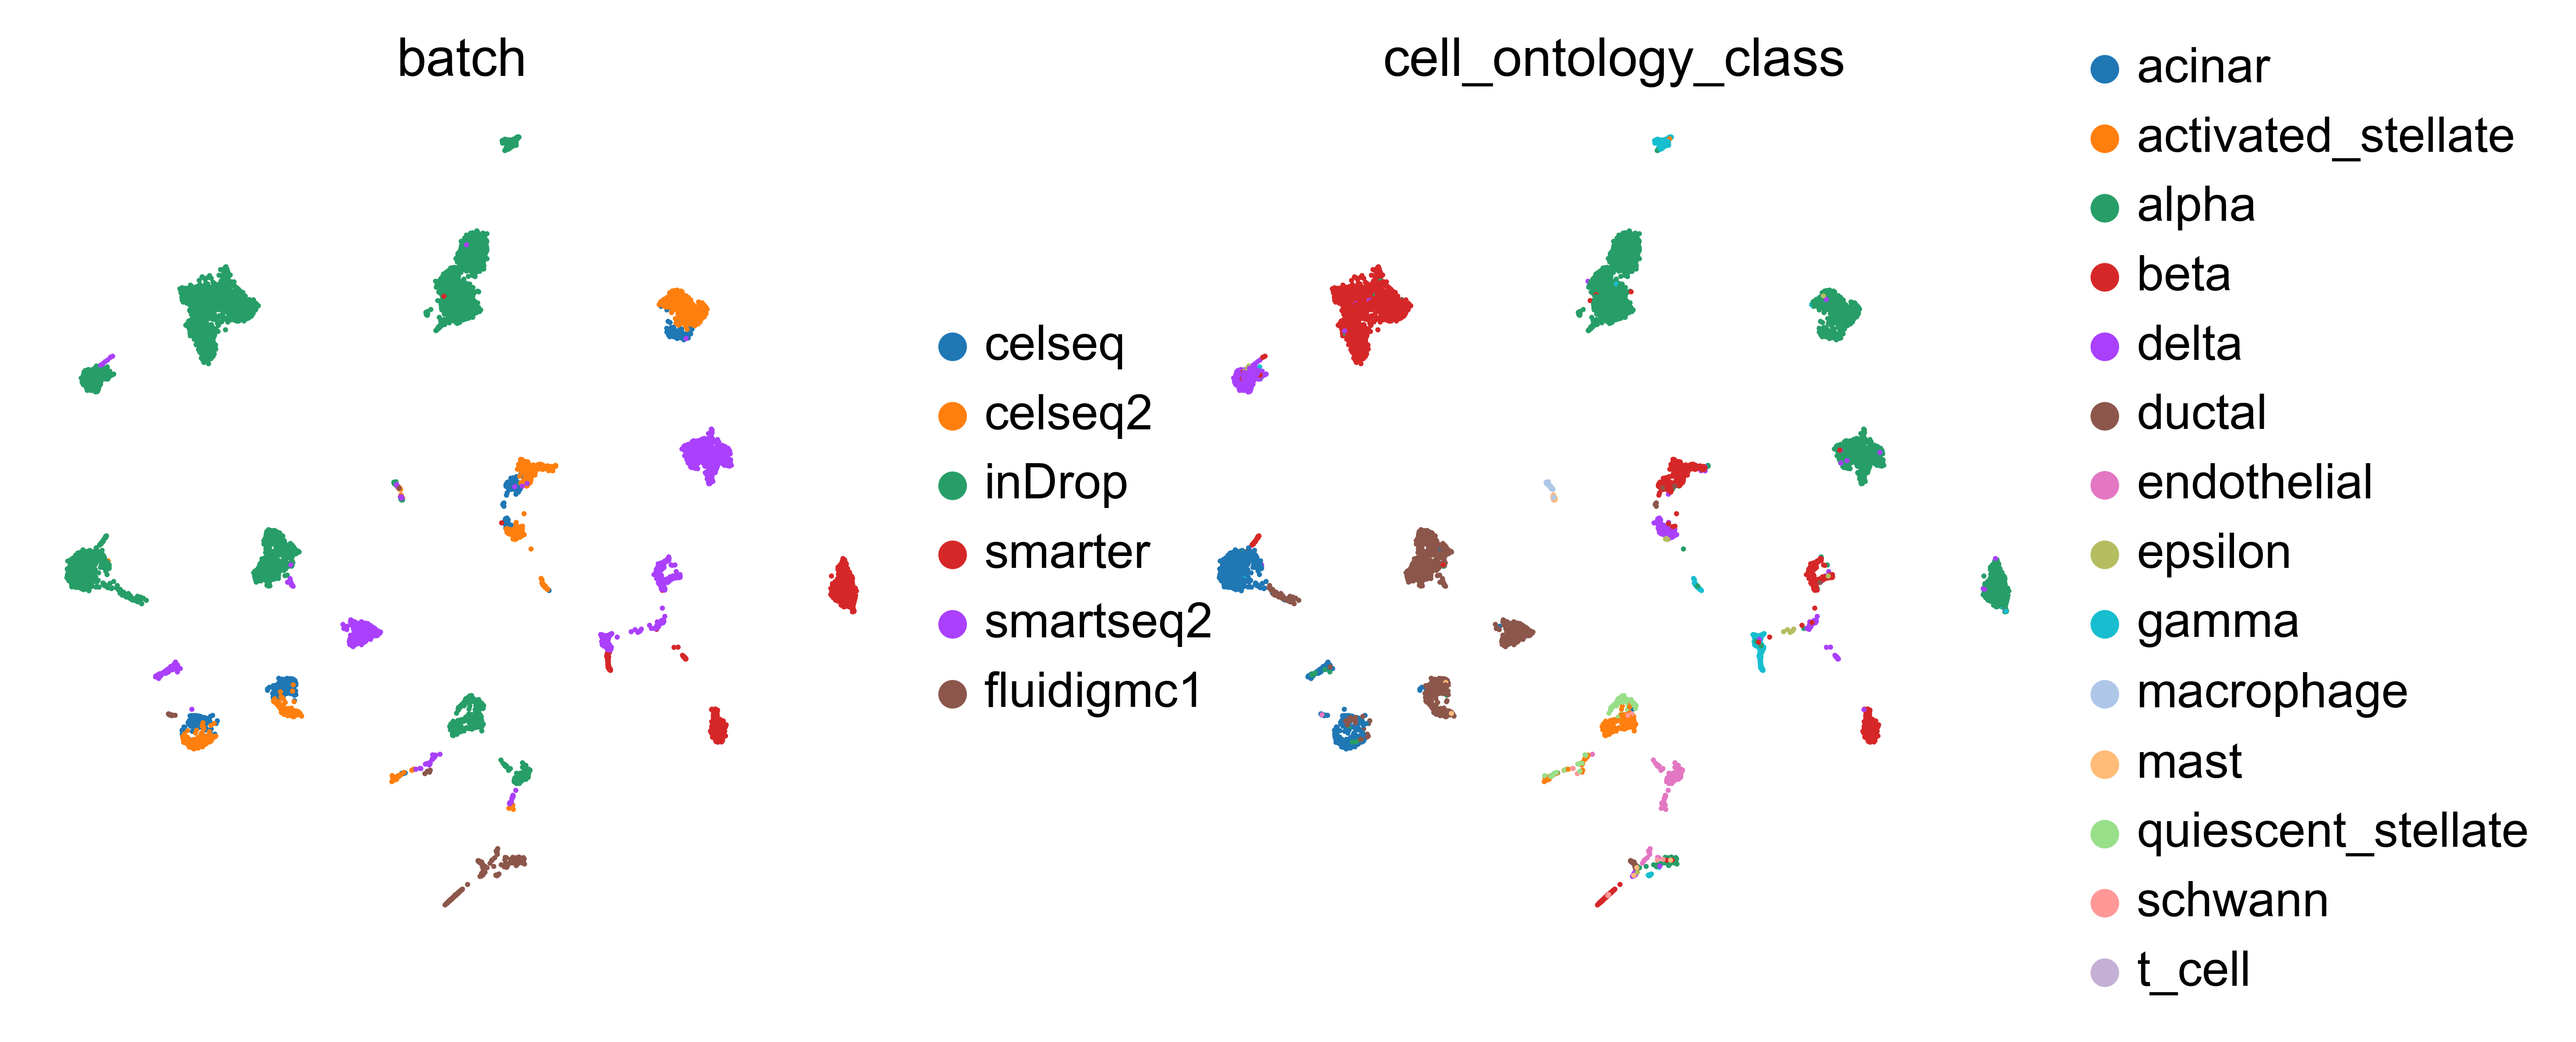

[None, None]

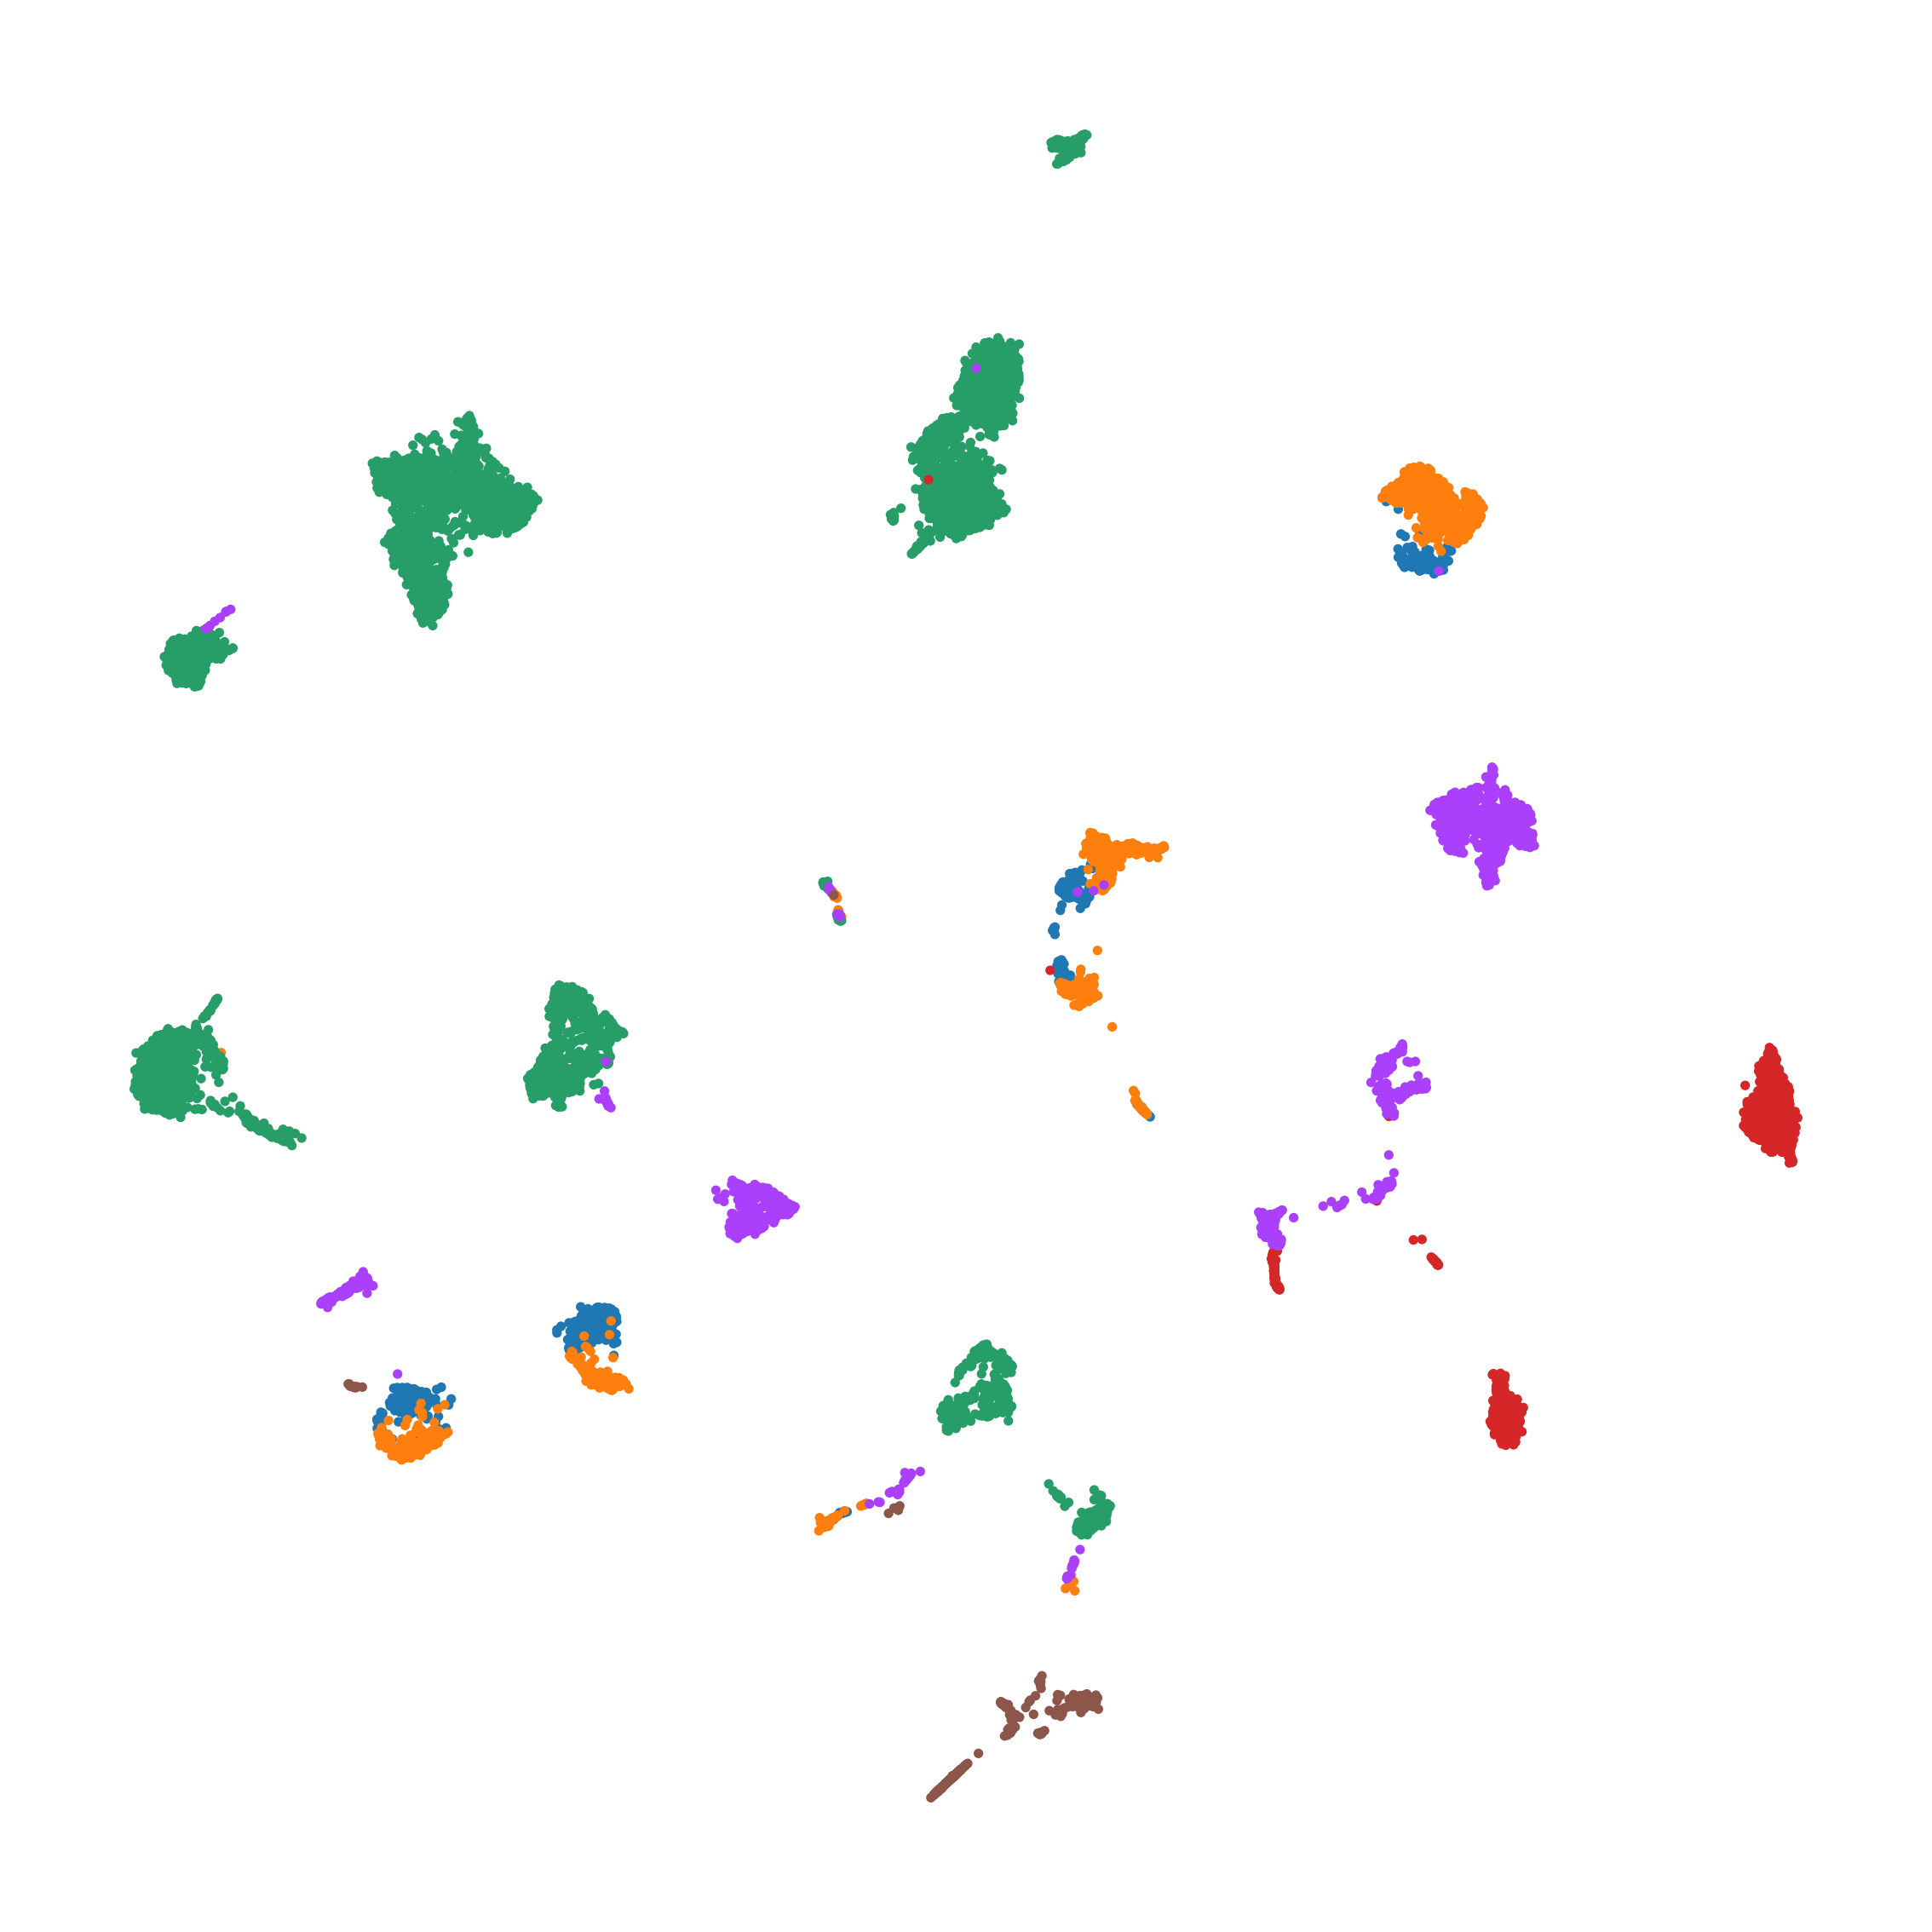

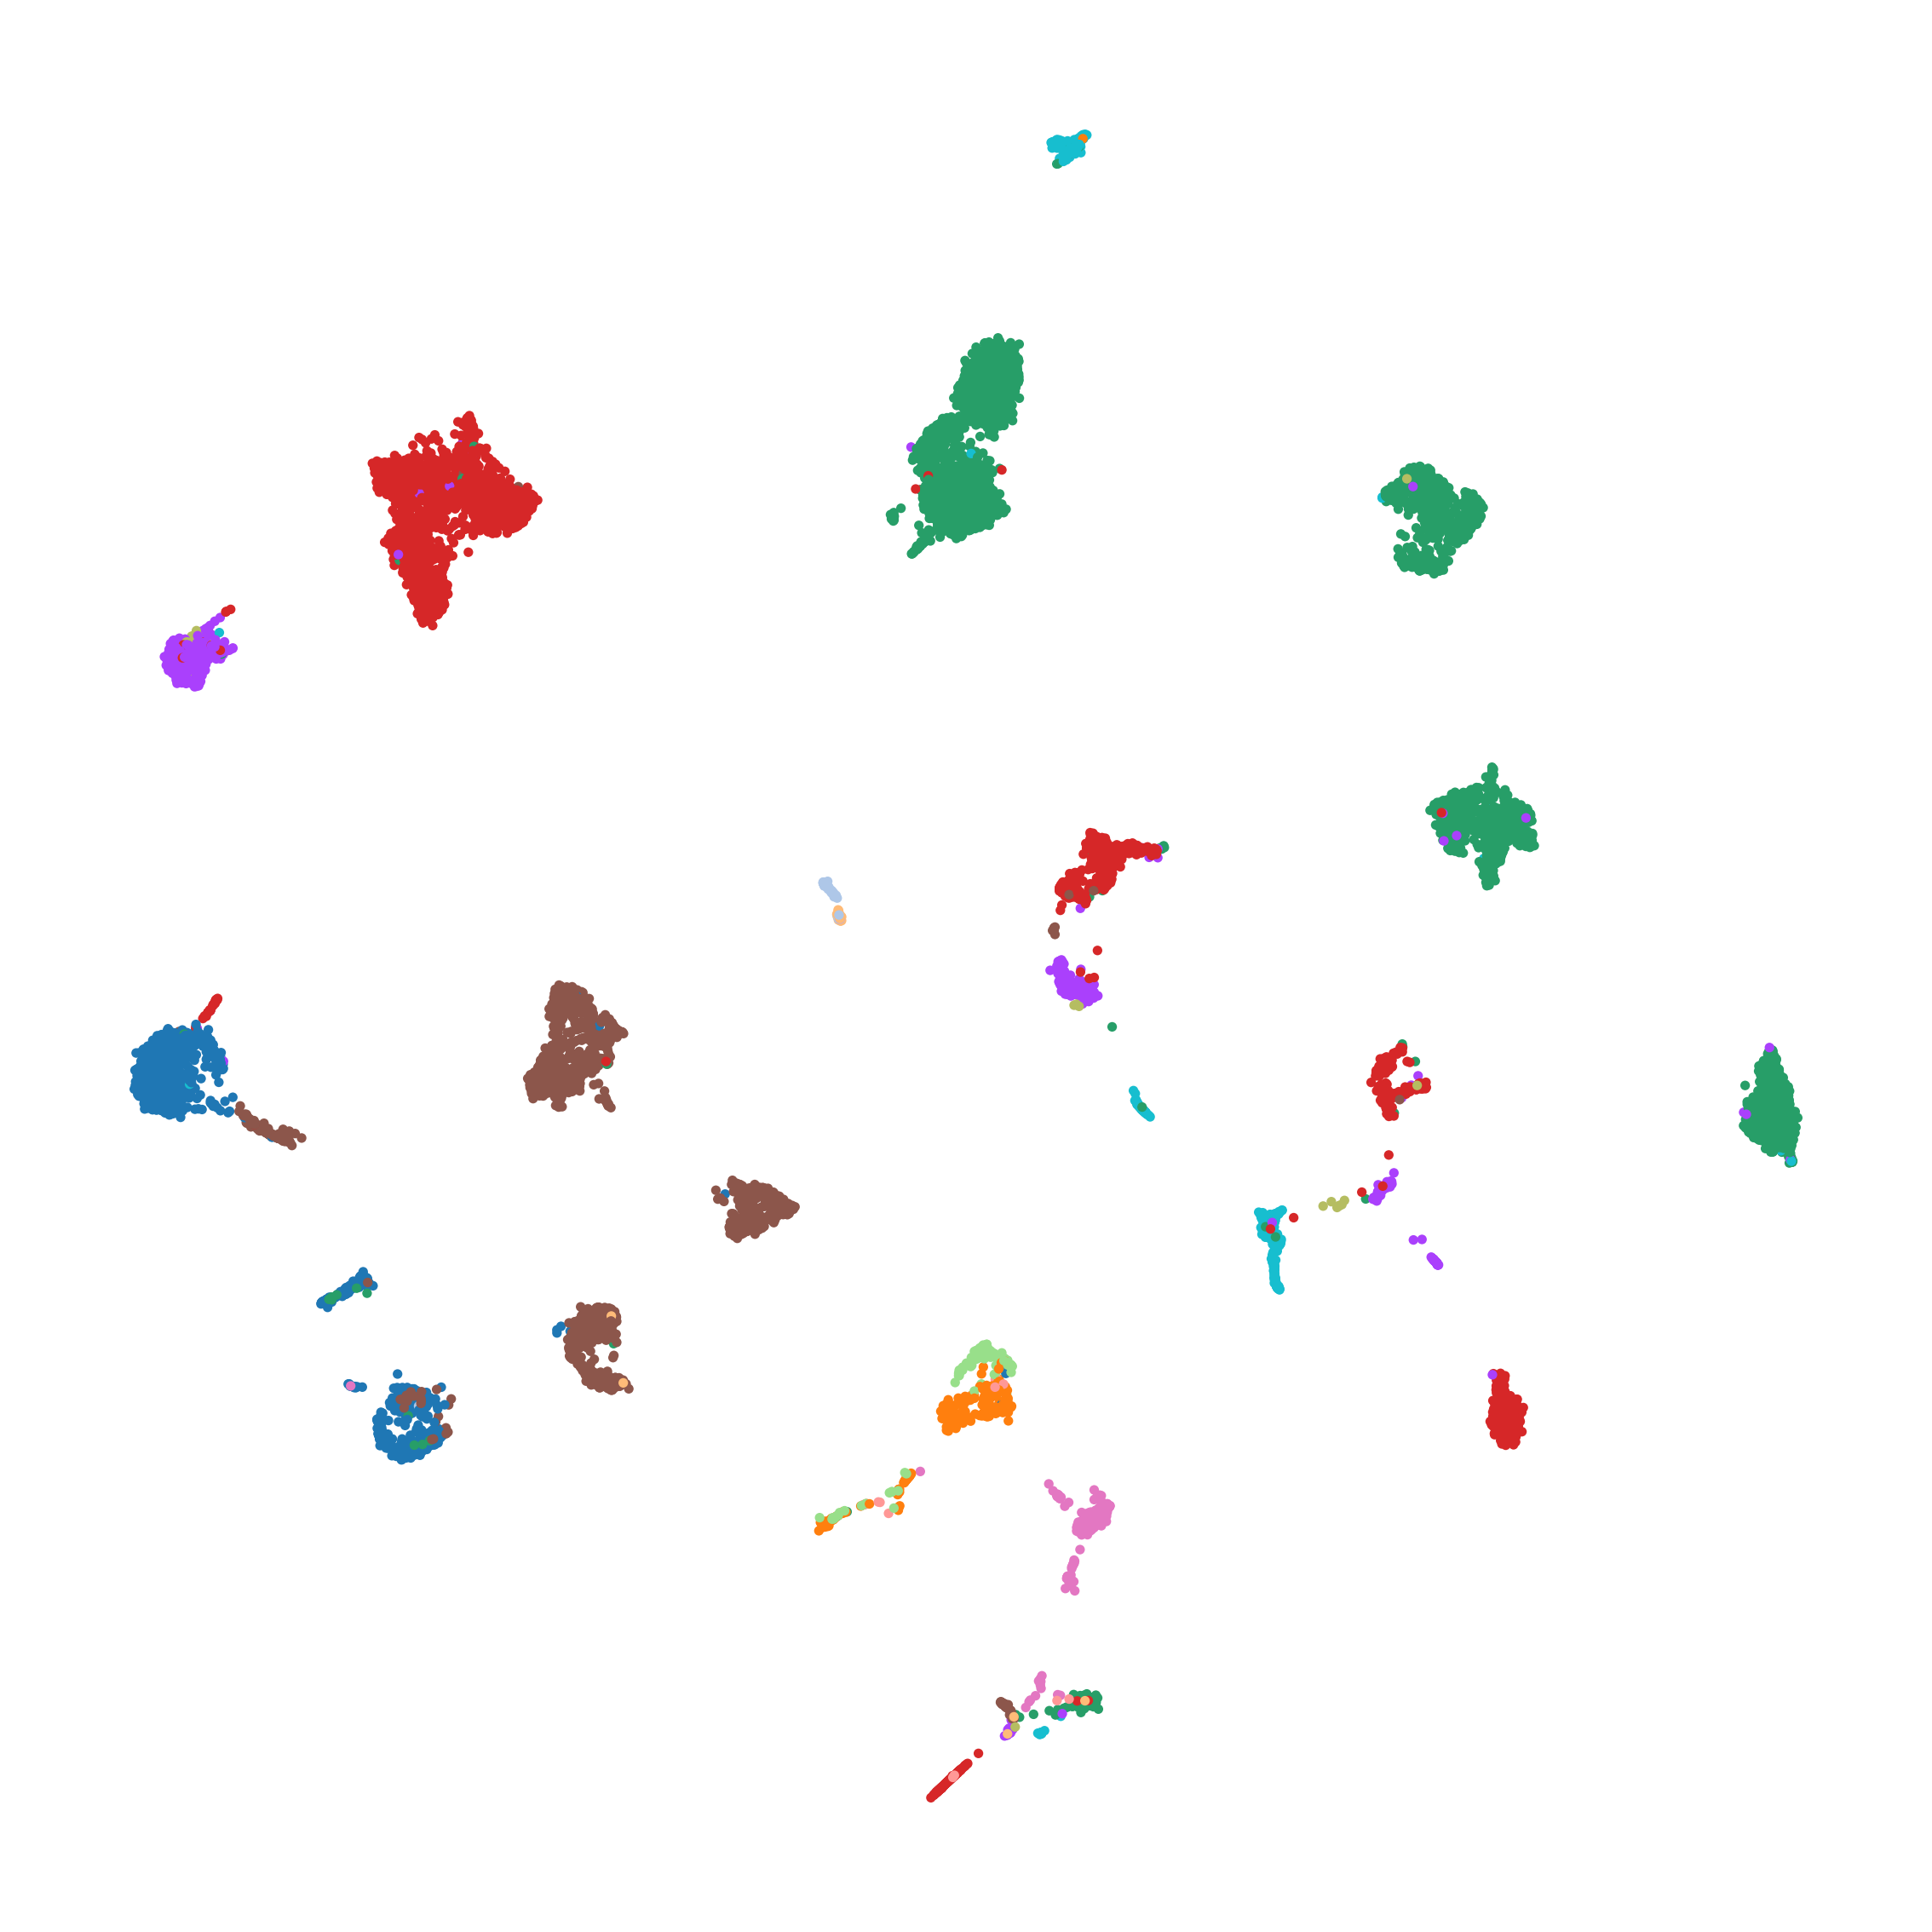

In [34]:
fig = sc.pl.umap(adata_raw, color=['batch', 'cell_ontology_class'])
[clear_fig(sc.pl.umap(adata_raw, color=c, title='', legend_loc=None, return_fig=True)).savefig(f'./{path_results}/raw_{c}.jpg')  for c in ['batch', 'cell_ontology_class']]

# scanorama

In [32]:
from scCorrect.baseline import scanorama_integrate
adata_scanorama = scanorama_integrate(adata_raw)
sc.pp.neighbors(adata_scanorama, use_rep='X_emb', n_neighbors=30)
sc.tl.umap(adata_scanorama, min_dist=0.1)

Found 2000 genes among all datasets
[[0.         0.76294821 0.28585657 0.00996016 0.16533865 0.02037618]
 [0.         0.         0.09190372 0.1038874  0.54923414 0.03134796]
 [0.         0.         0.         0.01809651 0.10944027 0.01410658]
 [0.         0.         0.         0.         0.47184987 0.43260188]
 [0.         0.         0.         0.         0.         0.17711599]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 4)
Processing datasets (3, 4)
Processing datasets (3, 5)
Processing datasets (0, 2)
Processing datasets (4, 5)
Processing datasets (0, 4)
Processing datasets (2, 4)
Processing datasets (1, 3)


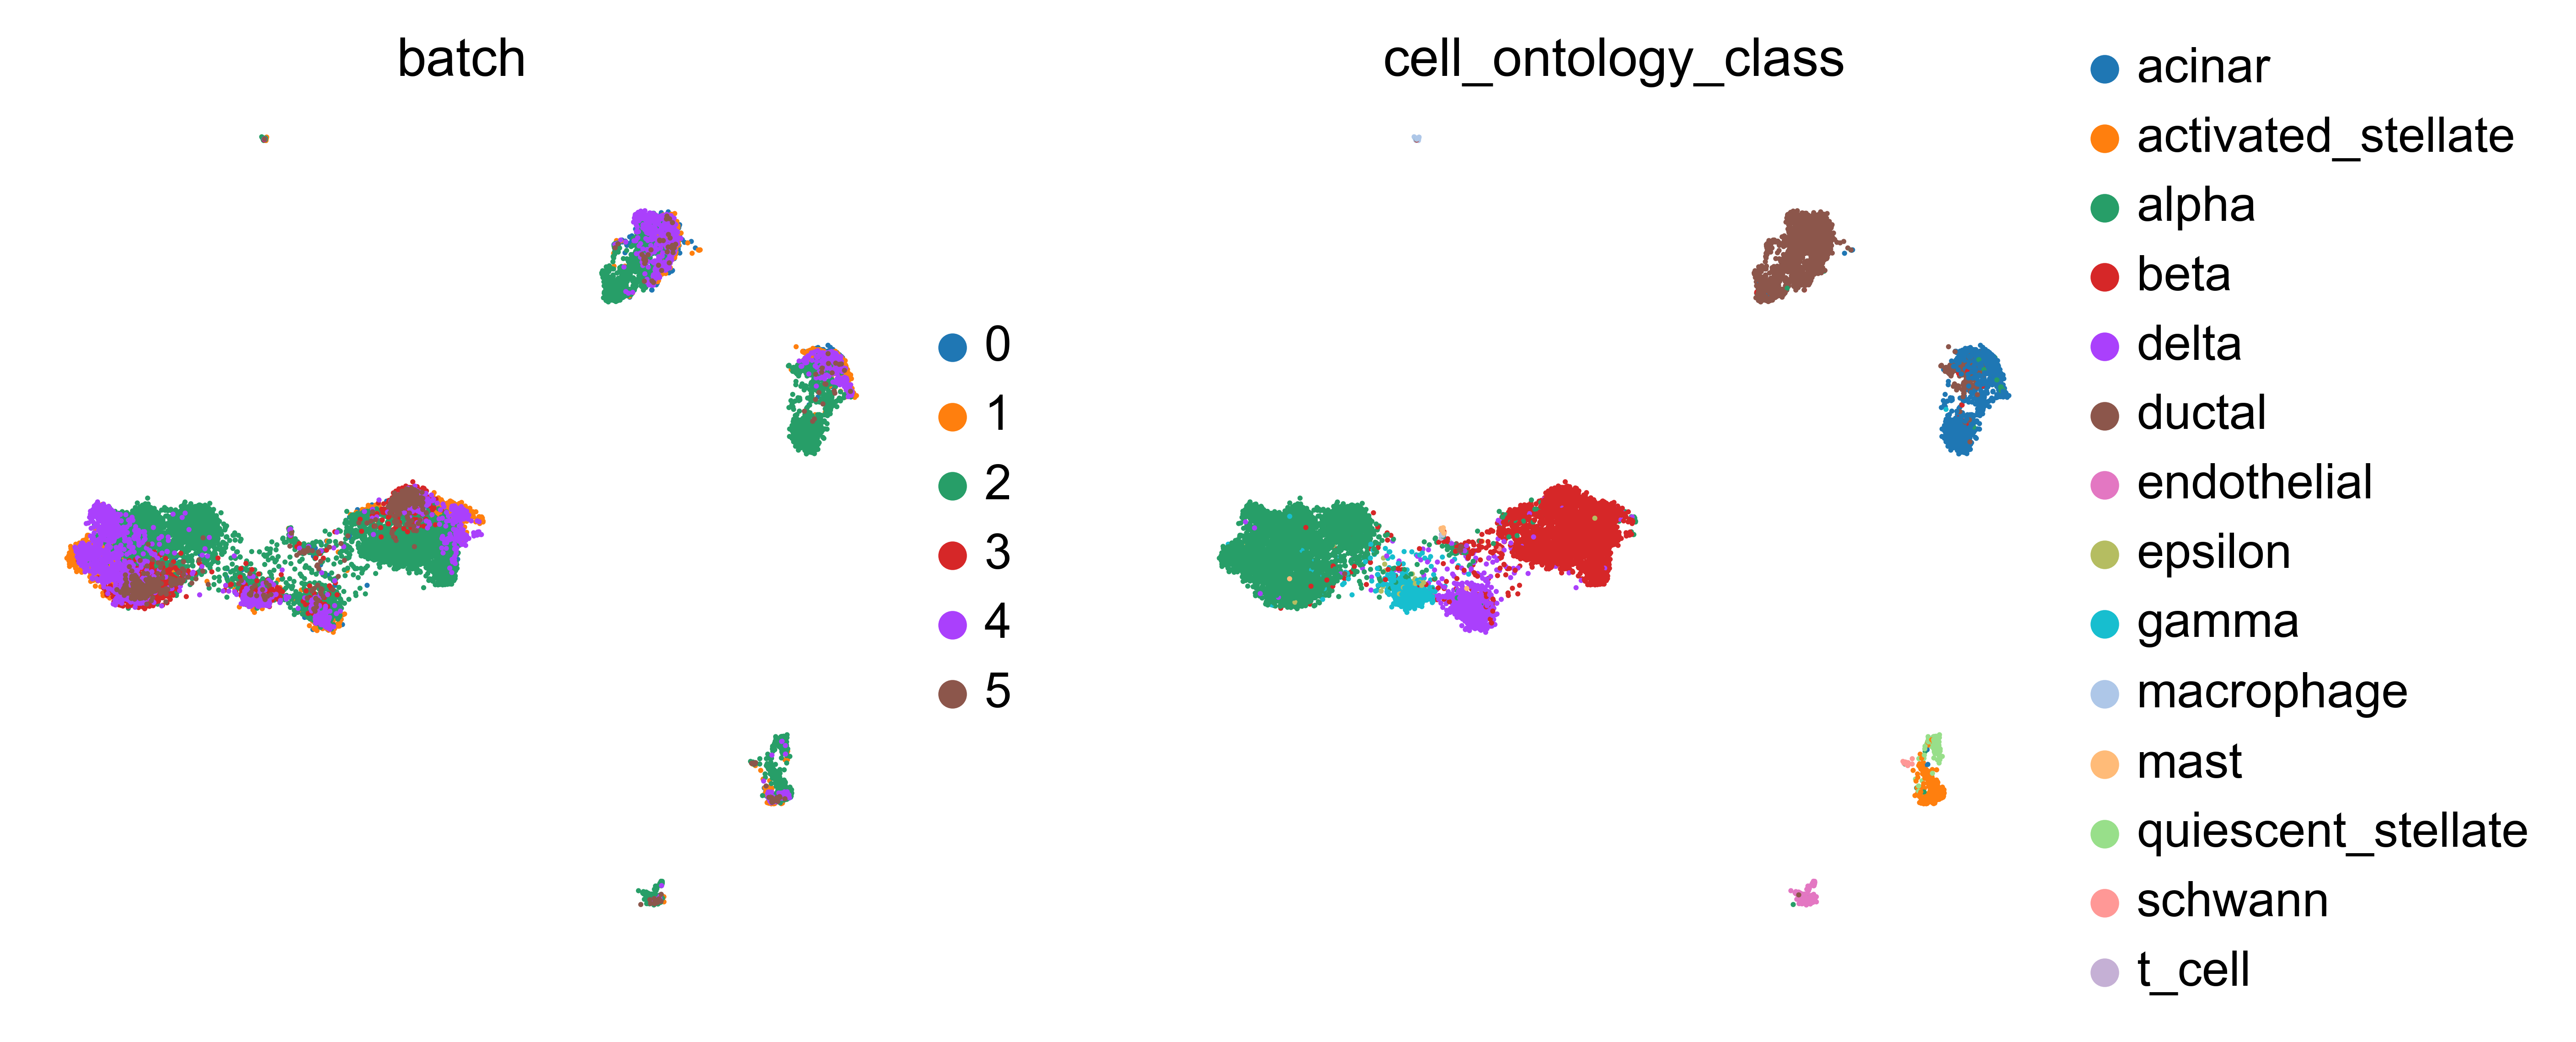

[None, None]

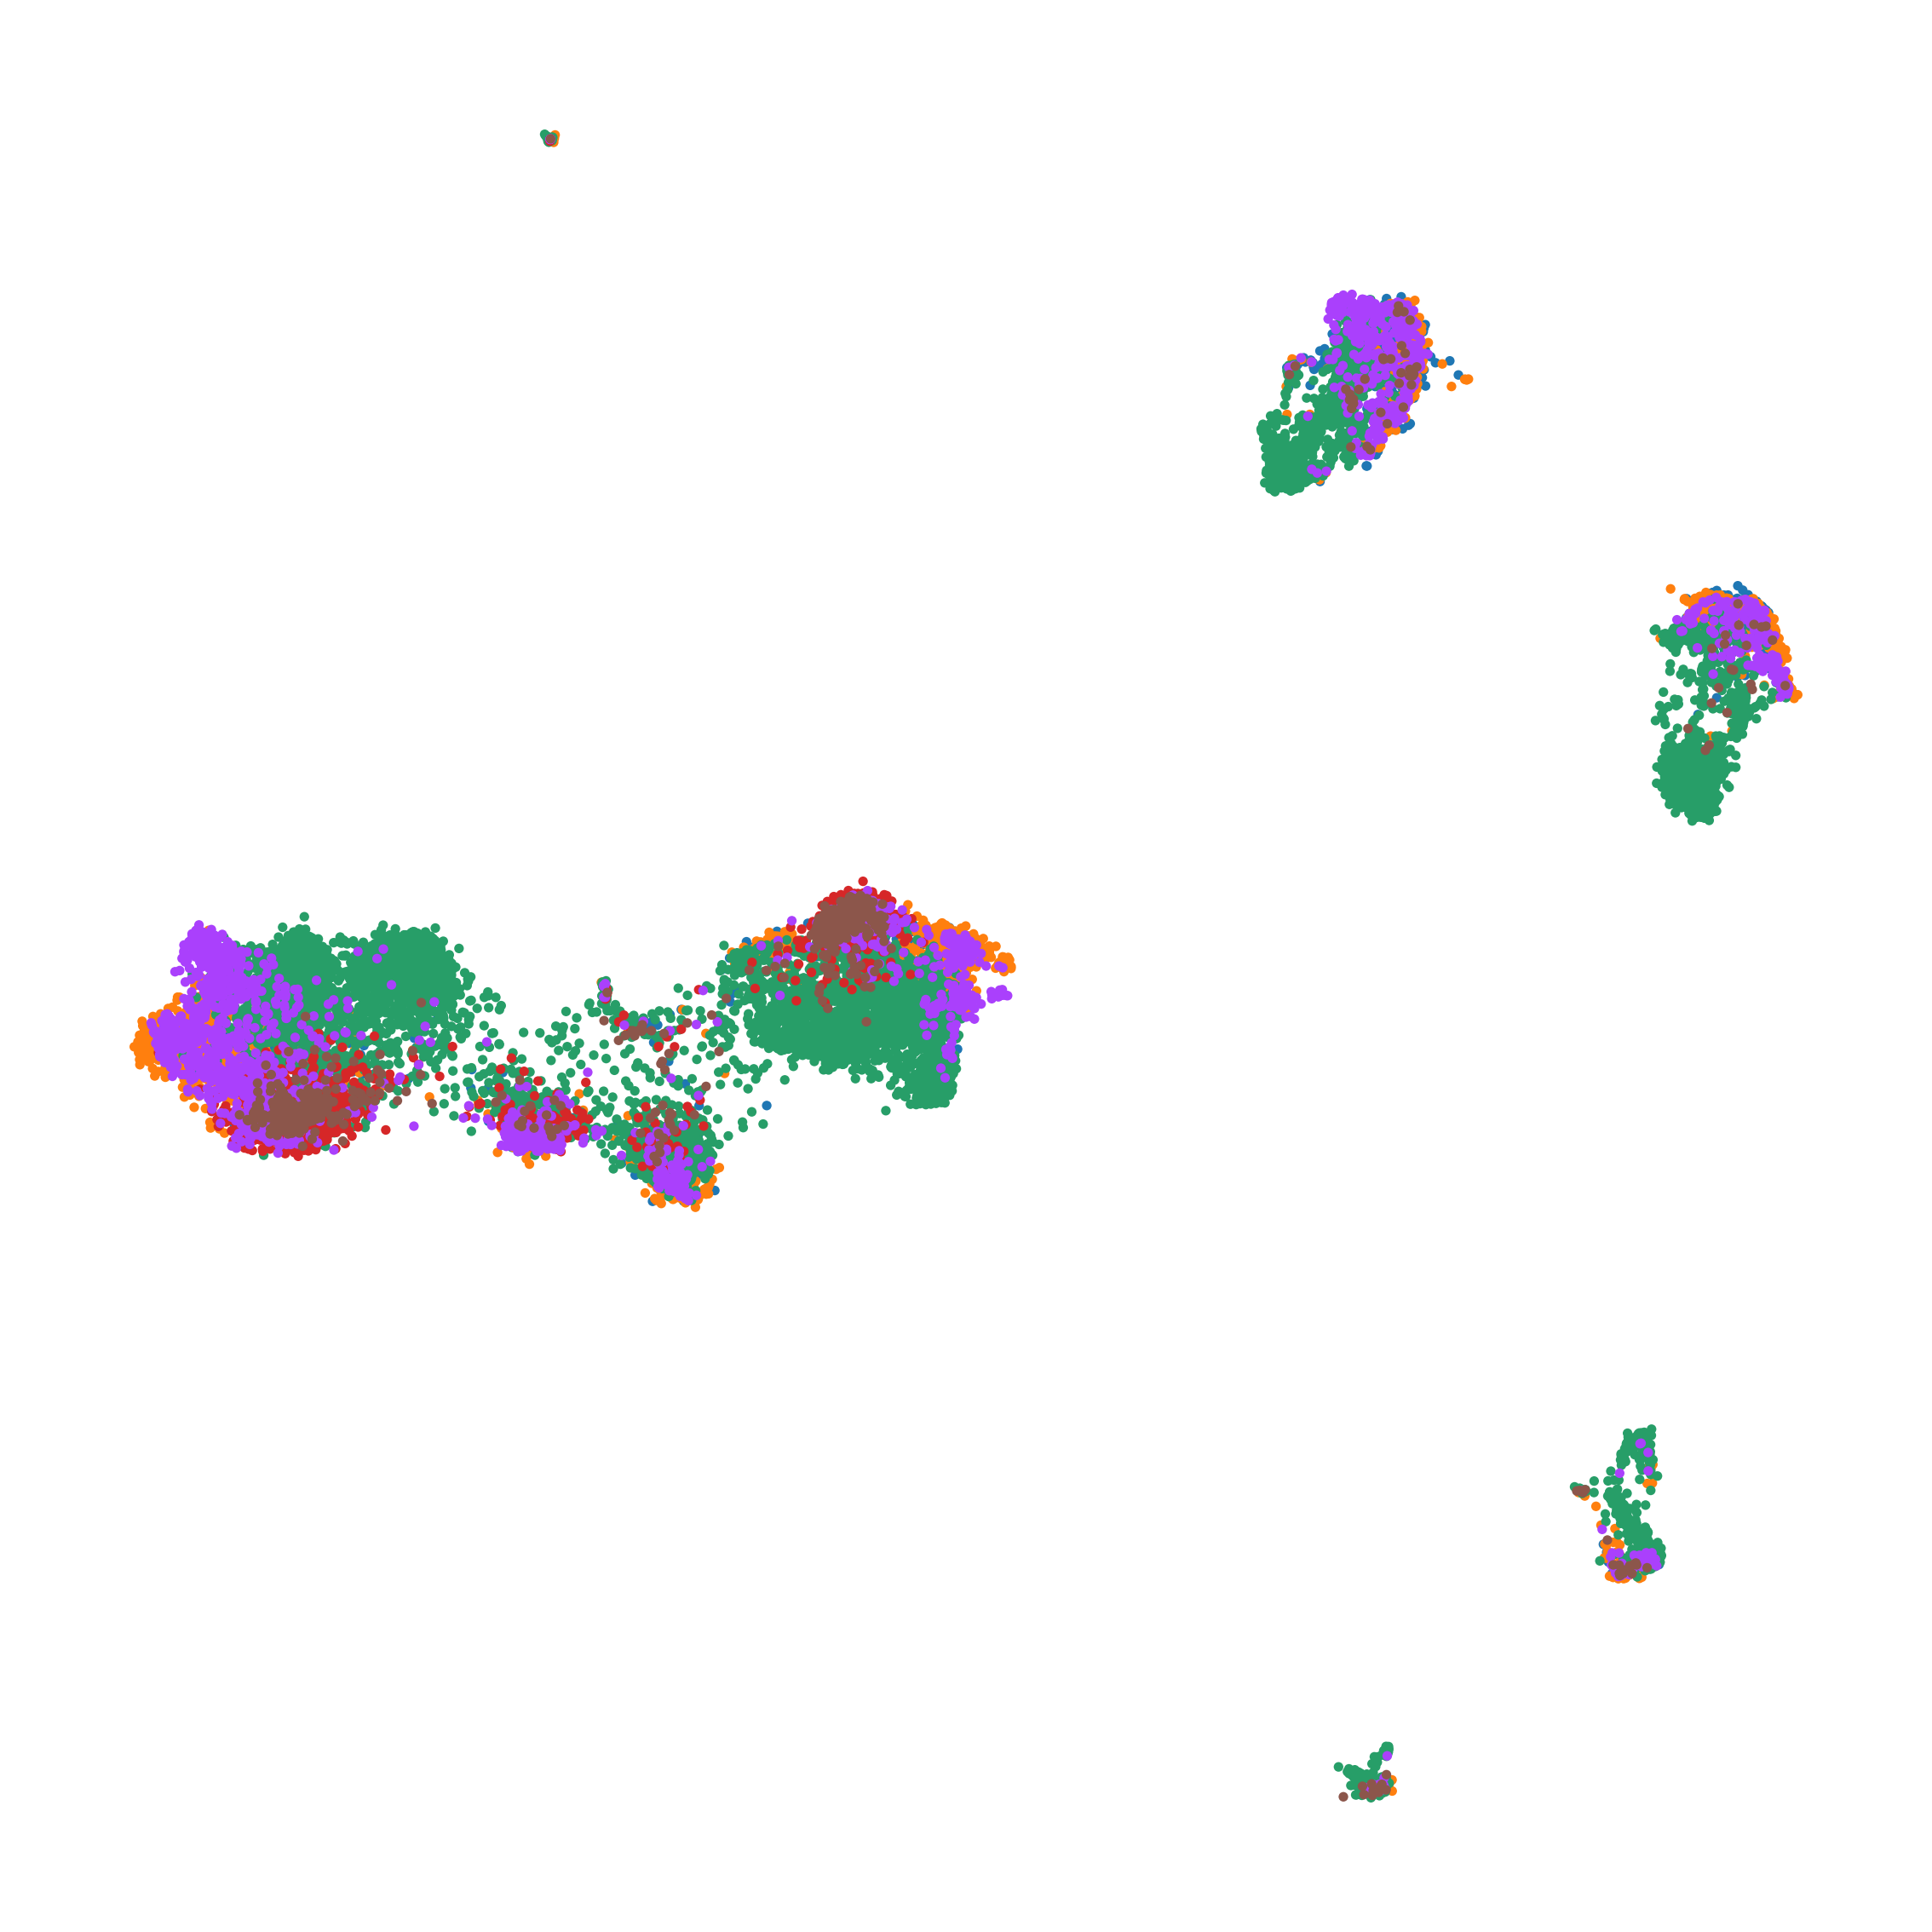

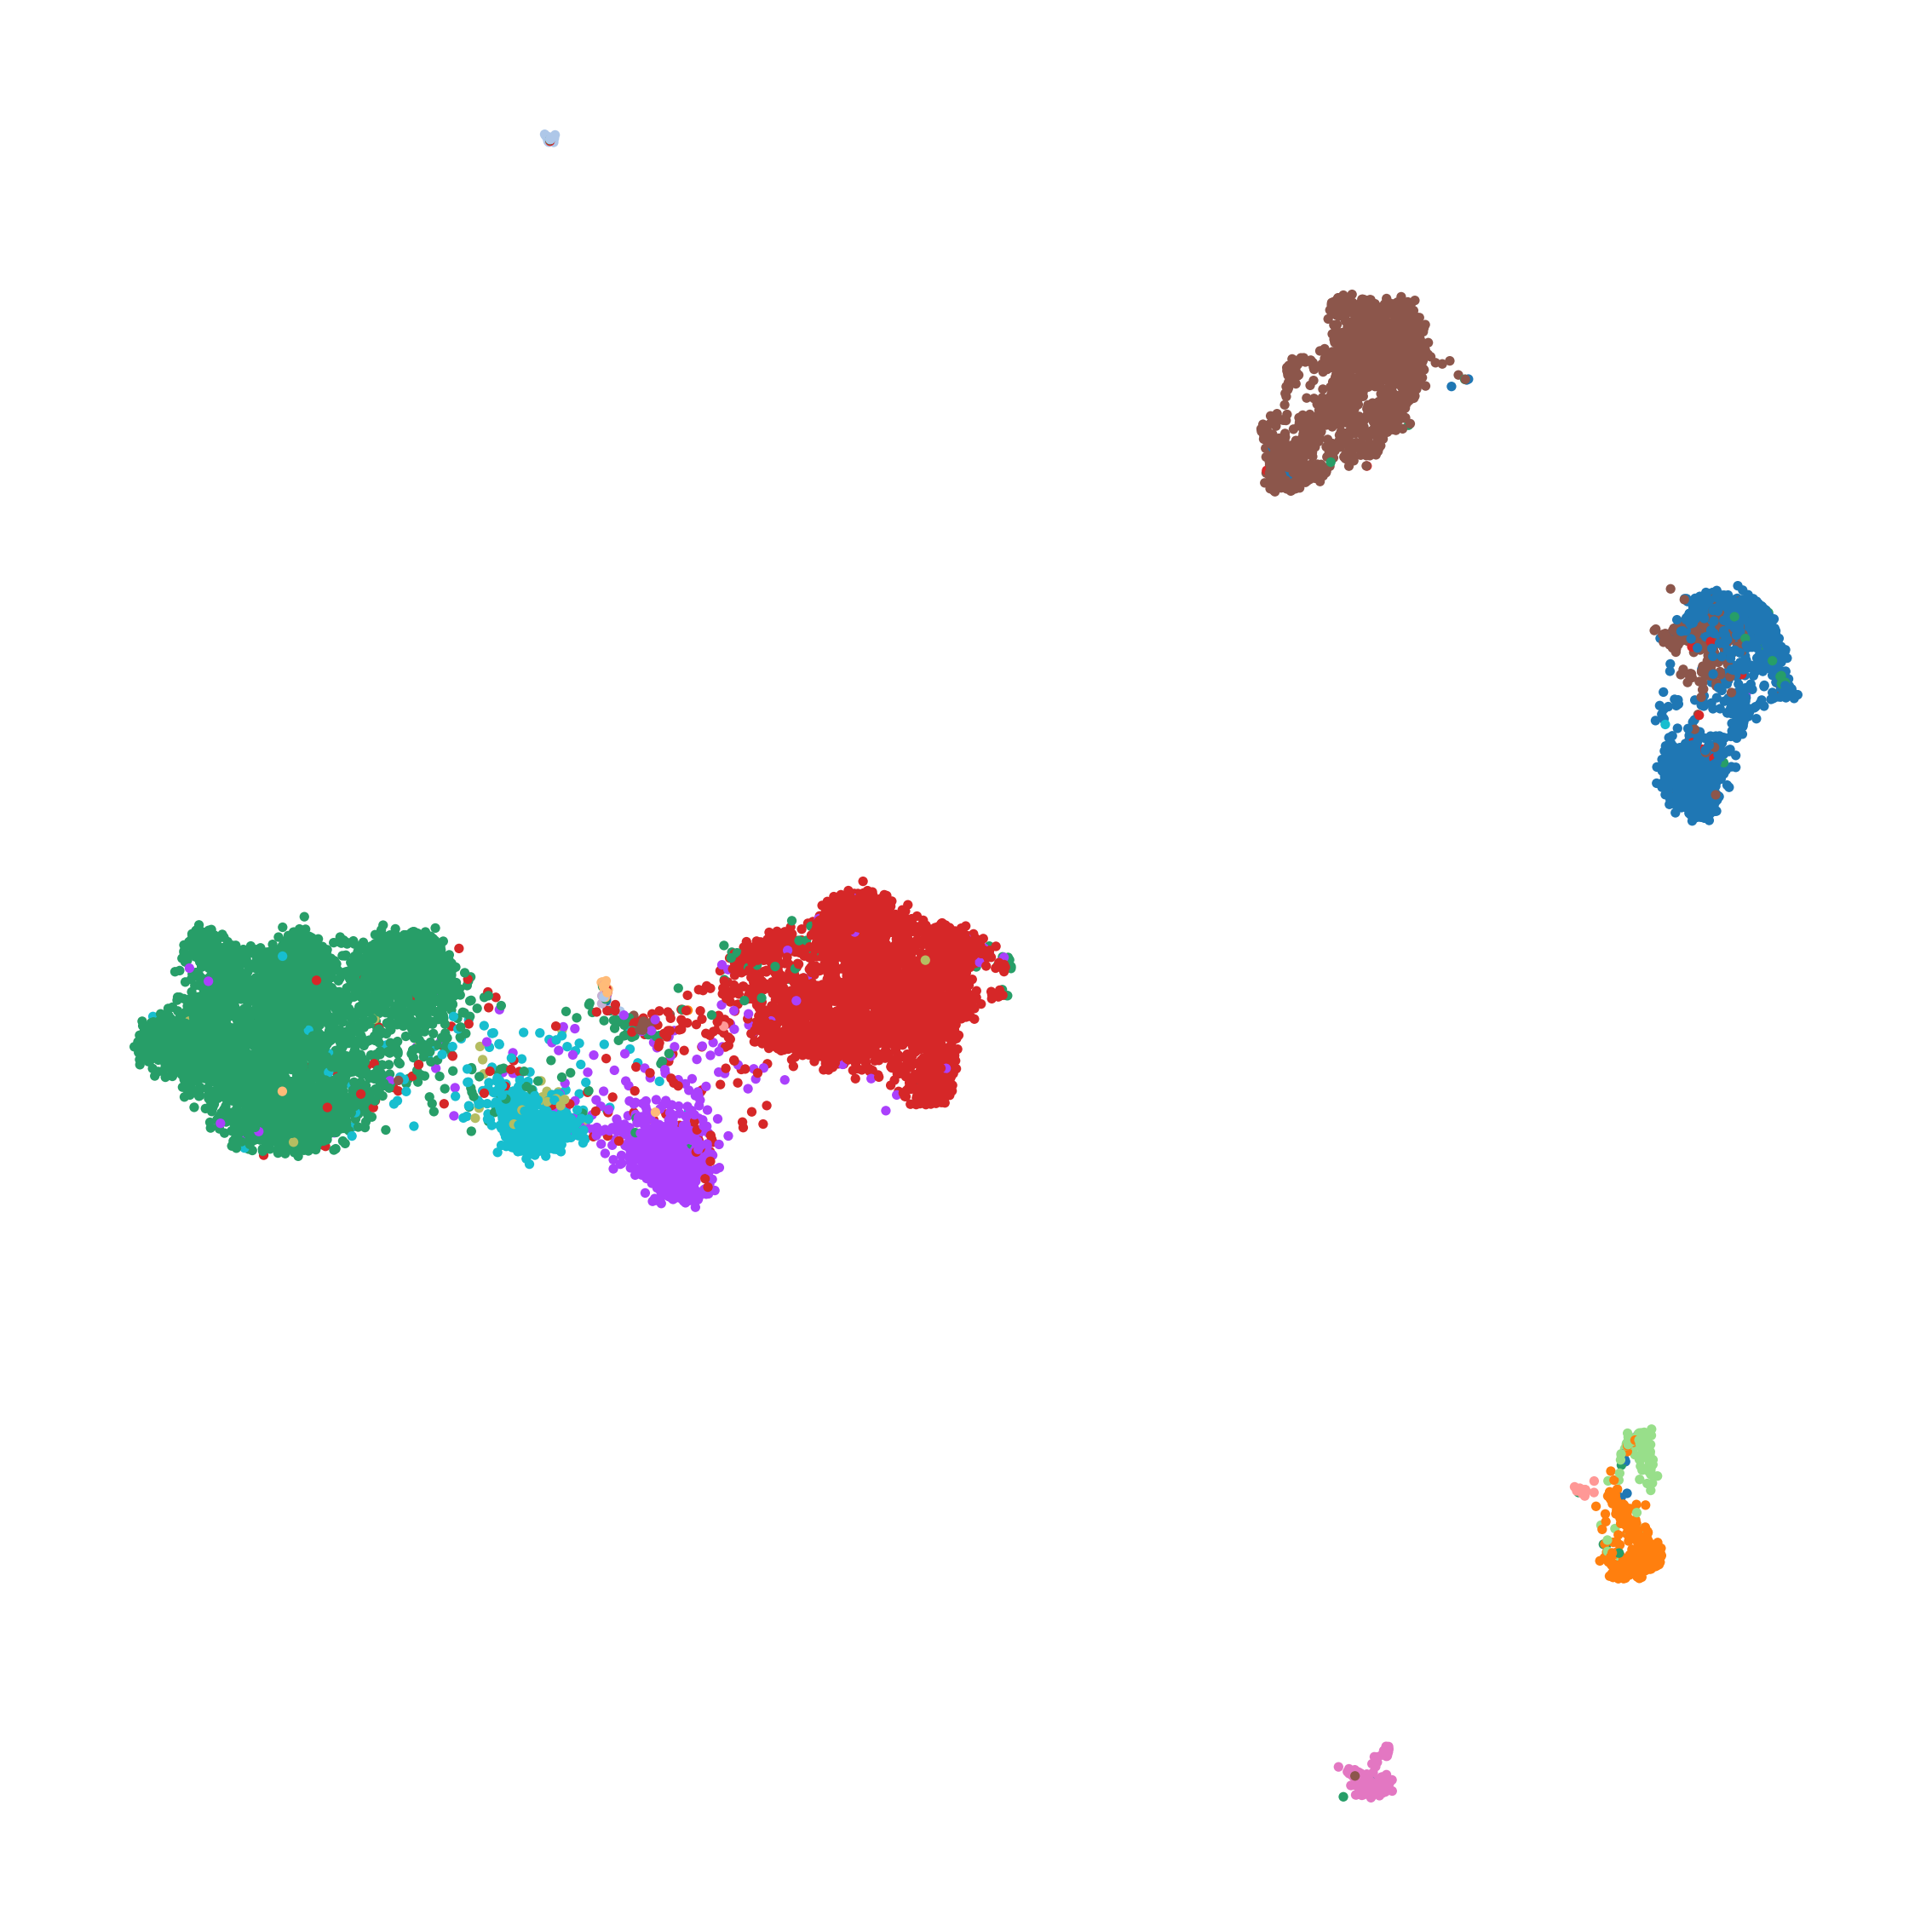

In [33]:
fig = sc.pl.umap(adata_scanorama, color=['batch', 'cell_ontology_class'])
[clear_fig(sc.pl.umap(adata_scanorama, color=c, title='', legend_loc=None, return_fig=True)).savefig(f'./{path_results}/scanorama_{c}.jpg')  for c in ['batch', 'cell_ontology_class']]

In [34]:
scanorama_bems = metrics.batch_entropy_mixing_score(adata_scanorama.obsm['X_umap'], adata_scanorama.obs['batch'])
print(scanorama_bems)
scanorama_sc = metrics.silhouette_score(adata_scanorama.obsm['X_umap'], adata_scanorama.obs['cell_ontology_class'].cat.codes)
print(scanorama_sc)

0.3406284093969048
0.49305248


In [35]:
scanorama_metrics = metrics.evaluate_all(adata_raw, adata_scanorama, 'scanorama', batch_key='batch', label_key='cell_ontology_class', cluster_nmi=None, verbose=False)
print(scanorama_metrics)

NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
                                  0
NMI_cluster/label          0.866379
ARI_cluster/label          0.910367
ASW_label                  0.530477
ASW_label/batch            0.927349
PCR_batch                  0.724811
cell_cycle_conservation         NaN
isolated_label_F1          0.099291
isolated_label_silhouette  0.592482
graph_conn                 0.981554
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN


In [36]:
scanorama_metrics.to_csv(f'{path_results}/metrics_scanorama.csv', index=True, header=True)

# bbknn

In [37]:
from scCorrect.baseline import bbknn_integrate
adata_bbknn = bbknn_integrate(adata_raw)
# sc.pp.neighbors(adata_bbknn, use_rep='X_emb', n_neighbors=30)
sc.tl.umap(adata_bbknn, min_dist=0.1)

[None, None]

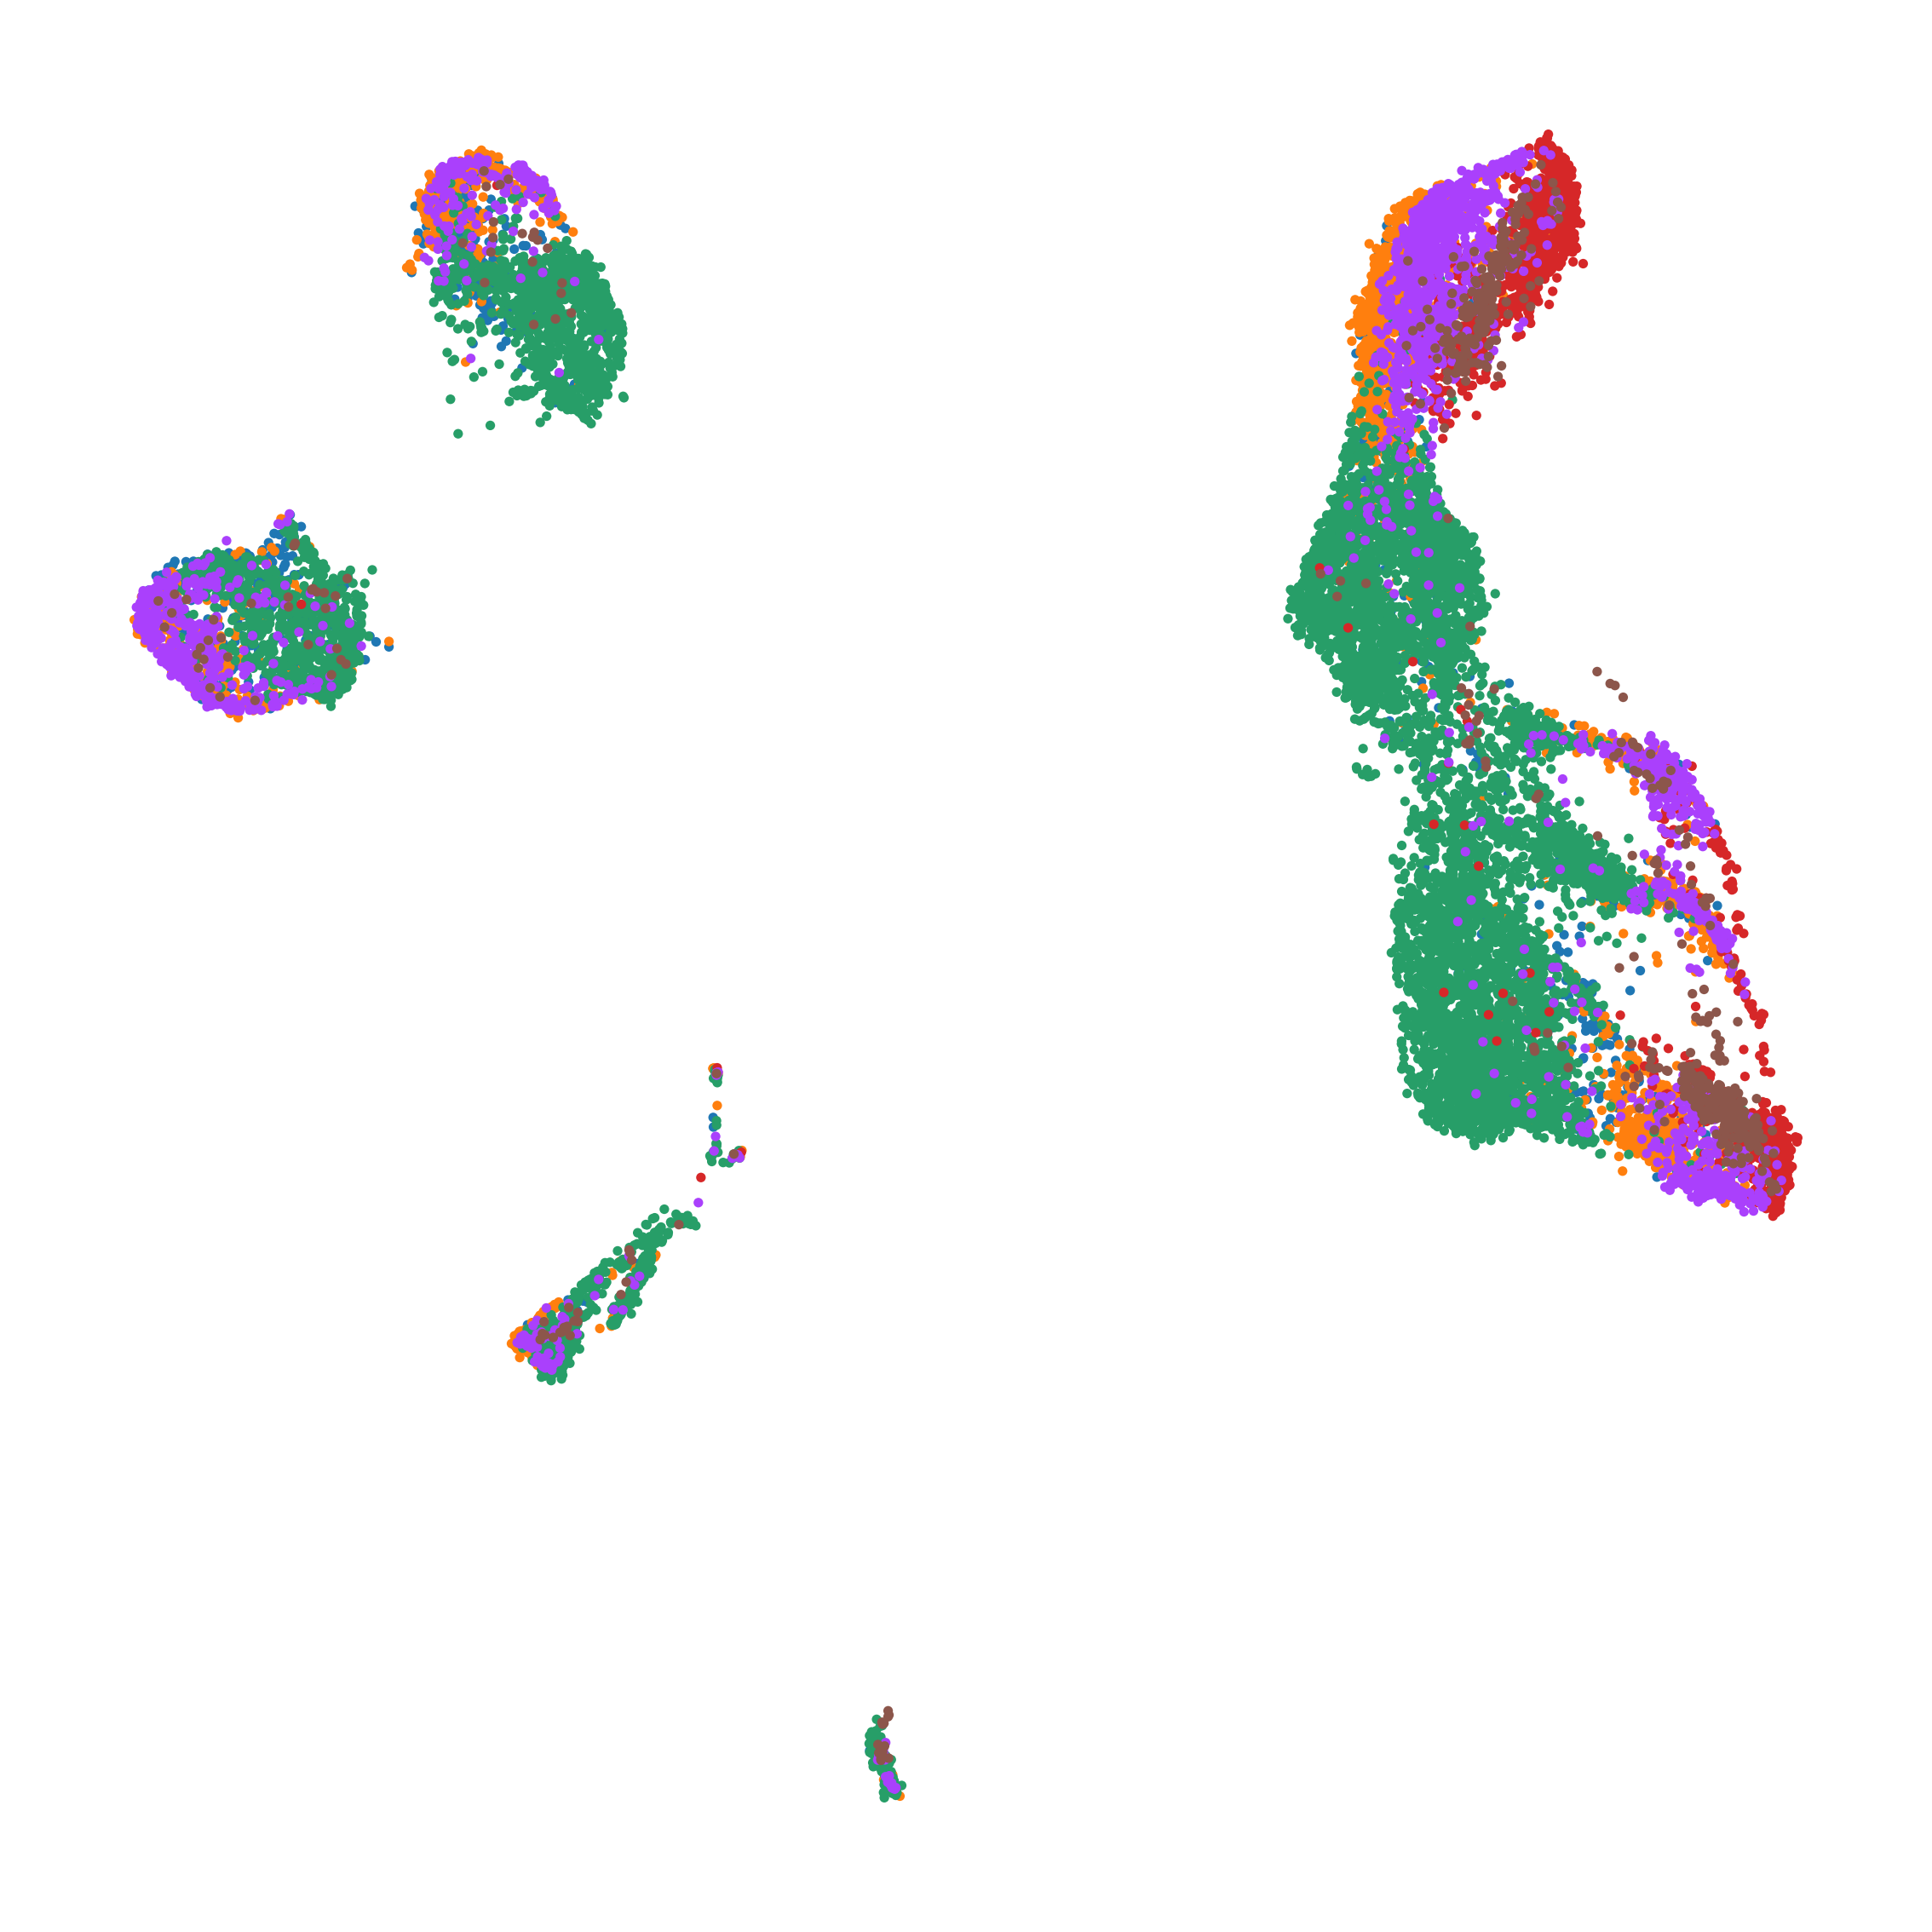

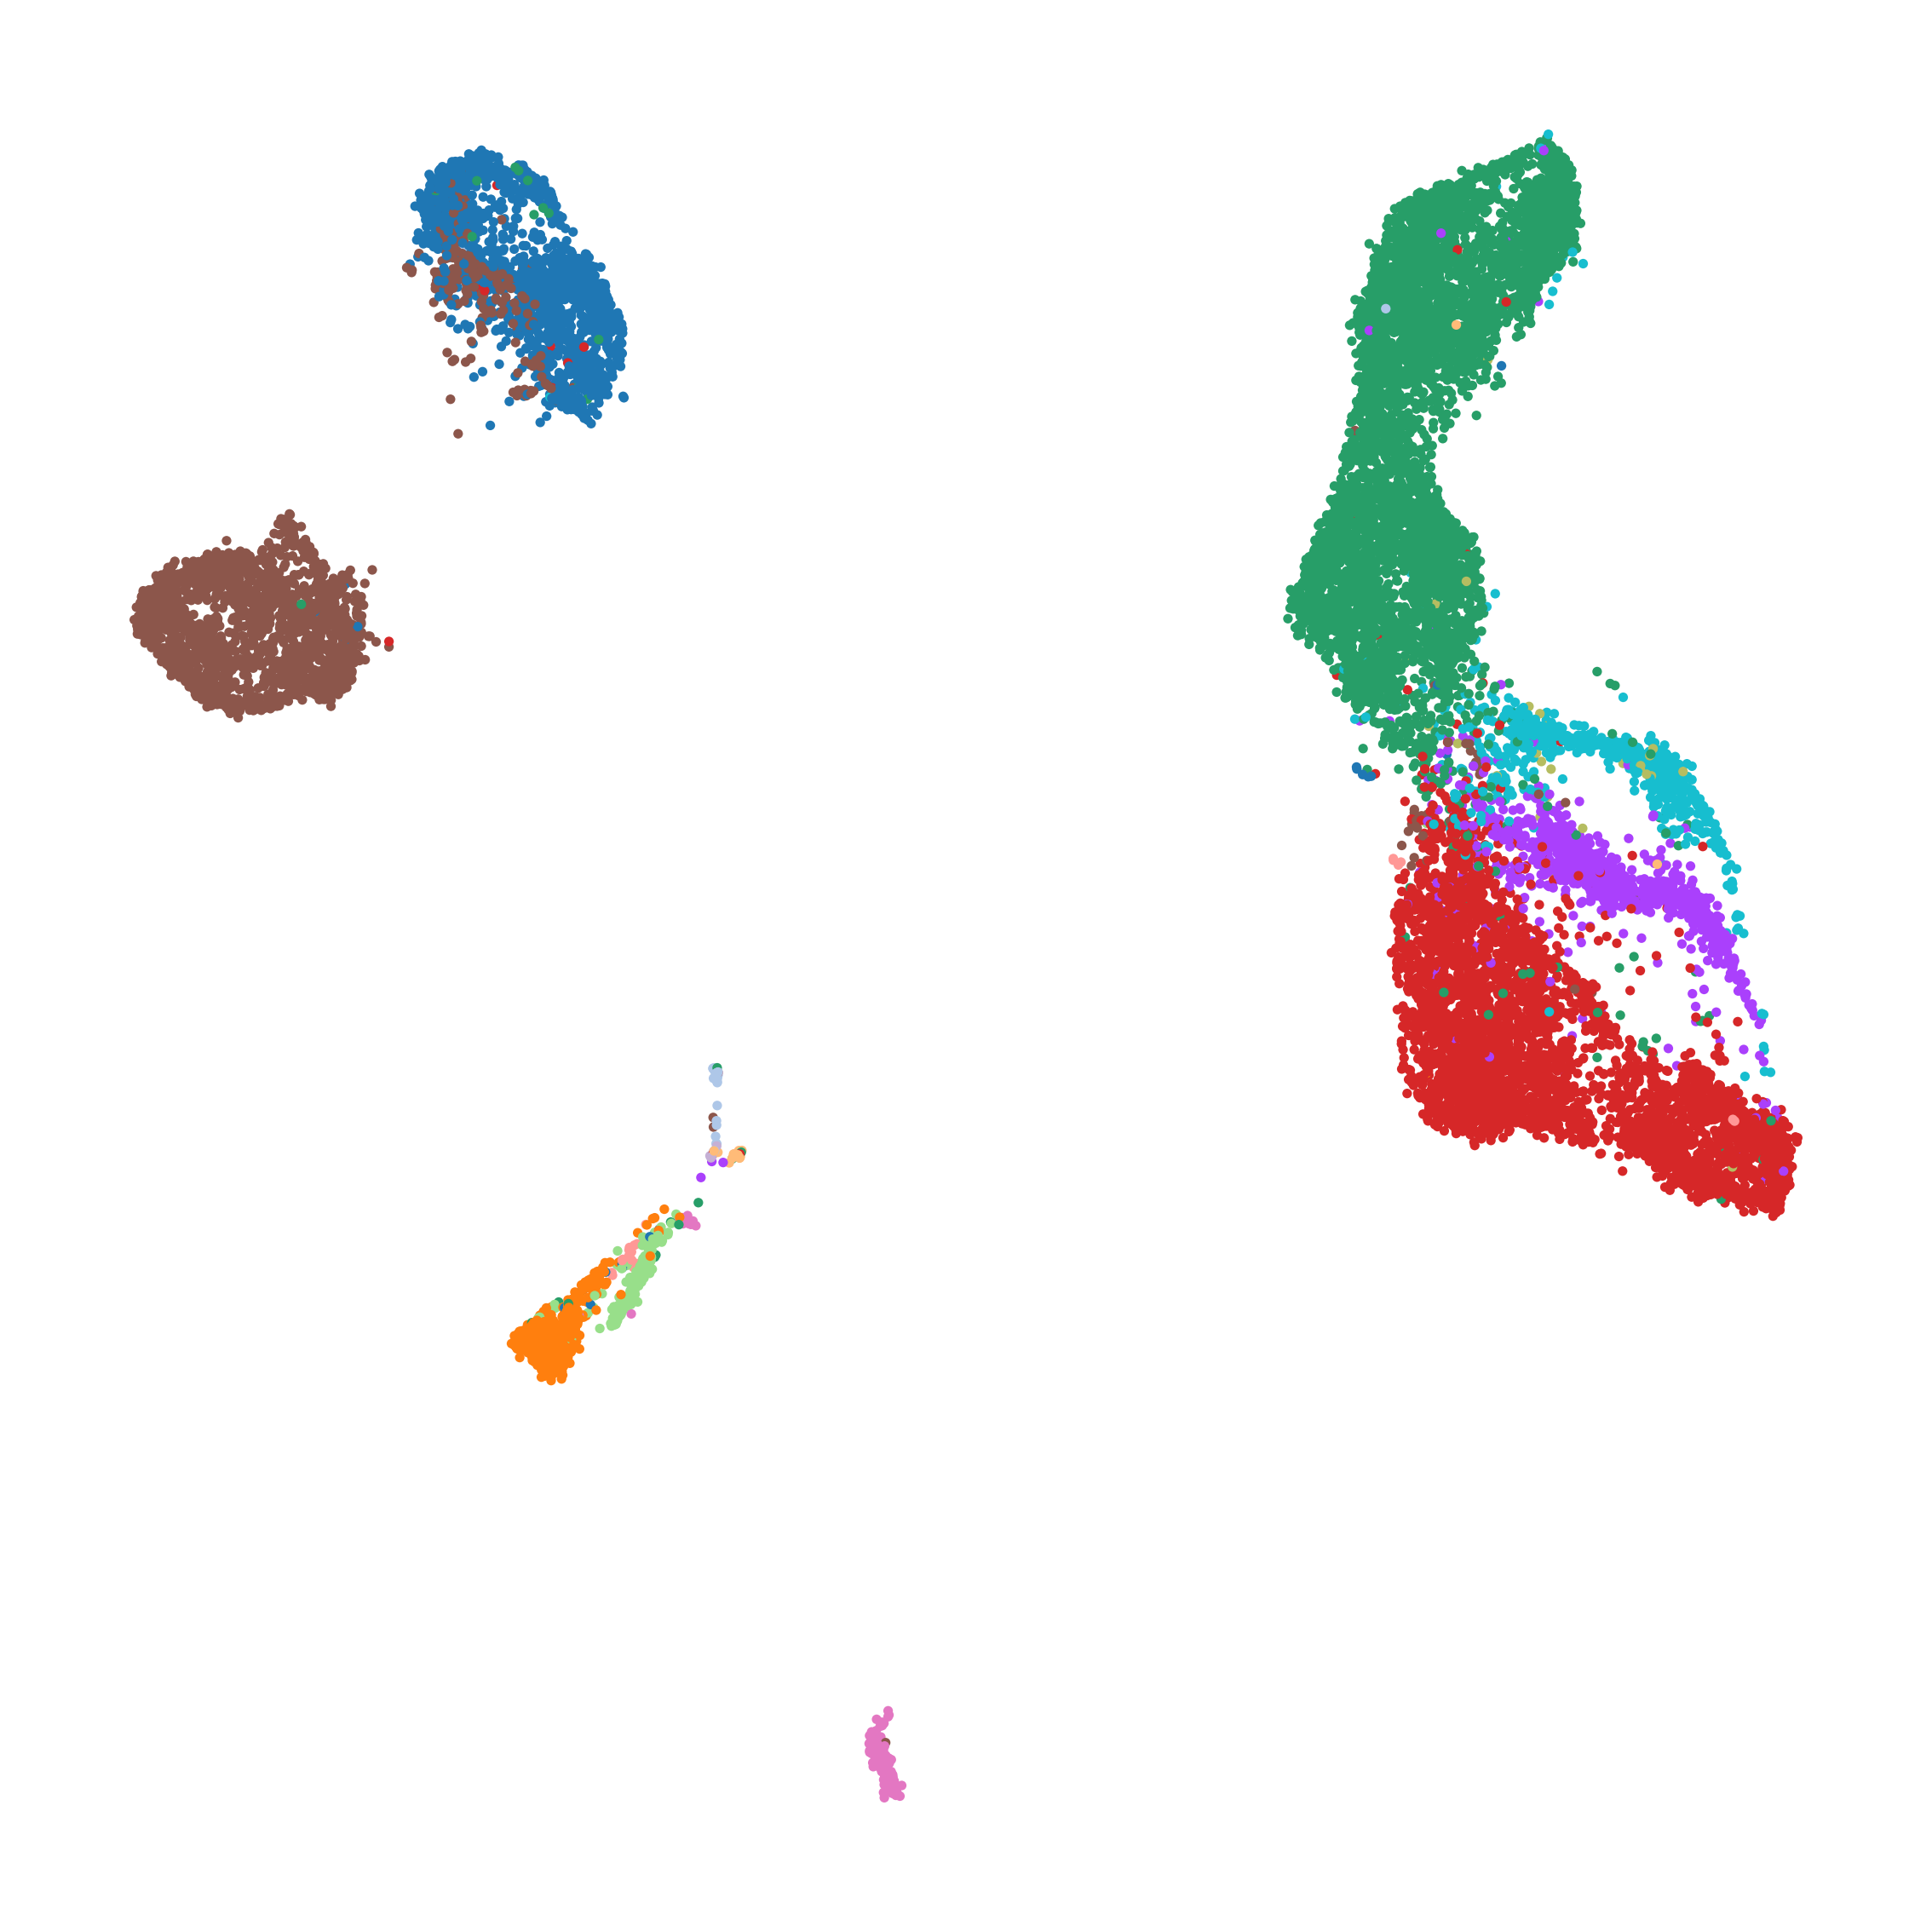

In [38]:
[clear_fig(sc.pl.umap(adata_bbknn, color=c, title='', legend_loc=None, return_fig=True)).savefig(f'./{path_results}/bbknn_{c}.jpg')  for c in ['batch', 'cell_ontology_class']]

In [39]:
bbknn_bems = metrics.batch_entropy_mixing_score(adata_bbknn.obsm['X_umap'], adata_bbknn.obs['batch'])
print(bbknn_bems)
bbknn_sc = metrics.silhouette_score(adata_bbknn.obsm['X_umap'], adata_bbknn.obs['cell_ontology_class'].cat.codes)
print(bbknn_sc)

0.34979484700222596
0.34400257


In [40]:
bbknn_metrics = metrics.evaluate_all(adata_raw, adata_bbknn, 'bbknn', batch_key='batch', label_key='cell_ontology_class', cluster_nmi=None, verbose=False)
print(bbknn_metrics)

C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_pca
Isolated labels ASW...
Graph connectivity...
                                  0
NMI_cluster/label          0.768630
ARI_cluster/label          0.759191
ASW_label                  0.520263
ASW_label/batch            0.818647
PCR_batch                  0.000000
cell_cycle_conservation         NaN
isolated_label_F1          0.102941
isolated_label_silhouette  0.734108
graph_conn                 0.941392
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN


In [41]:
bbknn_metrics.to_csv(f'{path_results}/bbknn_metrics.csv', index=True, header=True)

# harmony

In [42]:
from scCorrect.baseline import harmony_integrate
adata_harmony = harmony_integrate(adata_raw)
sc.pp.neighbors(adata_harmony, use_rep='X_emb', n_neighbors=30)
sc.tl.umap(adata_harmony, min_dist=0.1)


2023-08-17 15:49:52,950 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-17 15:49:52,950 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-08-17 15:49:56,712 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-17 15:49:56,712 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-08-17 15:49:56,811 - harmonypy - INFO - Iteration 1 of 10
2023-08-17 15:49:56,811 - harmonypy - INFO - Iteration 1 of 10
2023-08-17 15:50:00,791 - harmonypy - INFO - Iteration 2 of 10
2023-08-17 15:50:00,791 - harmonypy - INFO - Iteration 2 of 10
2023-08-17 15:50:04,777 - harmonypy - INFO - Converged after 2 iterations
2023-08-17 15:50:04,777 - harmonypy - INFO - Converged after 2 iterations


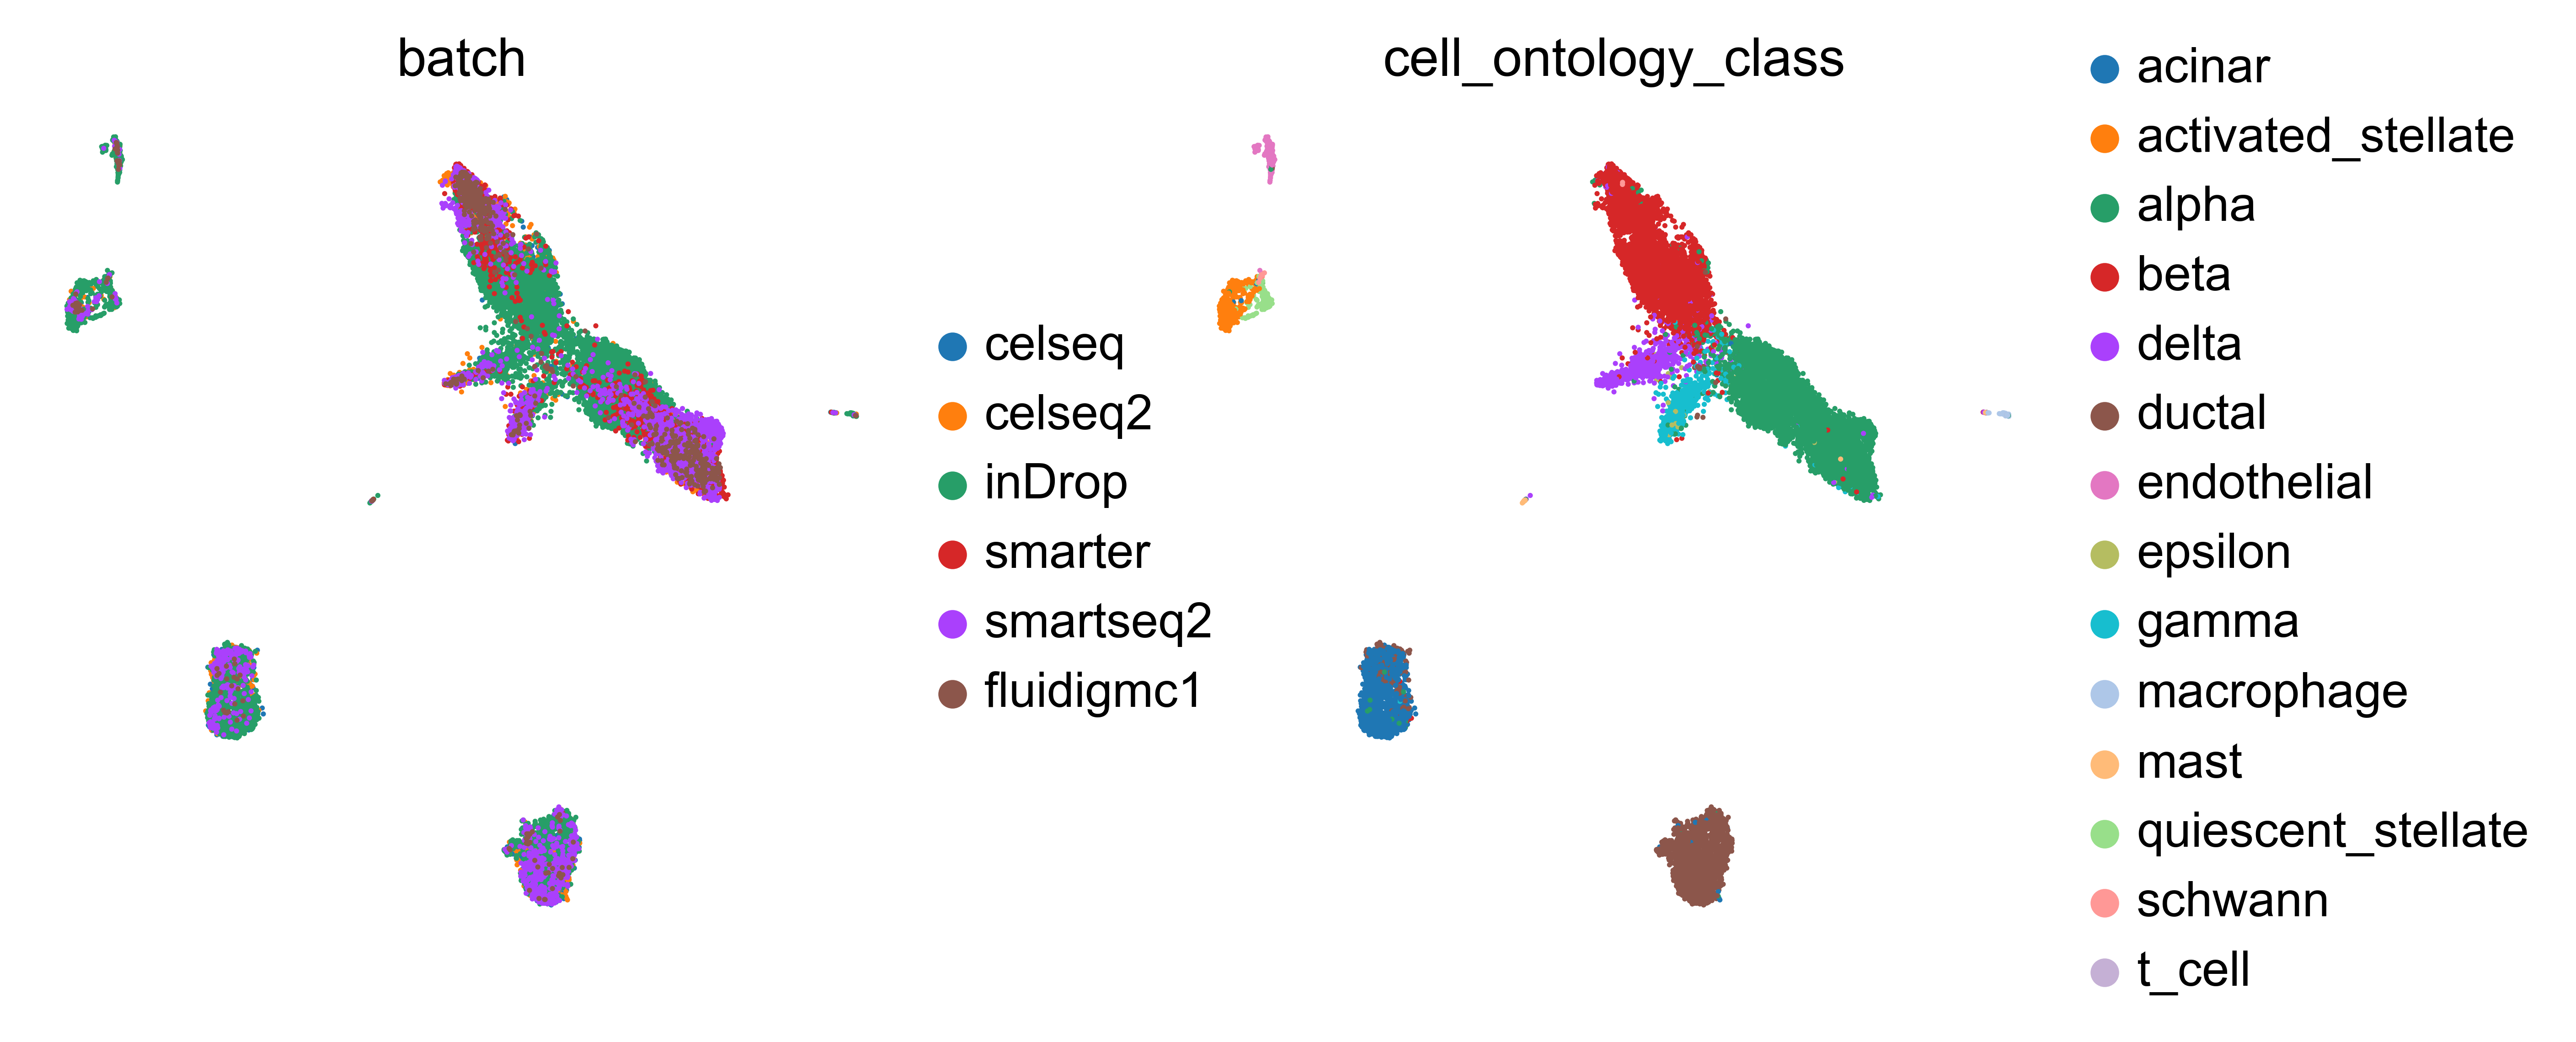

[None, None]

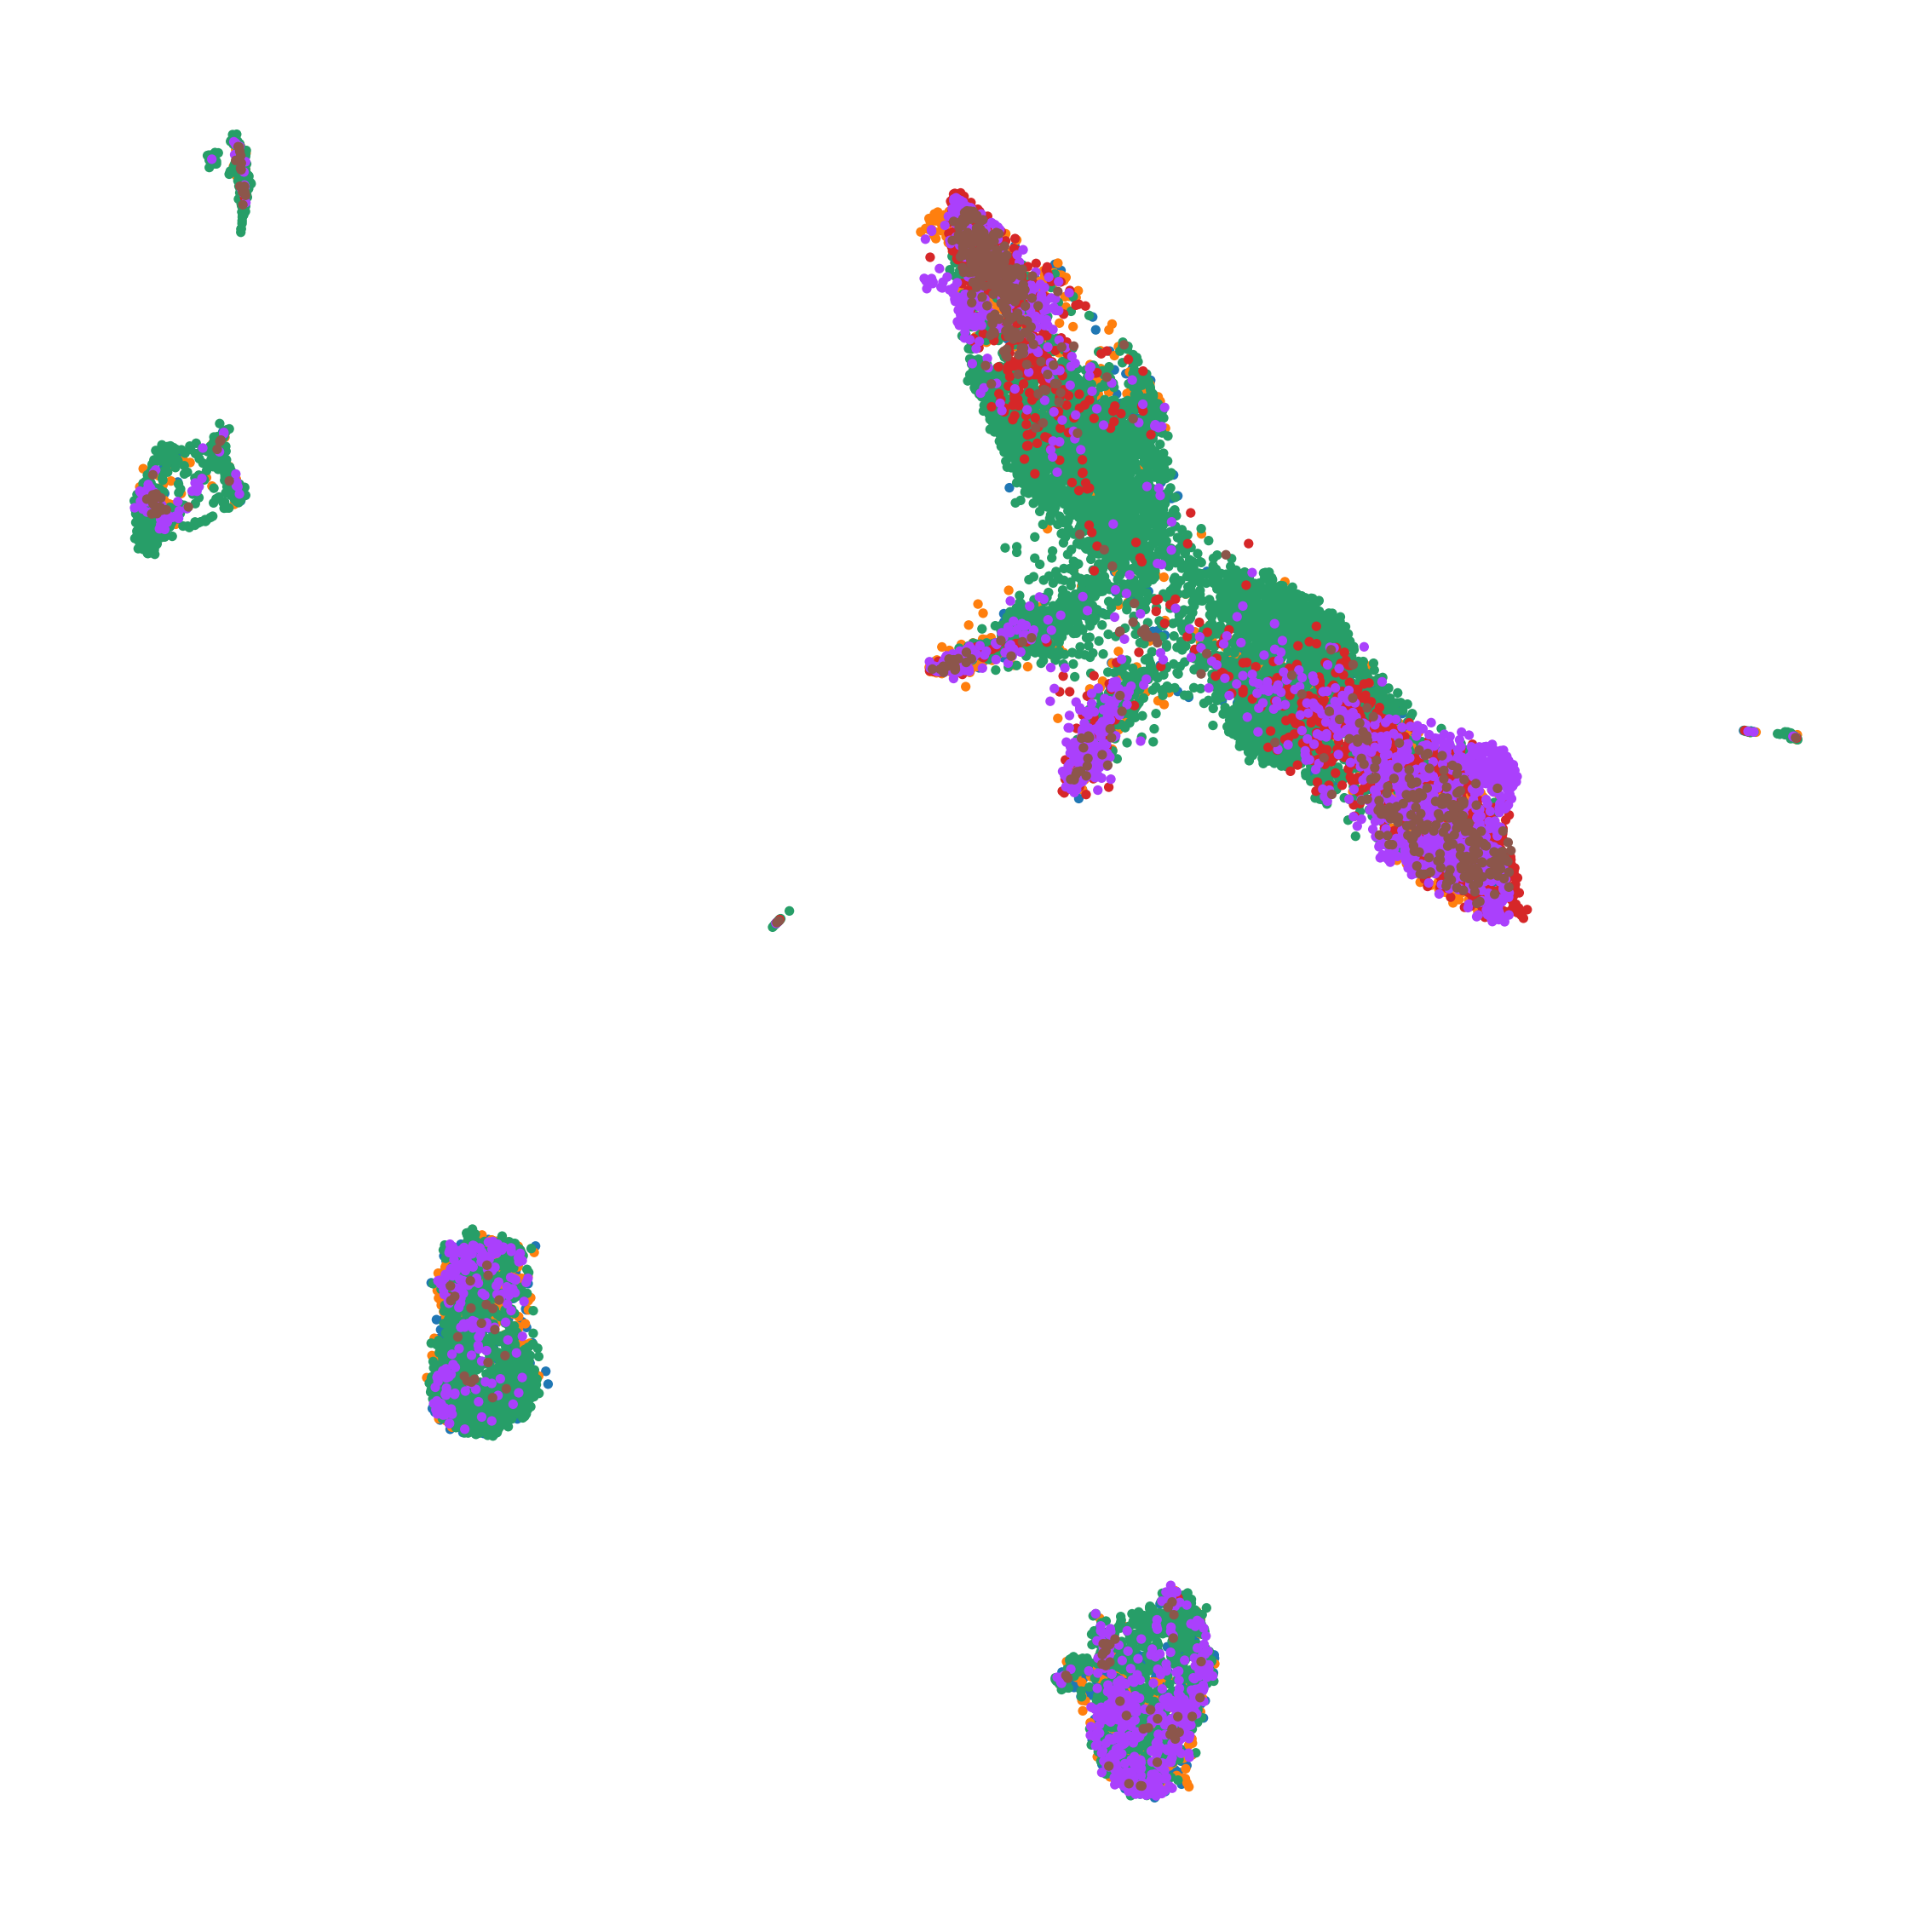

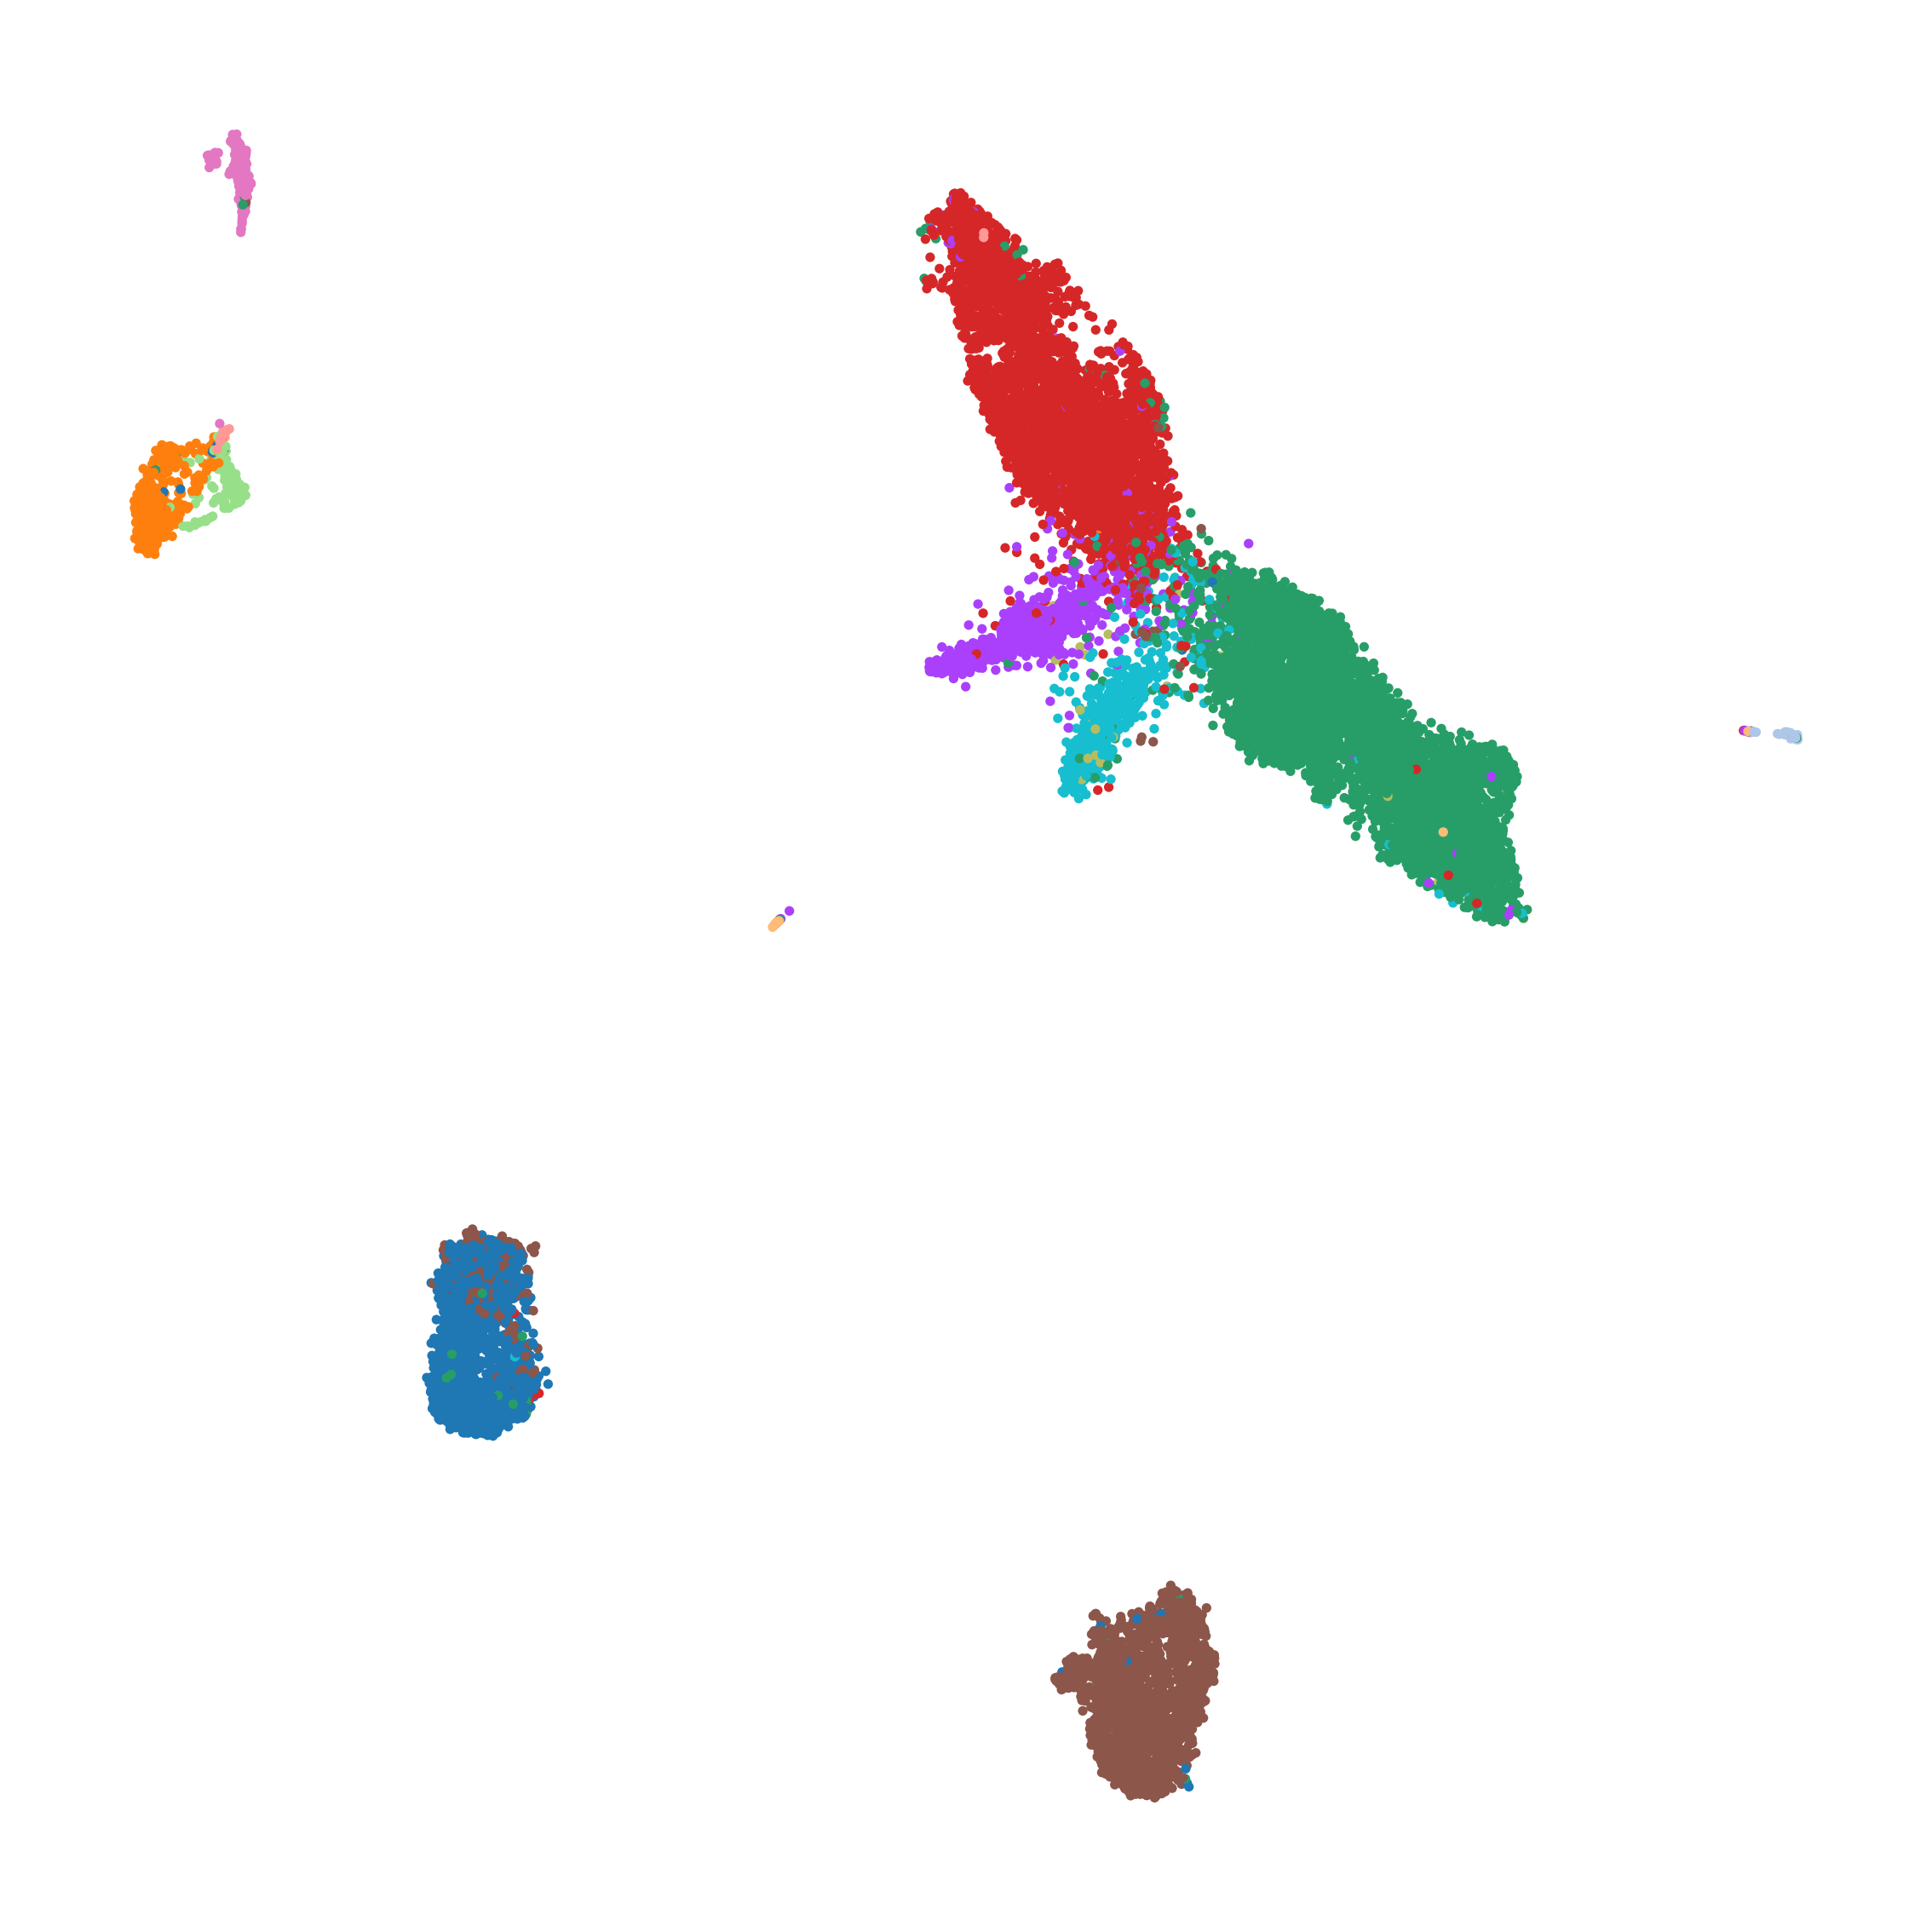

In [43]:
fig = sc.pl.umap(adata_harmony, color=['batch', 'cell_ontology_class'])
[clear_fig(sc.pl.umap(adata_harmony, color=c, title='', legend_loc=None, return_fig=True)).savefig(f'./{path_results}/harmony_{c}.jpg')  for c in ['batch', 'cell_ontology_class']]

In [44]:
harmony_bems = metrics.batch_entropy_mixing_score(adata_harmony.obsm['X_umap'], adata_harmony.obs['batch'])
print(harmony_bems)
harmony_sc = metrics.silhouette_score(adata_harmony.obsm['X_umap'], adata_harmony.obs['cell_ontology_class'].cat.codes)
print(harmony_sc)

0.5030130573826105
0.445505


In [45]:
harmony_metrics = metrics.evaluate_all(adata_raw, adata_harmony, 'scalex', batch_key='batch', label_key='cell_ontology_class', cluster_nmi=None, verbose=False)
print(harmony_metrics)


C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
                                  0
NMI_cluster/label          0.842573
ARI_cluster/label          0.893868
ASW_label                  0.550731
ASW_label/batch            0.899589
PCR_batch                  0.822161
cell_cycle_conservation         NaN
isolated_label_F1          0.096552
isolated_label_silhouette  0.688614
graph_conn                 0.976636
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN


In [46]:
harmony_metrics.to_csv(f'{path_results}/harmony_metrics.csv', index=True, header=True)

# scvi

In [47]:
from scCorrect.baseline import scvi_integrate
adata_scvi = scvi_integrate(adata_raw)
sc.pp.neighbors(adata_scvi, use_rep='X_emb', n_neighbors=30)
sc.tl.umap(adata_scvi, min_dist=0.1)

C:\Users\10360\anaconda3\envs\py39\lib\site-packages\lightning\fabric\__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
C:\Users\10360\anaconda3\envs\py39\lib\site-packages\pkg_resources\__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
C:\Users\10360\anaconda3\envs\py39\lib\site-packages\torchmetrics\utilities\imports.py:24: DeprecationWarning: distutils Version classes are

Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it, v_num=1, train_loss_step=936, train_loss_epoch=923]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
2023-08-17 15:54:33,627 - lightning.pytorch.utilities.rank_zero - INFO - `Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it, v_num=1, train_loss_step=936, train_loss_epoch=923]


[None, None]

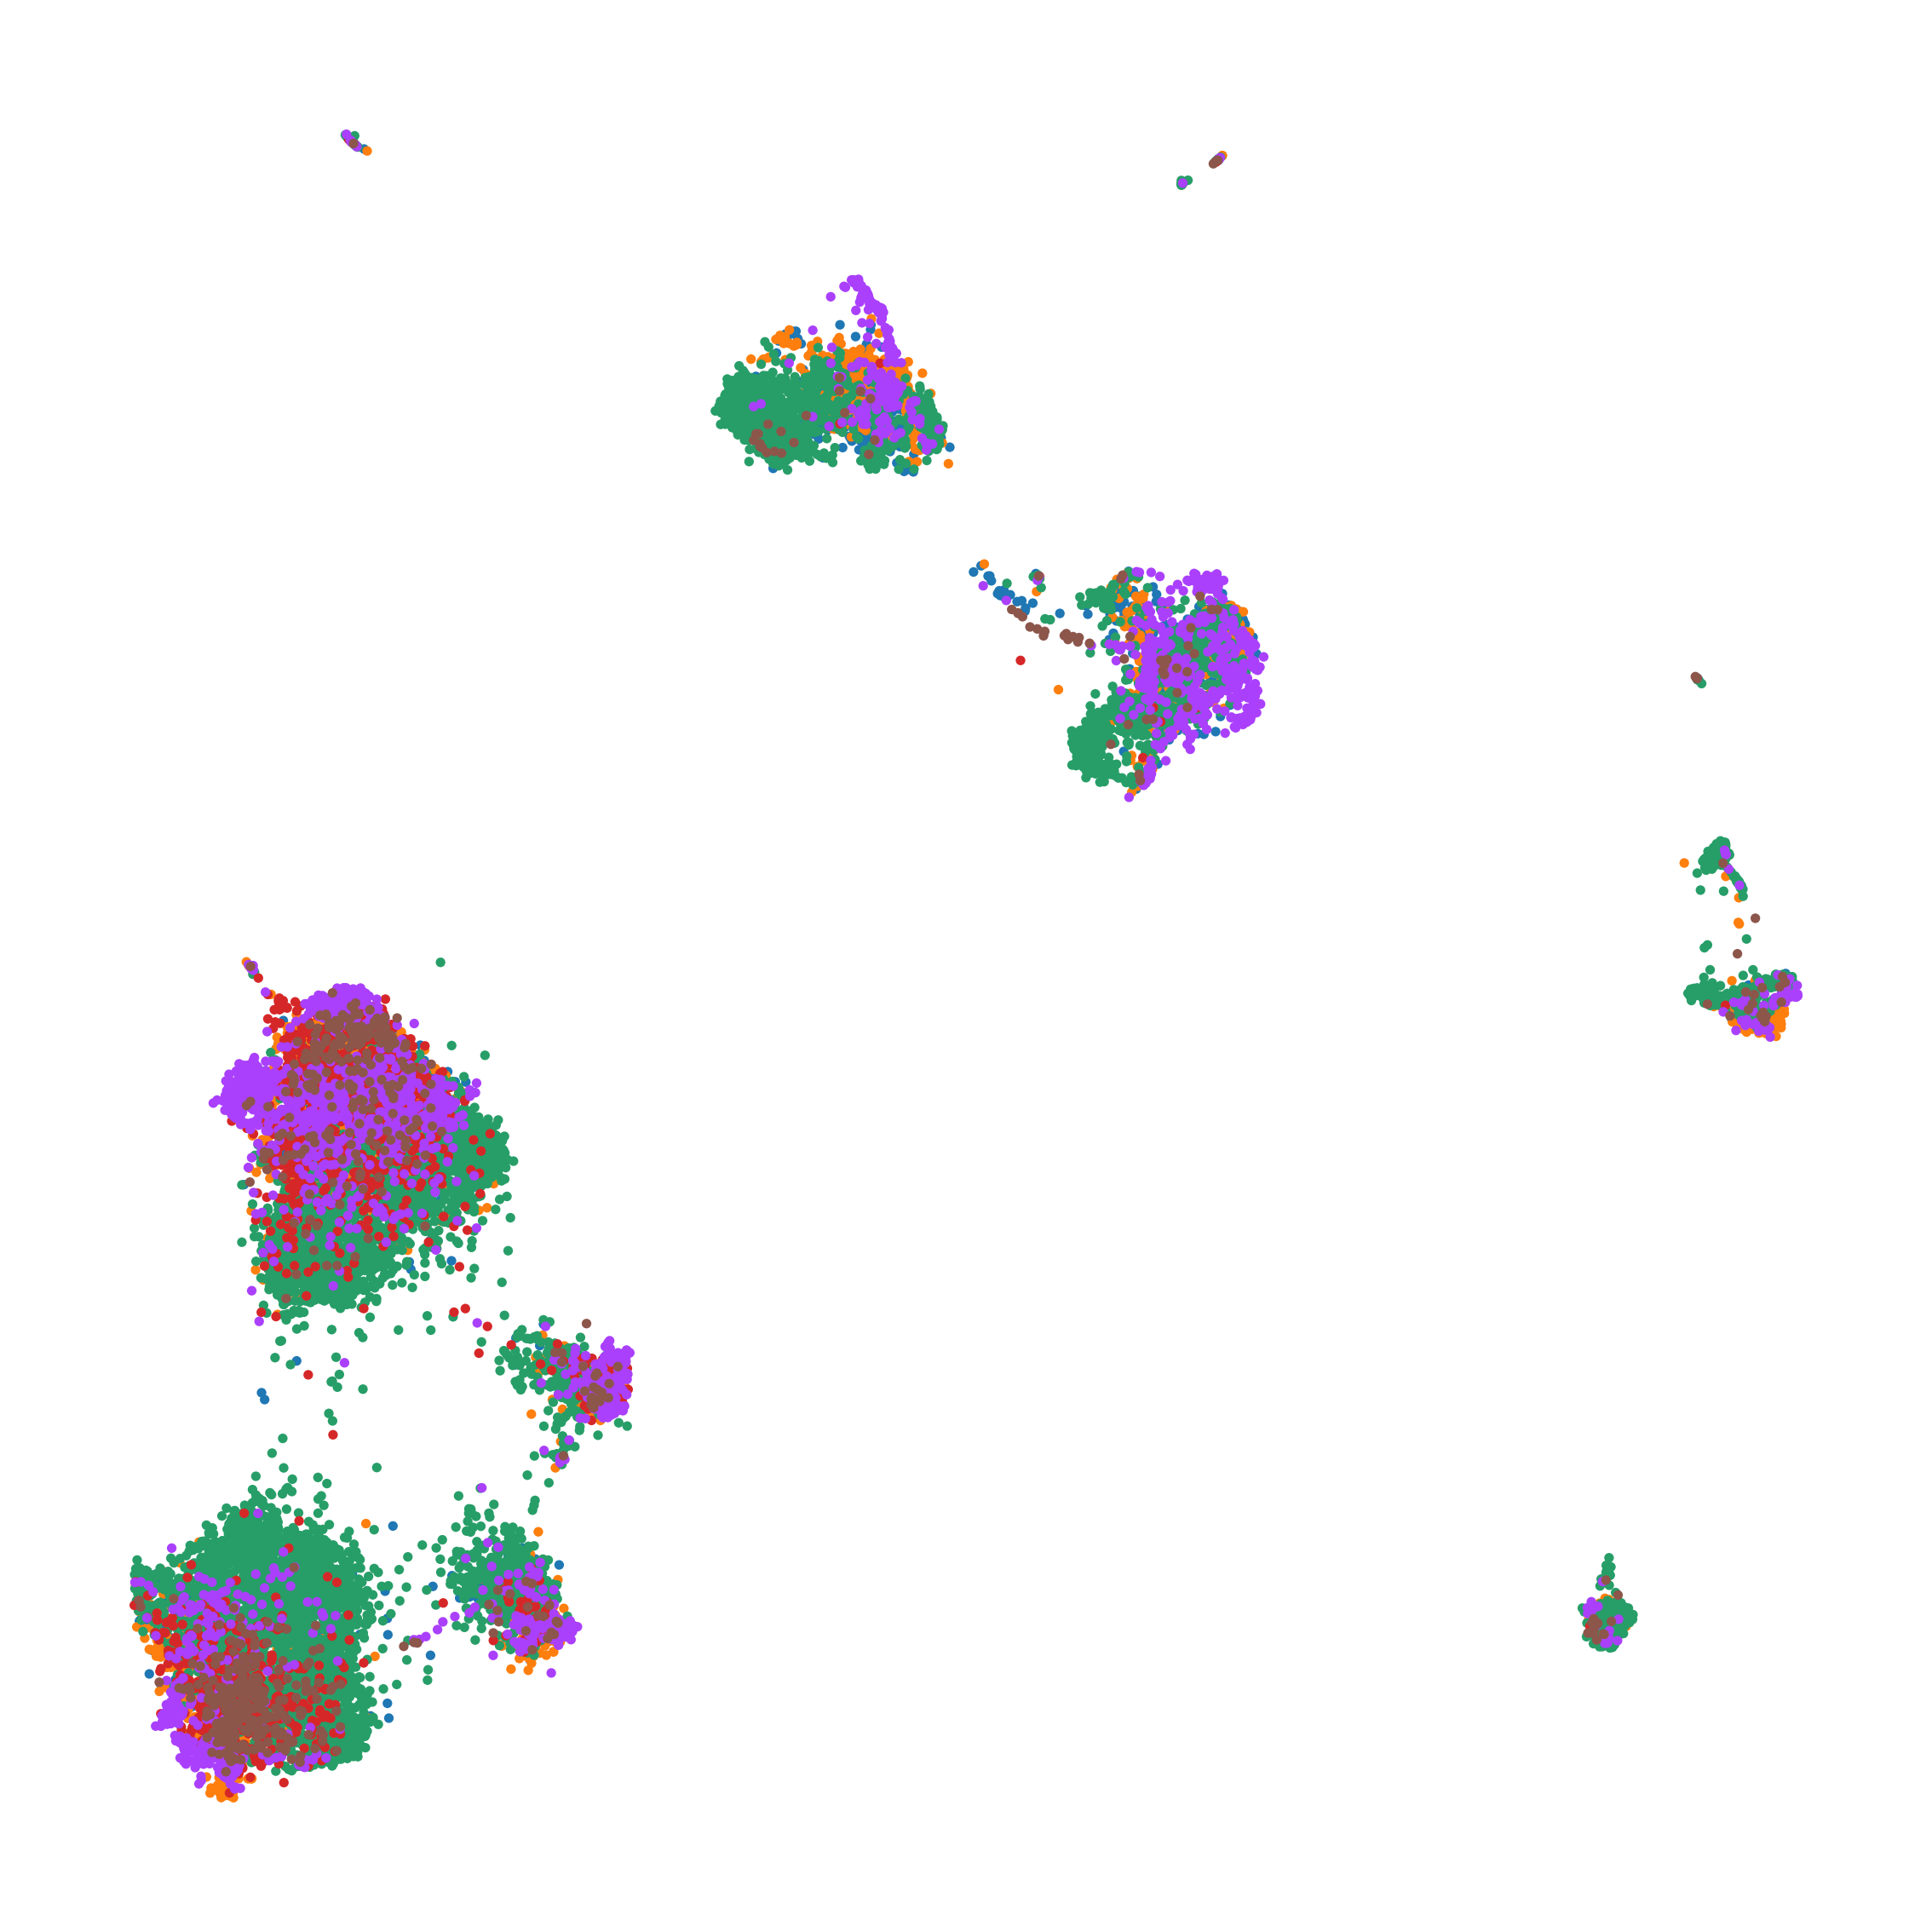

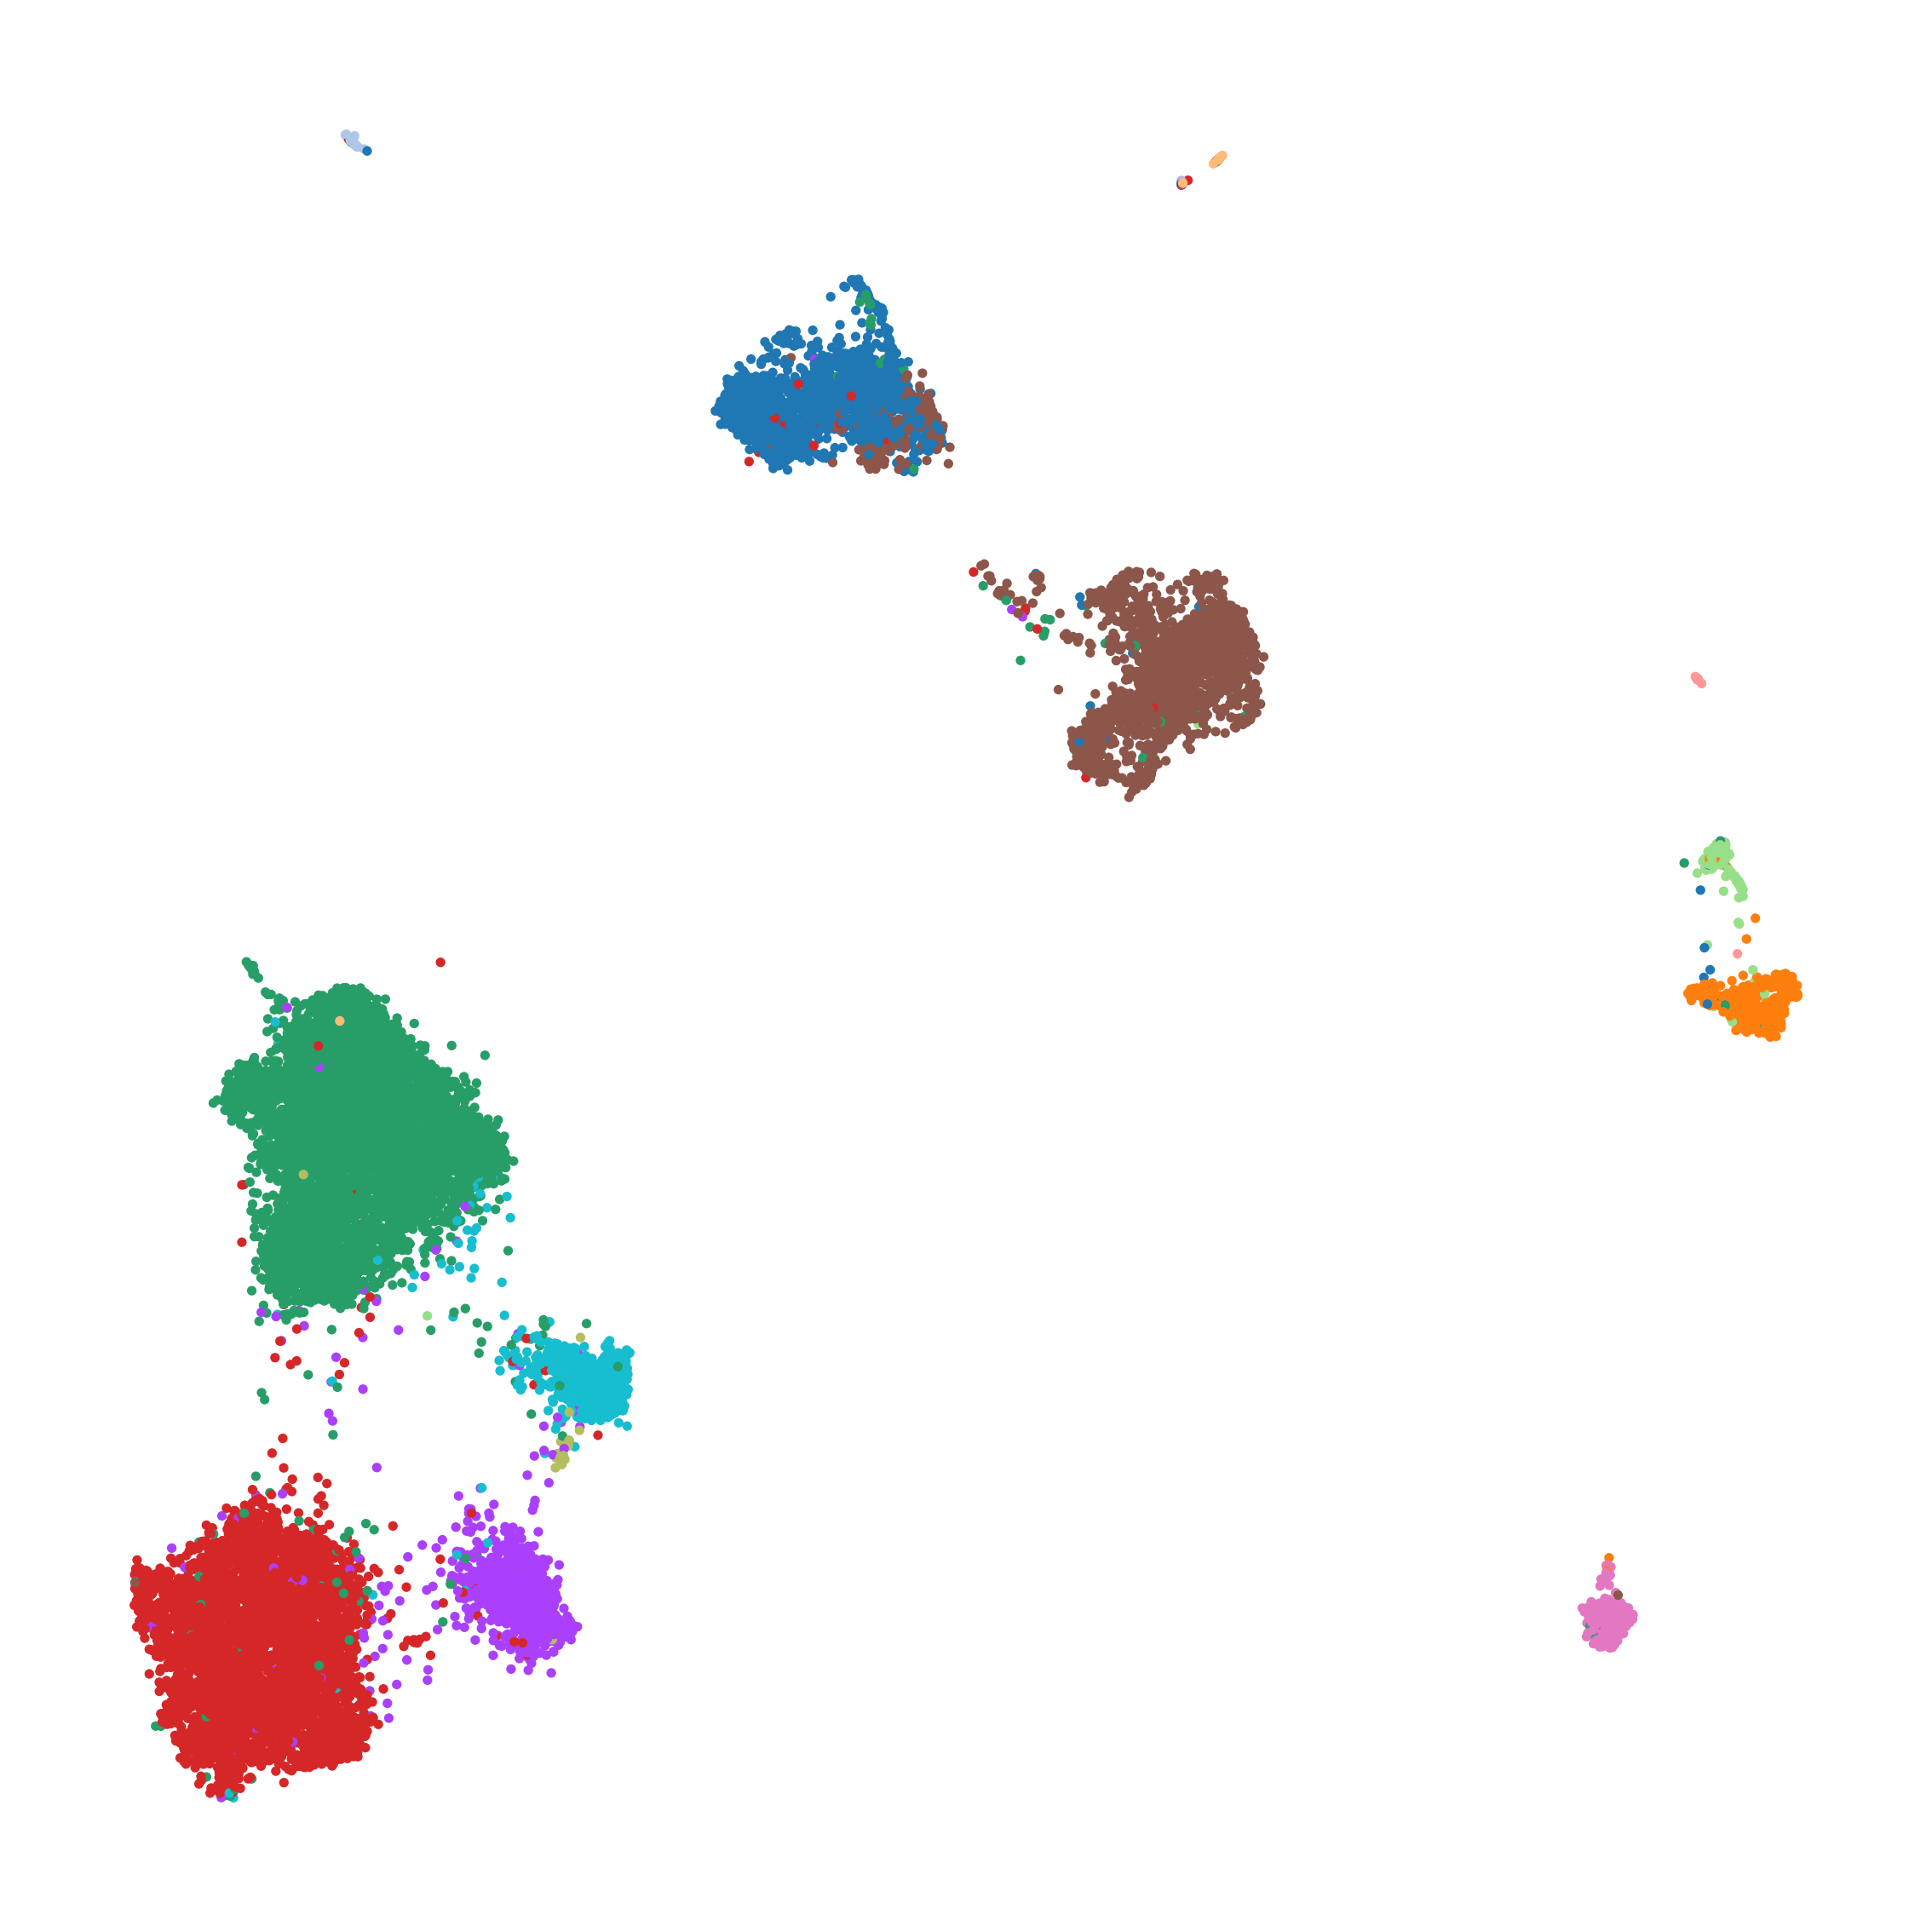

In [48]:
# fig = sc.pl.umap(adata_scvi, color=['batch', 'cell_ontology_class'])
[clear_fig(sc.pl.umap(adata_scvi, color=c, title='', legend_loc=None, return_fig=True)).savefig(f'./{path_results}/scvi_{c}.jpg')  for c in ['batch', 'cell_ontology_class']]

In [49]:
scvi_bems = metrics.batch_entropy_mixing_score(adata_scvi.obsm['X_umap'], adata_scvi.obs['batch'])
print(scvi_bems)
scvi_sc = metrics.silhouette_score(adata_scvi.obsm['X_umap'], adata_scvi.obs['cell_ontology_class'].cat.codes)
print(scvi_sc)

0.47521409570268514
0.55323607


In [50]:
scvi_metrics = metrics.evaluate_all(adata_raw, adata_scvi, 'scvi', batch_key='batch', label_key='cell_ontology_class', cluster_nmi=None, verbose=False)
print(scvi_metrics)


C:\Users\10360\anaconda3\envs\py39\lib\site-packages\scib\metrics\metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
                                  0
NMI_cluster/label          0.890500
ARI_cluster/label          0.930557
ASW_label                  0.546423
ASW_label/batch            0.905807
PCR_batch                  0.874197
cell_cycle_conservation         NaN
isolated_label_F1          0.179487
isolated_label_silhouette  0.674148
graph_conn                 0.985370
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN


In [51]:
scvi_metrics.to_csv(f'{path_results}/scvi_metrics.csv', index=True, header=True)

# scaleX

2023-08-18 17:00:57,441 - SCALEX - INFO - Raw dataset shape: (16382, 19093)
2023-08-18 17:00:57,441 - SCALEX - INFO - Raw dataset shape: (16382, 19093)
2023-08-18 17:00:57,442 - SCALEX - INFO - There are 6 batches under batch_name: batch
2023-08-18 17:00:57,442 - SCALEX - INFO - There are 6 batches under batch_name: batch
2023-08-18 17:00:57,443 - SCALEX - INFO - Preprocessing
2023-08-18 17:00:57,443 - SCALEX - INFO - Preprocessing
2023-08-18 17:00:57,459 - SCALEX - INFO - Filtering cells
2023-08-18 17:00:57,459 - SCALEX - INFO - Filtering cells
2023-08-18 17:00:58,251 - SCALEX - INFO - Filtering features
2023-08-18 17:00:58,251 - SCALEX - INFO - Filtering features
2023-08-18 17:00:58,692 - SCALEX - INFO - Normalizing total per cell
2023-08-18 17:00:58,692 - SCALEX - INFO - Normalizing total per cell
2023-08-18 17:00:58,876 - SCALEX - INFO - Log1p transforming
2023-08-18 17:00:58,876 - SCALEX - INFO - Log1p transforming
2023-08-18 17:00:59,280 - SCALEX - INFO - Finding variable feature

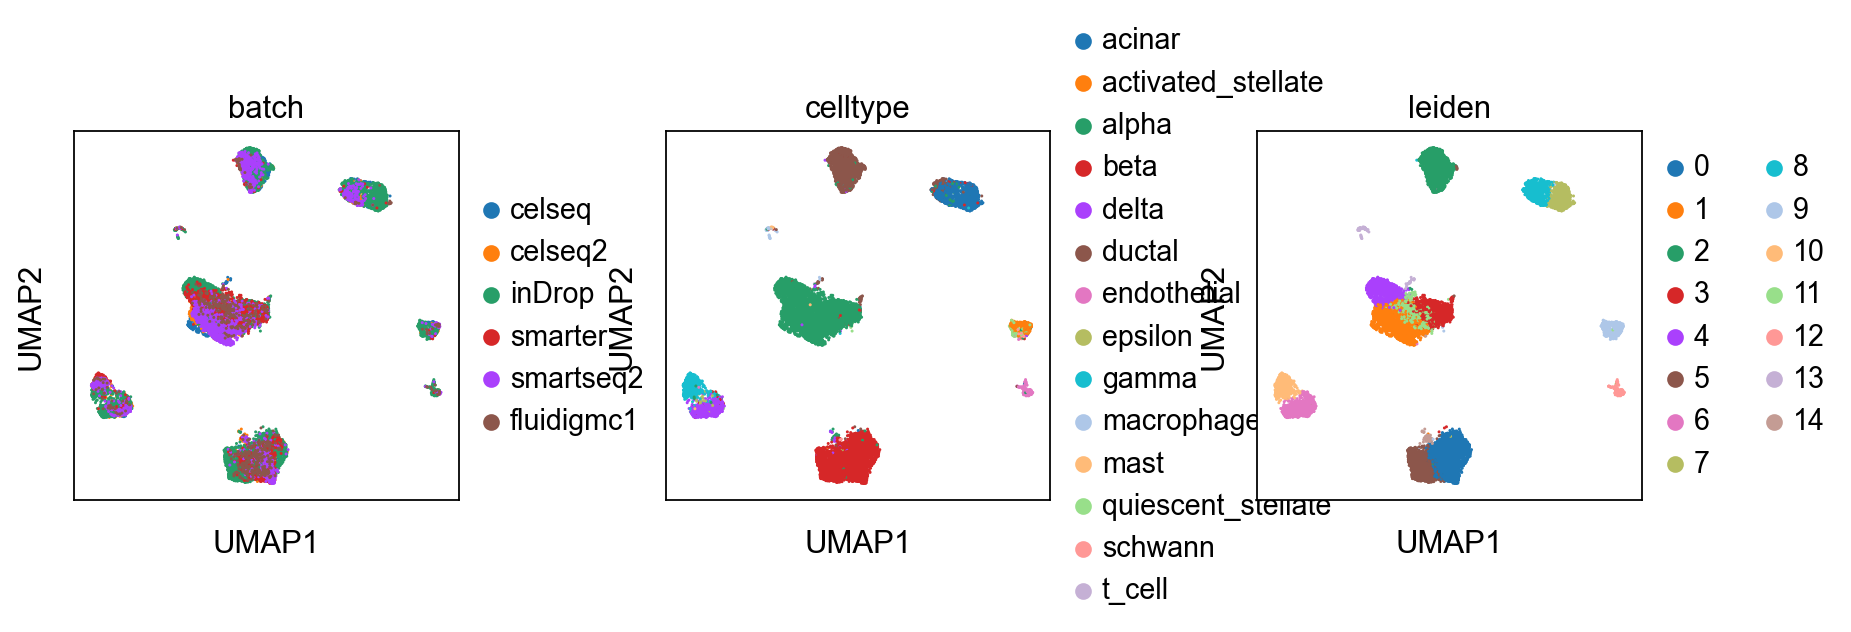

In [35]:
from scCorrect.baseline import scaleX_integrate
adata_scaleX = scaleX_integrate(data_list, batches=conditions, max_iteration=30000)

In [36]:
sc.settings.set_figure_params(facecolor='white', frameon=False, dpi=300, dpi_save=300, figsize=(4, 4))

[None, None]

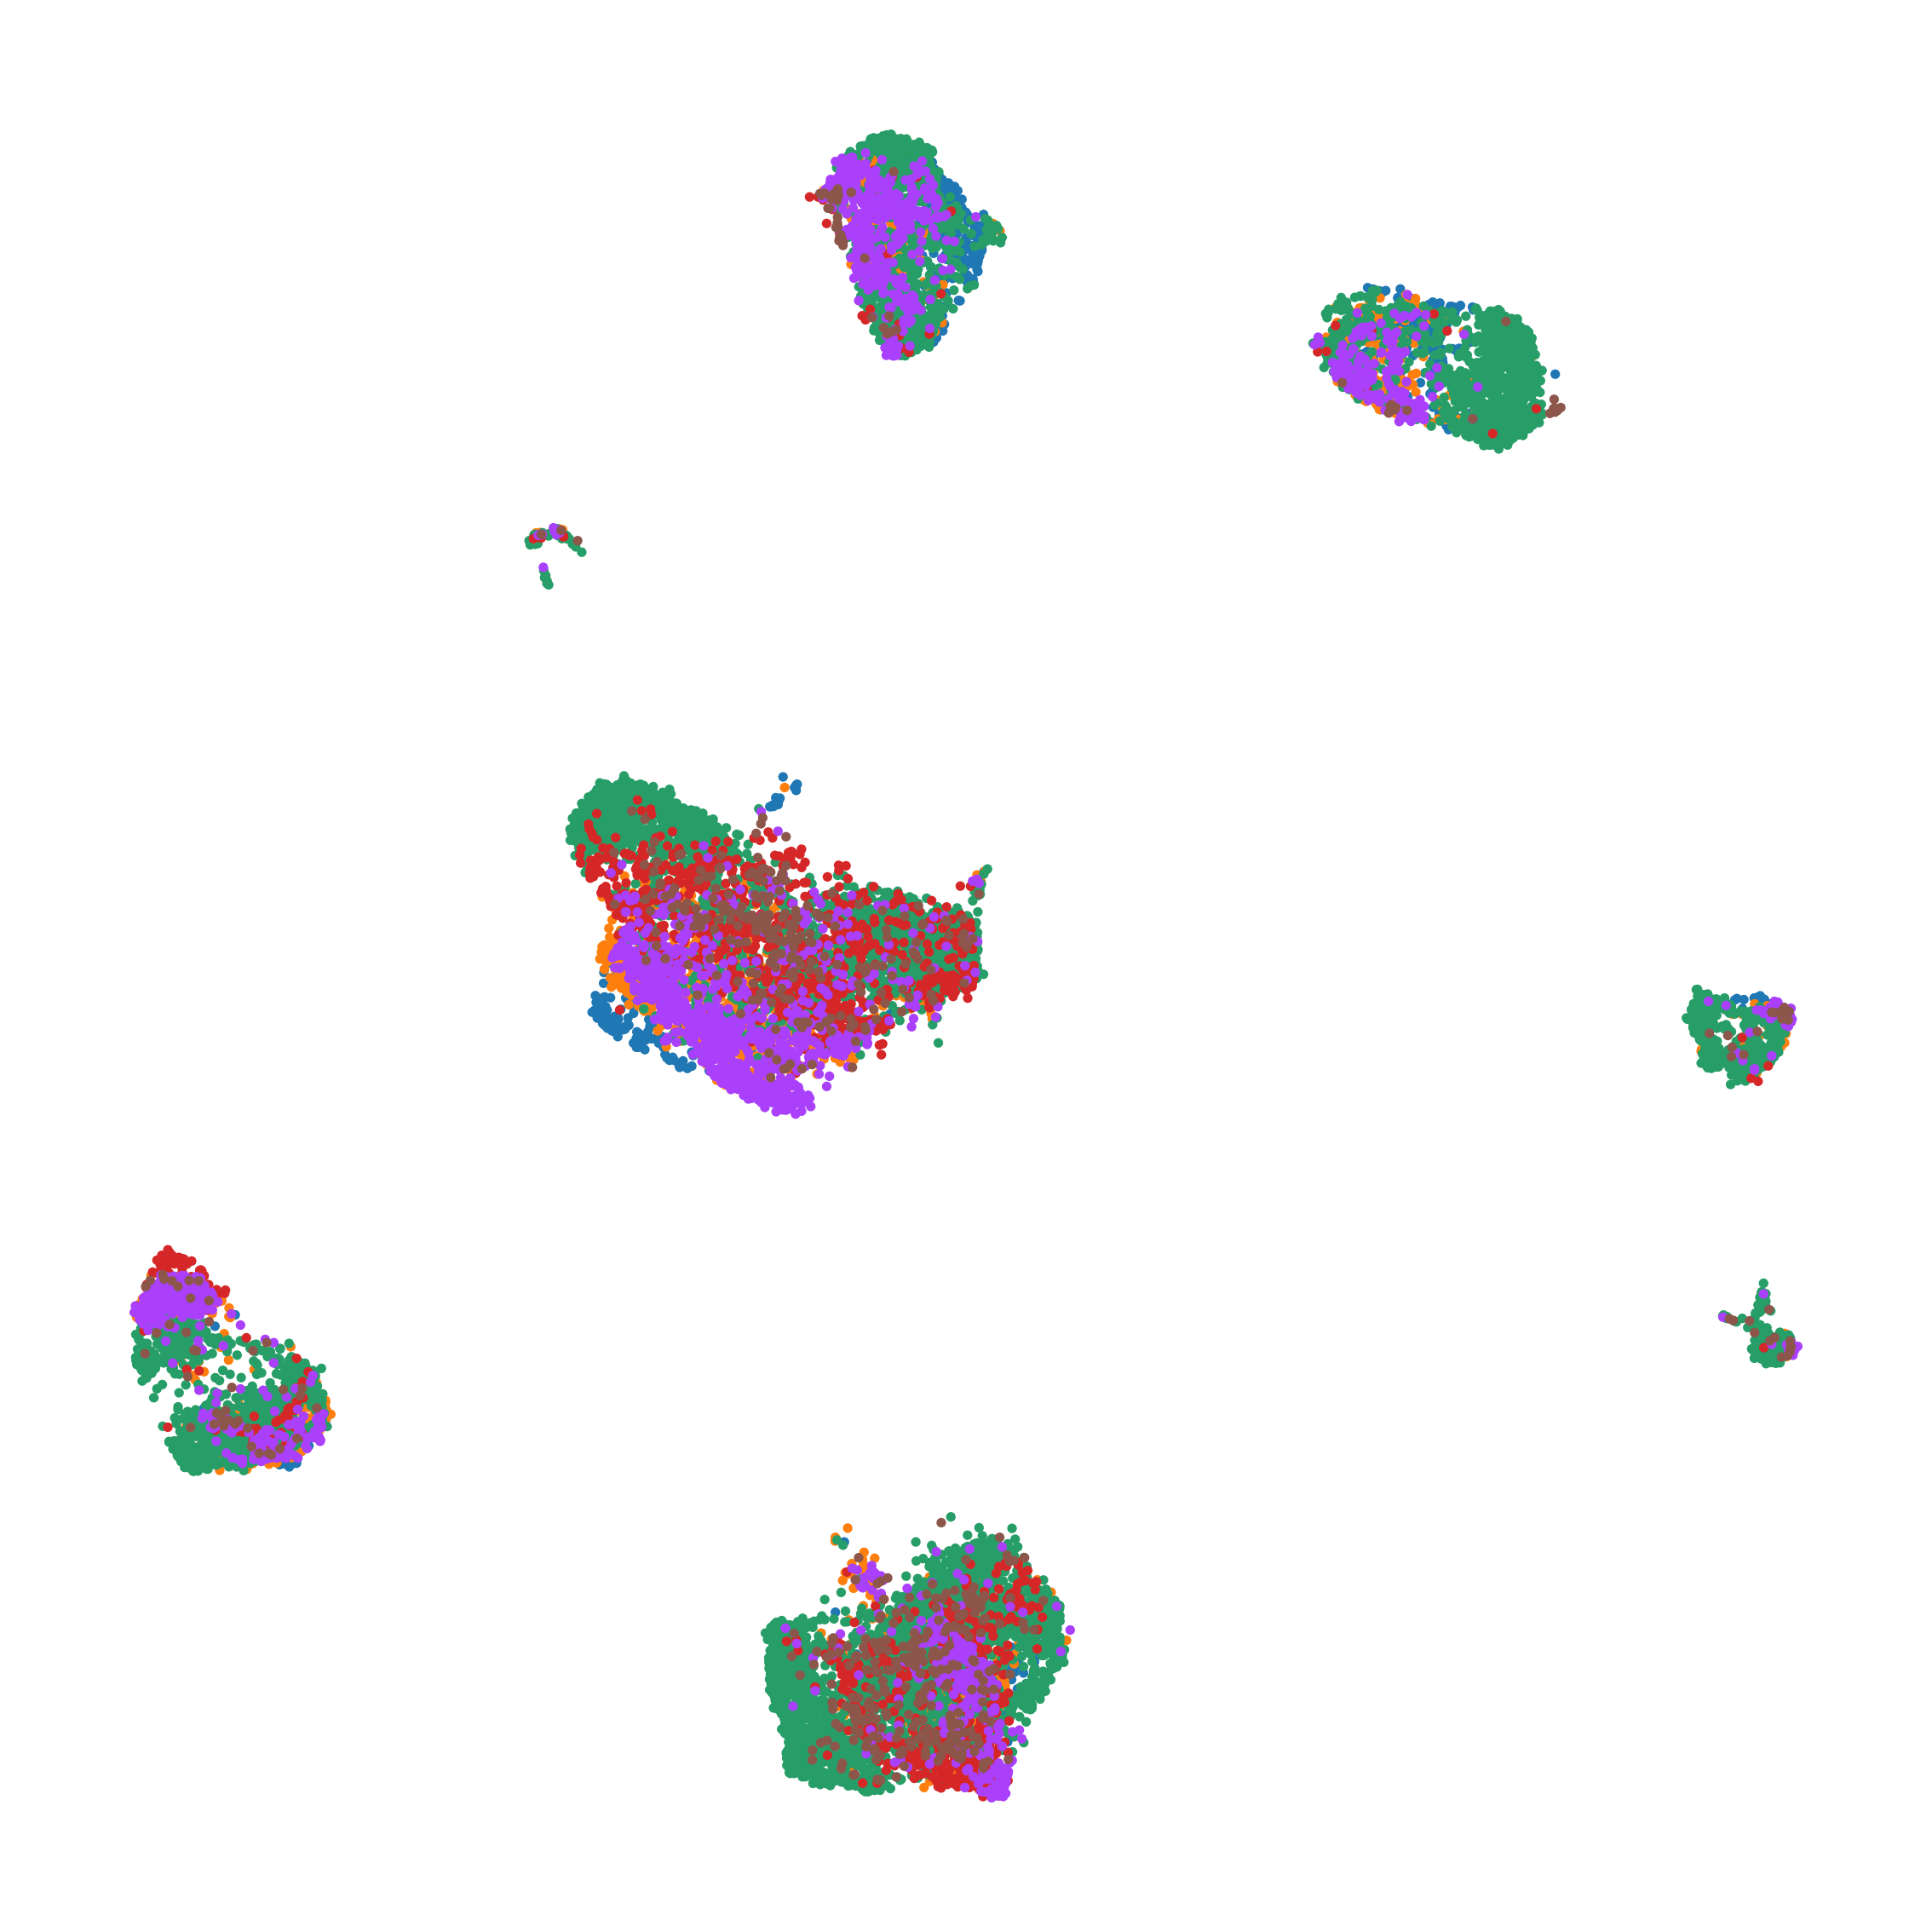

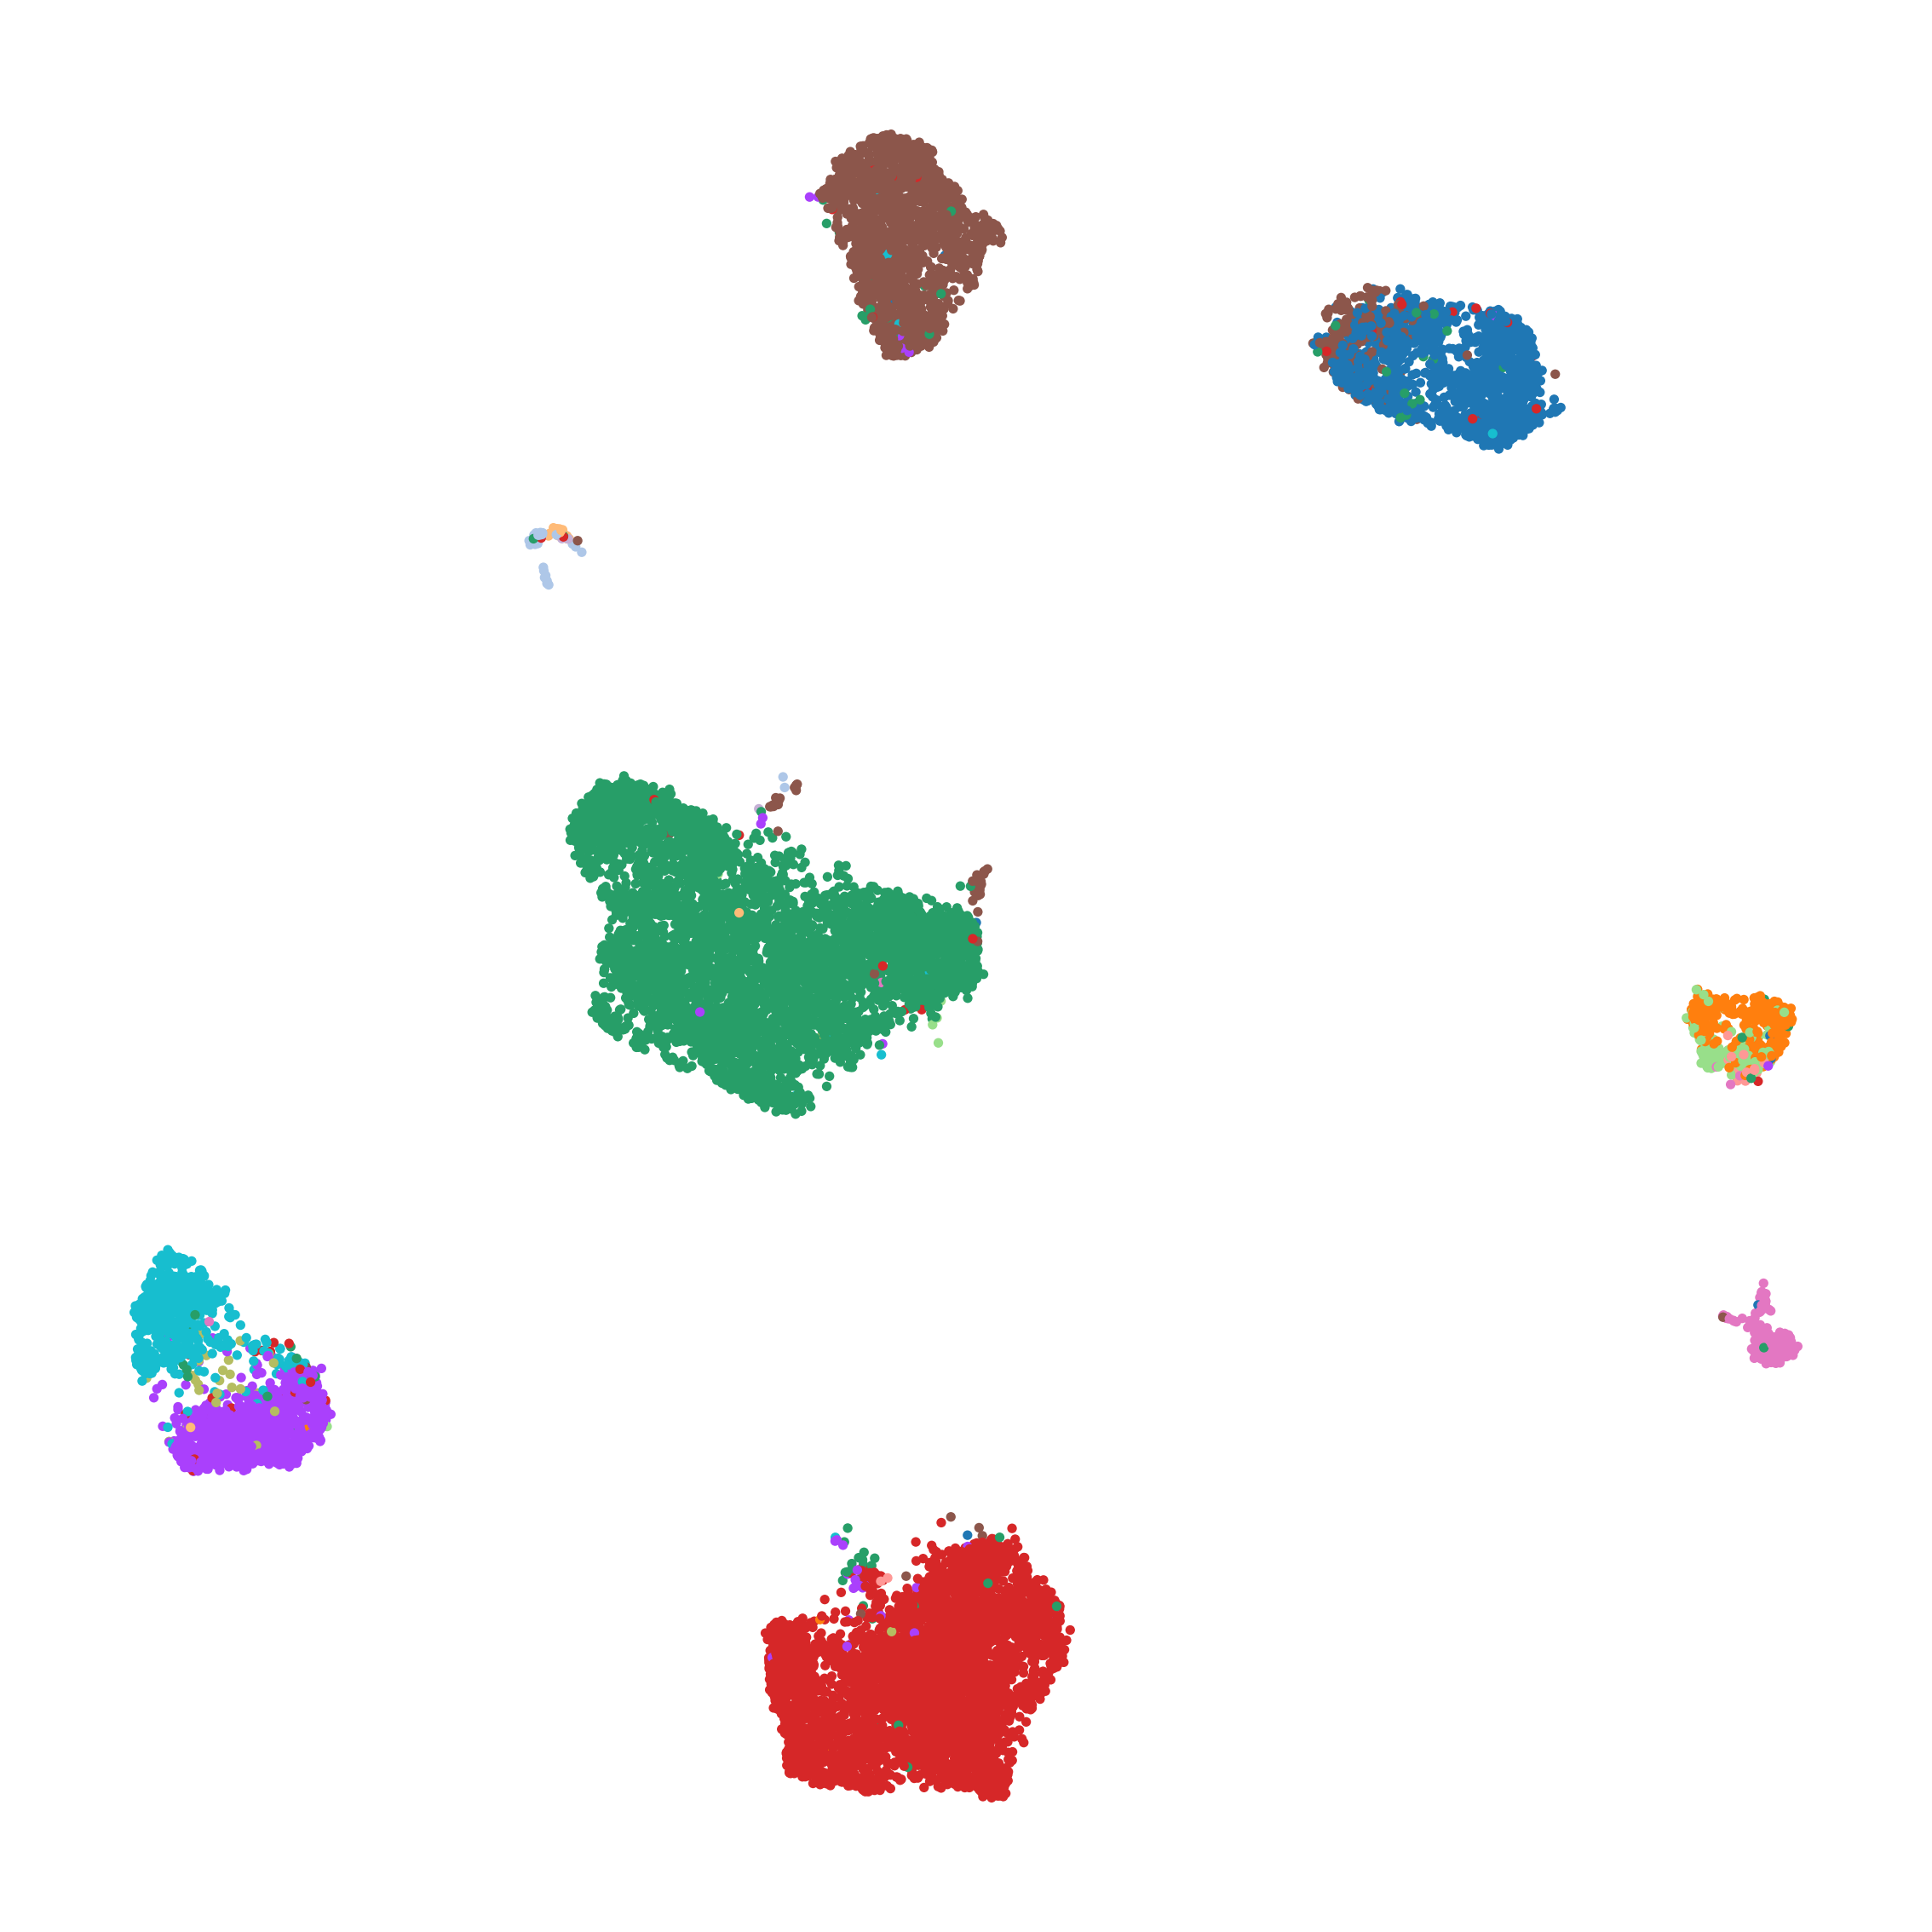

In [37]:
sc.pp.neighbors(adata_scaleX, use_rep='X_emb', n_neighbors=30)
sc.tl.umap(adata_scaleX, min_dist=0.1)
# fig = sc.pl.umap(adata_scaleX, color=['batch', 'cell_ontology_class'])
[clear_fig(sc.pl.umap(adata_scaleX, color=c, title='', legend_loc=None, return_fig=True)).savefig(f'./{path_results}/scaleX_{c}.jpg')  for c in ['batch', 'cell_ontology_class']]

In [38]:
scaleX_bems = metrics.batch_entropy_mixing_score(adata_scaleX.obsm['X_umap'], adata_scaleX.obs['batch'])
print(scaleX_bems)
scaleX_sc = metrics.silhouette_score(adata_scaleX.obsm['X_umap'], adata_scaleX.obs['cell_ontology_class'].cat.codes)
print(scaleX_sc)

0.45105067287810724
0.5889076


In [39]:
scaleX_metrics = metrics.evaluate_all(adata_raw, adata_scaleX, 'scalex', batch_key='batch', label_key='cell_ontology_class', cluster_nmi=None, verbose=False)
print(scaleX_metrics)


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels F1...
Compute neighbors on rep X_emb
Isolated labels ASW...
Graph connectivity...
                                  0
NMI_cluster/label          0.876505
ARI_cluster/label          0.922979
ASW_label                  0.623284
ASW_label/batch            0.881384
PCR_batch                  0.999249
cell_cycle_conservation         NaN
isolated_label_F1          0.094488
isolated_label_silhouette  0.584182
graph_conn                 0.987762
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN


In [40]:
scaleX_metrics.to_csv(f'{path_results}/scaleX_metrics.csv', index=True, header=True)